### Membership inference attack

In [24]:
#!pip install xgboost
#!pip install sdv
from sdv.evaluation import evaluate
from sdv.metrics.tabular import CSTest, KSComplement
import pandas as pd
import numpy as np
from sklearn.neighbors import KDTree
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import RocCurveDisplay
import sklearn
from sklearn.preprocessing import MinMaxScaler
import random
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from collections import Counter
from xgboost import XGBClassifier

## Load the datasets

In [ ]:
##Real Dataset
realData = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Real_Datasets/testCTABGAN4.csv")

##Synthetic Dataset
synthData = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Fake_Datasets/450epoch_AUCPRC/450epoch_AUCPRC_fake_4.csv")



## Utility

The following code can be used for performing TSTR (Training on Synthetic Test on Real) or TRTR (Train on Real Test on Real) tests. The idea is to first run it as TRTR using only your real dataset to stablish a baseline on what accuracy you would get with real data. Then use it training it on synthetic and testing against real to see whether the model has high utility. Simply run this cell to load the code.

In [26]:
#first dataset is the training dataset and the second one the test dataset against where predictions will be done
def TRTRtesting(train, test, classifier='Logistic'):
    X_train = train.iloc[:, 0:25].values
    y_train = train.iloc[:, 26].values
    X_test = test.iloc[:, 0:25].values
    y_test = test.iloc[:, 26].values
    
    if (classifier=='Logistic'):
        regressor = sklearn.linear_model.LogisticRegression(multi_class='auto', solver='lbfgs')
    elif (classifier=='rf'):
        regressor = RandomForestClassifier(n_estimators=1000, random_state=0)
    elif (classifier=='XGBoost'):
        regressor = XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=300, silent=True, objective='binary:logistic', booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=1)
    
    regressor.fit(X_train, y_train)
    #plot AUC
    #metrics.plot_roc_curve(regressor, X_test, y_test) 
    #plot PRC
    #y_pred = regressor.predict(X_test)
    #precision, recall, _ = precision_recall_curve(y_test, y_pred)
    #print('PRC precision: '+str(precision)+' recall: '+str(recall))
    #display = PrecisionRecallDisplay.from_estimator(
        #regressor, X_test, y_test, name="LinearSVC"
    #)
    auc=RocCurveDisplay.from_estimator(regressor, X_test, y_test)
    prc = PrecisionRecallDisplay.from_estimator(
        regressor, X_test, y_test, name="LinearSVC"
    )
    return auc, prc

#### MIA Calculation

In [25]:
def membershipInferenceAttack(train, holdout, synth):
    #TOMORROW HERE YOU SHOULD ADD THE NORMALIZATION
    
    # fit and transform the DataFrame using the scaler
    scaler = StandardScaler()
    train = pd.DataFrame(scaler.fit_transform(train), columns=train.columns)
    holdout = pd.DataFrame(scaler.fit_transform(holdout), columns=holdout.columns)
    synth = pd.DataFrame(scaler.fit_transform(synth), columns=synth.columns)
    
    #Numpy export
    NpTrain=train.to_numpy()
    NpHoldout=holdout.to_numpy()
    NpSynth=synth.to_numpy()
    
    results=[] 
    
    ## Fitting the data for the Holdout
    neighHoldout = NearestNeighbors(n_neighbors=1)
    neighHoldout.fit(NpHoldout) 
    NearestNeighbors(algorithm='auto', leaf_size=30)
    
    ##Fitting the data for the training
    neighTrain = NearestNeighbors(n_neighbors=1)
    neighTrain.fit(NpTrain) 
    NearestNeighbors(algorithm='auto', leaf_size=30)
    
    for sample in NpSynth:
        ##Getting the actual distances to holdout or training sets
        hodoutResult=neighHoldout.kneighbors(sample.reshape(1, -1))
        trainingResult=neighTrain.kneighbors(sample.reshape(1, -1))

        distanceToHoldout=hodoutResult[0][0][0]
        distanceToTraining=trainingResult[0][0][0]
        if distanceToTraining<distanceToHoldout:
            results.append("training")
        else:
            results.append("holdout")
    counts = Counter(results)
    total=counts['training']+counts['holdout']
    MIAvalue=counts['training']/total
    print("Holdout count: ", counts['holdout'])
    print("Training count: ", counts['training'])
    print("Total count: ", total)
    print("MIA value: ", MIAvalue)
    return MIAvalue

In [27]:
def getKomolgorovSmirnovOfDf(real, synth):
    array=[]
    column_names = real.keys().values.tolist()
    for i in range(len(real.iloc[1,:])):
        colReal = real.iloc[:,[i]] 
        colSynth = synth.iloc[:,[i]]
        value=KSComplement.compute(colReal, colSynth)
        array.append(1-value)
    resultDf1=pd.DataFrame(array,columns=['KS Value'])
    resultDf2=pd.DataFrame(column_names,columns=['Variable Name'])
    resultDf = [resultDf2, resultDf1]
    resultDf = pd.concat(resultDf, axis=1)
    return resultDf


In [28]:
TRTRtesting(train, test, 'Logistic')
TRTRtesting(train, test, 'rf')
TRTRtesting(train, test, 'XGBoost')

NameError: name 'train' is not defined

In [22]:
trainCTGAN = pd.read_csv("javiRealTrainSetepoch100_1_finaltestunbalanced.csv", sep=",", encoding='cp1252')
testCTGAN = pd.read_csv("javiHoldoutSetepoch100_1_finaltestunbalanced.csv", sep=",", encoding='cp1252')
synthCTGAN = pd.read_csv("javiSynthTrainSetepoch100_1_finaltestunbalanced.csv", sep=",", encoding='cp1252')
#CTGAN
membershipInferenceAttack(trainCTGAN, testCTGAN, synthCTGAN)

#### TABDDPM 25000 5 RUN MIA

In [29]:
trainTabDDPM25000 = pd.read_csv("Results/TDDPM_25000_final_test_KS_kyuHwan_stability_MIA_1/RealTDDPM_1.csv", sep=",", encoding='cp1252')
holdoutTabDDPM25000 = pd.read_csv("Results/TDDPM_25000_final_test_KS_kyuHwan_stability_MIA_1/testTDDPM_1.csv", sep=",", encoding='cp1252')
synthTabDDPM25000 = pd.read_csv("Results/TDDPM_25000_final_test_KS_kyuHwan_stability_MIA_1/SyntheticTDDPM_1.csv", sep=",", encoding='cp1252')
trainTabDDPM25000 = trainTabDDPM25000.drop(trainTabDDPM25000.columns[0],axis = 1)
holdoutTabDDPM25000 = holdoutTabDDPM25000.drop(holdoutTabDDPM25000.columns[0],axis = 1)
synthTabDDPM25000 = synthTabDDPM25000.drop(synthTabDDPM25000.columns[0],axis = 1)
membershipInferenceAttack(trainTabDDPM25000, holdoutTabDDPM25000, synthTabDDPM25000)

trainTabDDPM25000 = pd.read_csv("Results/TDDPM_25000_final_test_KS_kyuHwan_stability_MIA_2/RealTDDPM_1.csv", sep=",", encoding='cp1252')
holdoutTabDDPM25000 = pd.read_csv("Results/TDDPM_25000_final_test_KS_kyuHwan_stability_MIA_2/testTDDPM_1.csv", sep=",", encoding='cp1252')
synthTabDDPM25000 = pd.read_csv("Results/TDDPM_25000_final_test_KS_kyuHwan_stability_MIA_2/SyntheticTDDPM_1.csv", sep=",", encoding='cp1252')
trainTabDDPM25000 = trainTabDDPM25000.drop(trainTabDDPM25000.columns[0],axis = 1)
holdoutTabDDPM25000 = holdoutTabDDPM25000.drop(holdoutTabDDPM25000.columns[0],axis = 1)
synthTabDDPM25000 = synthTabDDPM25000.drop(synthTabDDPM25000.columns[0],axis = 1)
membershipInferenceAttack(trainTabDDPM25000, holdoutTabDDPM25000, synthTabDDPM25000)

trainTabDDPM25000 = pd.read_csv("Results/TDDPM_25000_final_test_KS_kyuHwan_stability_MIA_3/RealTDDPM_1.csv", sep=",", encoding='cp1252')
holdoutTabDDPM25000 = pd.read_csv("Results/TDDPM_25000_final_test_KS_kyuHwan_stability_MIA_3/testTDDPM_1.csv", sep=",", encoding='cp1252')
synthTabDDPM25000 = pd.read_csv("Results/TDDPM_25000_final_test_KS_kyuHwan_stability_MIA_3/SyntheticTDDPM_1.csv", sep=",", encoding='cp1252')
trainTabDDPM25000 = trainTabDDPM25000.drop(trainTabDDPM25000.columns[0],axis = 1)
holdoutTabDDPM25000 = holdoutTabDDPM25000.drop(holdoutTabDDPM25000.columns[0],axis = 1)
synthTabDDPM25000 = synthTabDDPM25000.drop(synthTabDDPM25000.columns[0],axis = 1)
membershipInferenceAttack(trainTabDDPM25000, holdoutTabDDPM25000, synthTabDDPM25000)

trainTabDDPM25000 = pd.read_csv("Results/TDDPM_25000_final_test_KS_kyuHwan_stability_MIA_4/RealTDDPM_1.csv", sep=",", encoding='cp1252')
holdoutTabDDPM25000 = pd.read_csv("Results/TDDPM_25000_final_test_KS_kyuHwan_stability_MIA_4/testTDDPM_1.csv", sep=",", encoding='cp1252')
synthTabDDPM25000 = pd.read_csv("Results/TDDPM_25000_final_test_KS_kyuHwan_stability_MIA_4/SyntheticTDDPM_1.csv", sep=",", encoding='cp1252')
trainTabDDPM25000 = trainTabDDPM25000.drop(trainTabDDPM25000.columns[0],axis = 1)
holdoutTabDDPM25000 = holdoutTabDDPM25000.drop(holdoutTabDDPM25000.columns[0],axis = 1)
synthTabDDPM25000 = synthTabDDPM25000.drop(synthTabDDPM25000.columns[0],axis = 1)
membershipInferenceAttack(trainTabDDPM25000, holdoutTabDDPM25000, synthTabDDPM25000)

trainTabDDPM25000 = pd.read_csv("Results/TDDPM_25000_final_test_KS_kyuHwan_stability_MIA_5/RealTDDPM_1.csv", sep=",", encoding='cp1252')
holdoutTabDDPM25000 = pd.read_csv("Results/TDDPM_25000_final_test_KS_kyuHwan_stability_MIA_5/testTDDPM_1.csv", sep=",", encoding='cp1252')
synthTabDDPM25000 = pd.read_csv("Results/TDDPM_25000_final_test_KS_kyuHwan_stability_MIA_5/SyntheticTDDPM_1.csv", sep=",", encoding='cp1252')
trainTabDDPM25000 = trainTabDDPM25000.drop(trainTabDDPM25000.columns[0],axis = 1)
holdoutTabDDPM25000 = holdoutTabDDPM25000.drop(holdoutTabDDPM25000.columns[0],axis = 1)
synthTabDDPM25000 = synthTabDDPM25000.drop(synthTabDDPM25000.columns[0],axis = 1)
membershipInferenceAttack(trainTabDDPM25000, holdoutTabDDPM25000, synthTabDDPM25000)


Holdout count:  27324
Training count:  28739
Total count:  56063
MIA value:  0.5126197313736333
Holdout count:  29109
Training count:  26954
Total count:  56063
MIA value:  0.4807805504521699
Holdout count:  29792
Training count:  26271
Total count:  56063
MIA value:  0.46859782744412537
Holdout count:  29555
Training count:  26508
Total count:  56063
MIA value:  0.47282521449084064


FileNotFoundError: [Errno 2] No such file or directory: 'Results/TDDPM_25000_final_test_KS_kyuHwan_stability_MIA_5/RealTDDPM_1.csv'

In [35]:
result=np.array([0.512,0.480,0.468,0.472])
result.mean()
result.std()

0.483

#### TABDDPM 50000 5 RUN MIA

In [32]:
trainTabDDPM50000 = pd.read_csv("Results/TDDPM_50000_steps_for_MIA_0.499_0.002/RealTDDPM_1.csv", sep=",", encoding='cp1252')
holdoutTabDDPM50000 = pd.read_csv("Results/TDDPM_50000_steps_for_MIA_0.499_0.002/testTDDPM_1.csv", sep=",", encoding='cp1252')
synthTabDDPM50000 = pd.read_csv("Results/TDDPM_50000_steps_for_MIA_0.499_0.002/SyntheticTDDPM_1.csv", sep=",", encoding='cp1252')
trainTabDDPM50000 = trainTabDDPM50000.drop(trainTabDDPM50000.columns[0],axis = 1)
holdoutTabDDPM50000 = holdoutTabDDPM50000.drop(holdoutTabDDPM50000.columns[0],axis = 1)
synthTabDDPM50000 = synthTabDDPM50000.drop(synthTabDDPM50000.columns[0],axis = 1)
membershipInferenceAttack(trainTabDDPM50000, holdoutTabDDPM50000, synthTabDDPM50000)

trainTabDDPM50000 = pd.read_csv("Results/TDDPM_50000_steps_for_MIA_0.499_0.002_2ndRun/RealTDDPM_1.csv", sep=",", encoding='cp1252')
holdoutTabDDPM50000 = pd.read_csv("Results/TDDPM_50000_steps_for_MIA_0.499_0.002_2ndRun/testTDDPM_1.csv", sep=",", encoding='cp1252')
synthTabDDPM50000 = pd.read_csv("Results/TDDPM_50000_steps_for_MIA_0.499_0.002_2ndRun/SyntheticTDDPM_1.csv", sep=",", encoding='cp1252')
trainTabDDPM50000 = trainTabDDPM50000.drop(trainTabDDPM50000.columns[0],axis = 1)
holdoutTabDDPM50000 = holdoutTabDDPM50000.drop(holdoutTabDDPM50000.columns[0],axis = 1)
synthTabDDPM50000 = synthTabDDPM50000.drop(synthTabDDPM50000.columns[0],axis = 1)
membershipInferenceAttack(trainTabDDPM50000, holdoutTabDDPM50000, synthTabDDPM50000)

trainTabDDPM50000 = pd.read_csv("Results/TDDPM_50000_steps_for_MIA_0.499_0.002_3ndRun/RealTDDPM_1.csv", sep=",", encoding='cp1252')
holdoutTabDDPM50000 = pd.read_csv("Results/TDDPM_50000_steps_for_MIA_0.499_0.002_3ndRun/testTDDPM_1.csv", sep=",", encoding='cp1252')
synthTabDDPM50000 = pd.read_csv("Results/TDDPM_50000_steps_for_MIA_0.499_0.002_3ndRun/SyntheticTDDPM_1.csv", sep=",", encoding='cp1252')
trainTabDDPM50000 = trainTabDDPM50000.drop(trainTabDDPM50000.columns[0],axis = 1)
holdoutTabDDPM50000 = holdoutTabDDPM50000.drop(holdoutTabDDPM50000.columns[0],axis = 1)
synthTabDDPM50000 = synthTabDDPM50000.drop(synthTabDDPM50000.columns[0],axis = 1)
membershipInferenceAttack(trainTabDDPM50000, holdoutTabDDPM50000, synthTabDDPM50000)

trainTabDDPM50000 = pd.read_csv("Results/TDDPM_50000_steps_for_MIA_0.499_0.002_4ndRun/RealTDDPM_1.csv", sep=",", encoding='cp1252')
holdoutTabDDPM50000 = pd.read_csv("Results/TDDPM_50000_steps_for_MIA_0.499_0.002_4ndRun/testTDDPM_1.csv", sep=",", encoding='cp1252')
synthTabDDPM50000 = pd.read_csv("Results/TDDPM_50000_steps_for_MIA_0.499_0.002_4ndRun/SyntheticTDDPM_1.csv", sep=",", encoding='cp1252')
trainTabDDPM50000 = trainTabDDPM50000.drop(trainTabDDPM50000.columns[0],axis = 1)
holdoutTabDDPM50000 = holdoutTabDDPM50000.drop(holdoutTabDDPM50000.columns[0],axis = 1)
synthTabDDPM50000 = synthTabDDPM50000.drop(synthTabDDPM50000.columns[0],axis = 1)
membershipInferenceAttack(trainTabDDPM50000, holdoutTabDDPM50000, synthTabDDPM50000)

trainTabDDPM50000 = pd.read_csv("Results/TDDPM_50000_steps_for_MIA_0.499_0.002_5ndRun/RealTDDPM_1.csv", sep=",", encoding='cp1252')
holdoutTabDDPM50000 = pd.read_csv("Results/TDDPM_50000_steps_for_MIA_0.499_0.002_5ndRun/testTDDPM_1.csv", sep=",", encoding='cp1252')
synthTabDDPM50000 = pd.read_csv("Results/TDDPM_50000_steps_for_MIA_0.499_0.002_5ndRun/SyntheticTDDPM_1.csv", sep=",", encoding='cp1252')
trainTabDDPM50000 = trainTabDDPM50000.drop(trainTabDDPM50000.columns[0],axis = 1)
holdoutTabDDPM50000 = holdoutTabDDPM50000.drop(holdoutTabDDPM50000.columns[0],axis = 1)
synthTabDDPM50000 = synthTabDDPM50000.drop(synthTabDDPM50000.columns[0],axis = 1)
membershipInferenceAttack(trainTabDDPM50000, holdoutTabDDPM50000, synthTabDDPM50000)

Holdout count:  29291
Training count:  26772
Total count:  56063
MIA value:  0.47753420259351087
Holdout count:  30758
Training count:  25305
Total count:  56063
MIA value:  0.45136721188662754
Holdout count:  31925
Training count:  24138
Total count:  56063
MIA value:  0.4305513440236876
Holdout count:  25156
Training count:  30907
Total count:  56063
MIA value:  0.5512905124591977
Holdout count:  32182
Training count:  23881
Total count:  56063
MIA value:  0.42596721545404276


0.42596721545404276

#### TABDDPM 75000 5 RUN MIA

In [30]:
trainTabDDPM75000 = pd.read_csv("Results/TDDPM_75000_final_test_KS_kyuHwan_stability_MIA_1/RealTDDPM_1.csv", sep=",", encoding='cp1252')
holdoutTabDDPM75000 = pd.read_csv("Results/TDDPM_75000_final_test_KS_kyuHwan_stability_MIA_1/testTDDPM_1.csv", sep=",", encoding='cp1252')
synthTabDDPM75000 = pd.read_csv("Results/TDDPM_75000_final_test_KS_kyuHwan_stability_MIA_1/SyntheticTDDPM_1.csv", sep=",", encoding='cp1252')
trainTabDDPM75000 = trainTabDDPM75000.drop(trainTabDDPM75000.columns[0],axis = 1)
holdoutTabDDPM75000 = holdoutTabDDPM75000.drop(holdoutTabDDPM75000.columns[0],axis = 1)
synthTabDDPM75000 = synthTabDDPM75000.drop(synthTabDDPM75000.columns[0],axis = 1)
membershipInferenceAttack(trainTabDDPM75000, holdoutTabDDPM75000, synthTabDDPM75000)

trainTabDDPM75000 = pd.read_csv("Results/TDDPM_75000_final_test_KS_kyuHwan_stability_MIA_2/RealTDDPM_1.csv", sep=",", encoding='cp1252')
holdoutTabDDPM75000 = pd.read_csv("Results/TDDPM_75000_final_test_KS_kyuHwan_stability_MIA_2/testTDDPM_1.csv", sep=",", encoding='cp1252')
synthTabDDPM75000 = pd.read_csv("Results/TDDPM_75000_final_test_KS_kyuHwan_stability_MIA_2/SyntheticTDDPM_1.csv", sep=",", encoding='cp1252')
trainTabDDPM75000 = trainTabDDPM75000.drop(trainTabDDPM75000.columns[0],axis = 1)
holdoutTabDDPM75000 = holdoutTabDDPM75000.drop(holdoutTabDDPM75000.columns[0],axis = 1)
synthTabDDPM75000 = synthTabDDPM75000.drop(synthTabDDPM75000.columns[0],axis = 1)
membershipInferenceAttack(trainTabDDPM75000, holdoutTabDDPM75000, synthTabDDPM75000)

trainTabDDPM75000 = pd.read_csv("Results/TDDPM_75000_final_test_KS_kyuHwan_stability_MIA_3/RealTDDPM_1.csv", sep=",", encoding='cp1252')
holdoutTabDDPM75000 = pd.read_csv("Results/TDDPM_75000_final_test_KS_kyuHwan_stability_MIA_3/testTDDPM_1.csv", sep=",", encoding='cp1252')
synthTabDDPM75000 = pd.read_csv("Results/TDDPM_75000_final_test_KS_kyuHwan_stability_MIA_3/SyntheticTDDPM_1.csv", sep=",", encoding='cp1252')
trainTabDDPM75000 = trainTabDDPM75000.drop(trainTabDDPM75000.columns[0],axis = 1)
holdoutTabDDPM75000 = holdoutTabDDPM75000.drop(holdoutTabDDPM75000.columns[0],axis = 1)
synthTabDDPM75000 = synthTabDDPM75000.drop(synthTabDDPM75000.columns[0],axis = 1)
membershipInferenceAttack(trainTabDDPM75000, holdoutTabDDPM75000, synthTabDDPM75000)

trainTabDDPM75000 = pd.read_csv("Results/TDDPM_75000_final_test_KS_kyuHwan_stability_MIA_4/RealTDDPM_1.csv", sep=",", encoding='cp1252')
holdoutTabDDPM75000 = pd.read_csv("Results/TDDPM_75000_final_test_KS_kyuHwan_stability_MIA_4/testTDDPM_1.csv", sep=",", encoding='cp1252')
synthTabDDPM75000 = pd.read_csv("Results/TDDPM_75000_final_test_KS_kyuHwan_stability_MIA_4/SyntheticTDDPM_1.csv", sep=",", encoding='cp1252')
trainTabDDPM75000 = trainTabDDPM75000.drop(trainTabDDPM75000.columns[0],axis = 1)
holdoutTabDDPM75000 = holdoutTabDDPM75000.drop(holdoutTabDDPM75000.columns[0],axis = 1)
synthTabDDPM75000 = synthTabDDPM75000.drop(synthTabDDPM75000.columns[0],axis = 1)
membershipInferenceAttack(trainTabDDPM75000, holdoutTabDDPM75000, synthTabDDPM75000)

trainTabDDPM75000 = pd.read_csv("Results/TDDPM_75000_final_test_KS_kyuHwan_stability_MIA_5/RealTDDPM_1.csv", sep=",", encoding='cp1252')
holdoutTabDDPM75000 = pd.read_csv("Results/TDDPM_75000_final_test_KS_kyuHwan_stability_MIA_5/testTDDPM_1.csv", sep=",", encoding='cp1252')
synthTabDDPM75000 = pd.read_csv("Results/TDDPM_75000_final_test_KS_kyuHwan_stability_MIA_5/SyntheticTDDPM_1.csv", sep=",", encoding='cp1252')
trainTabDDPM75000 = trainTabDDPM75000.drop(trainTabDDPM75000.columns[0],axis = 1)
holdoutTabDDPM75000 = holdoutTabDDPM75000.drop(holdoutTabDDPM75000.columns[0],axis = 1)
synthTabDDPM75000 = synthTabDDPM75000.drop(synthTabDDPM75000.columns[0],axis = 1)
membershipInferenceAttack(trainTabDDPM75000, holdoutTabDDPM75000, synthTabDDPM75000)

Holdout count:  29343
Training count:  26720
Total count:  56063
MIA value:  0.476606674633894
Holdout count:  28182
Training count:  27881
Total count:  56063
MIA value:  0.49731552003995505
Holdout count:  30471
Training count:  25592
Total count:  56063
MIA value:  0.45648645274066674
Holdout count:  30049
Training count:  26014
Total count:  56063
MIA value:  0.4640136988744805
Holdout count:  24929
Training count:  31134
Total count:  56063
MIA value:  0.5553395287444483


0.5553395287444483

In [33]:
result=np.array([0.476,0.497,0.456,0.464,0.555])
result.mean()
result.std()

0.4896

#### CTGAN 5 RUN MIA

In [12]:
trainCTGAN = pd.read_csv("Results/CTGAN_100_epoch_for_MIA_0.5_1ndRun/CTGAN_100_epoch_for_MIA_0.5_1ndRun_train.csv", sep=",", encoding='cp1252')
holdoutCTGAN = pd.read_csv("Results/CTGAN_100_epoch_for_MIA_0.5_1ndRun/CTGAN_100_epoch_for_MIA_0.5_1ndRun_holdout.csv", sep=",", encoding='cp1252')
synthCTGAN = pd.read_csv("Results/CTGAN_100_epoch_for_MIA_0.5_1ndRun/CTGAN_100_epoch_for_MIA_0.5_1ndRun_synth.csv", sep=",", encoding='cp1252')
trainCTGAN = trainCTGAN.drop(trainCTGAN.columns[0],axis = 1)
holdoutCTGAN = holdoutCTGAN.drop(holdoutCTGAN.columns[0],axis = 1)
synthCTGAN = synthCTGAN.drop(synthCTGAN.columns[0],axis = 1)
membershipInferenceAttack(trainCTGAN, holdoutCTGAN, synthCTGAN)


trainCTGAN = pd.read_csv("Results/CTGAN_100_epoch_for_MIA_0.5_2ndRun/CTGAN_100_epoch_for_MIA_0.5_2ndRun_train.csv", sep=",", encoding='cp1252')
holdoutCTGAN = pd.read_csv("Results/CTGAN_100_epoch_for_MIA_0.5_2ndRun/CTGAN_100_epoch_for_MIA_0.5_2ndRun_holdout.csv", sep=",", encoding='cp1252')
synthCTGAN = pd.read_csv("Results/CTGAN_100_epoch_for_MIA_0.5_2ndRun/CTGAN_100_epoch_for_MIA_0.5_2ndRun_synth.csv", sep=",", encoding='cp1252')
trainCTGAN = trainCTGAN.drop(trainCTGAN.columns[0],axis = 1)
holdoutCTGAN = holdoutCTGAN.drop(holdoutCTGAN.columns[0],axis = 1)
synthCTGAN = synthCTGAN.drop(synthCTGAN.columns[0],axis = 1)
membershipInferenceAttack(trainCTGAN, holdoutCTGAN, synthCTGAN)

trainCTGAN = pd.read_csv("Results/CTGAN_100_epoch_for_MIA_0.5_3ndRun/CTGAN_100_epoch_for_MIA_0.5_3ndRun_train.csv", sep=",", encoding='cp1252')
holdoutCTGAN = pd.read_csv("Results/CTGAN_100_epoch_for_MIA_0.5_3ndRun/CTGAN_100_epoch_for_MIA_0.5_3ndRun_holdout.csv", sep=",", encoding='cp1252')
synthCTGAN = pd.read_csv("Results/CTGAN_100_epoch_for_MIA_0.5_3ndRun/CTGAN_100_epoch_for_MIA_0.5_3ndRun_synth.csv", sep=",", encoding='cp1252')
trainCTGAN = trainCTGAN.drop(trainCTGAN.columns[0],axis = 1)
holdoutCTGAN = holdoutCTGAN.drop(holdoutCTGAN.columns[0],axis = 1)
synthCTGAN = synthCTGAN.drop(synthCTGAN.columns[0],axis = 1)
membershipInferenceAttack(trainCTGAN, holdoutCTGAN, synthCTGAN)

trainCTGAN = pd.read_csv("Results/CTGAN_100_epoch_for_MIA_0.5_4ndRun/CTGAN_100_epoch_for_MIA_0.5_4ndRun_train.csv", sep=",", encoding='cp1252')
holdoutCTGAN = pd.read_csv("Results/CTGAN_100_epoch_for_MIA_0.5_4ndRun/CTGAN_100_epoch_for_MIA_0.5_4ndRun_holdout.csv", sep=",", encoding='cp1252')
synthCTGAN = pd.read_csv("Results/CTGAN_100_epoch_for_MIA_0.5_4ndRun/CTGAN_100_epoch_for_MIA_0.5_4ndRun_synth.csv", sep=",", encoding='cp1252')
trainCTGAN = trainCTGAN.drop(trainCTGAN.columns[0],axis = 1)
holdoutCTGAN = holdoutCTGAN.drop(holdoutCTGAN.columns[0],axis = 1)
synthCTGAN = synthCTGAN.drop(synthCTGAN.columns[0],axis = 1)
membershipInferenceAttack(trainCTGAN, holdoutCTGAN, synthCTGAN)

trainCTGAN = pd.read_csv("Results/CTGAN_100_epoch_for_MIA_0.5_5ndRun/CTGAN_100_epoch_for_MIA_0.5_5ndRun_train.csv", sep=",", encoding='cp1252')
holdoutCTGAN = pd.read_csv("Results/CTGAN_100_epoch_for_MIA_0.5_5ndRun/CTGAN_100_epoch_for_MIA_0.5_5ndRun_holdout.csv", sep=",", encoding='cp1252')
synthCTGAN = pd.read_csv("Results/CTGAN_100_epoch_for_MIA_0.5_5ndRun/CTGAN_100_epoch_for_MIA_0.5_5ndRun_synth.csv", sep=",", encoding='cp1252')
trainCTGAN = trainCTGAN.drop(trainCTGAN.columns[0],axis = 1)
holdoutCTGAN = holdoutCTGAN.drop(holdoutCTGAN.columns[0],axis = 1)
synthCTGAN = synthCTGAN.drop(synthCTGAN.columns[0],axis = 1)
membershipInferenceAttack(trainCTGAN, holdoutCTGAN, synthCTGAN)

Holdout count:  29307
Training count:  26869
Total count:  56176
MIA value:  0.4783003417829678
Holdout count:  30607
Training count:  25569
Total count:  56176
MIA value:  0.4551587866704643
Holdout count:  29746
Training count:  26430
Total count:  56176
MIA value:  0.47048561663343774
Holdout count:  29931
Training count:  26245
Total count:  56176
MIA value:  0.4671923953289661
Holdout count:  26524
Training count:  29652
Total count:  56176
MIA value:  0.5278410709199658


0.5278410709199658

#### 450 epoch CTABGAN+ MIA

In [7]:
trainCTAGBAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Real_Datasets/trainCTABGAN_MIA1.csv")
holdoutCTAGBAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Real_Datasets/testCTABGAN_MIA1.csv")
synthCTABGAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Fake_Datasets/450epoch_MIA/450epoch_MIA_fake_1.csv")
membershipInferenceAttack(trainCTAGBAN, holdoutCTAGBAN, synthCTABGAN)

trainCTAGBAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Real_Datasets/trainCTABGAN_MIA2.csv")
holdoutCTAGBAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Real_Datasets/testCTABGAN_MIA2.csv")
synthCTABGAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Fake_Datasets/450epoch_MIA/450epoch_MIA_fake_2.csv")
membershipInferenceAttack(trainCTAGBAN, holdoutCTAGBAN, synthCTABGAN)

trainCTAGBAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Real_Datasets/trainCTABGAN_MIA3.csv")
holdoutCTAGBAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Real_Datasets/testCTABGAN_MIA3.csv")
synthCTABGAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Fake_Datasets/450epoch_MIA/450epoch_MIA_fake_3.csv")
membershipInferenceAttack(trainCTAGBAN, holdoutCTAGBAN, synthCTABGAN)

trainCTAGBAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Real_Datasets/trainCTABGAN_MIA4.csv")
holdoutCTAGBAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Real_Datasets/testCTABGAN_MIA4.csv")
synthCTABGAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Fake_Datasets/450epoch_MIA/450epoch_MIA_fake_4.csv")
membershipInferenceAttack(trainCTAGBAN, holdoutCTAGBAN, synthCTABGAN)

trainCTAGBAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Real_Datasets/trainCTABGAN_MIA5.csv")
holdoutCTAGBAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Real_Datasets/testCTABGAN_MIA5.csv")
synthCTABGAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Fake_Datasets/450epoch_MIA/450epoch_MIA_fake_5.csv")
membershipInferenceAttack(trainCTAGBAN, holdoutCTAGBAN, synthCTABGAN)

Holdout count:  30707
Training count:  25469
Total count:  56176
MIA value:  0.45337866704642554
Holdout count:  29415
Training count:  26761
Total count:  56176
MIA value:  0.47637781258900597
Holdout count:  26249
Training count:  29927
Total count:  56176
MIA value:  0.5327363998860724
Holdout count:  27985
Training count:  28191
Total count:  56176
MIA value:  0.5018335232127599
Holdout count:  28741
Training count:  27435
Total count:  56176
MIA value:  0.48837581885502707


0.48837581885502707

In [13]:
result=np.array([0.453,0.476,0.532,0.501,0.488])
result.mean()
result.std()

0.026283074401599223

#### 300 epoch CTABGAN+ MIA

In [47]:
#trainCTAGBAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Real_Datasets/trainCTABGAN_MIA1.csv")
#holdoutCTAGBAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Real_Datasets/testCTABGAN_MIA1.csv")
#synthCTABGAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Fake_Datasets/300epoch_MIA/300epoch_MIA_fake_1.csv")
#membershipInferenceAttack(trainCTAGBAN, holdoutCTAGBAN, synthCTABGAN)

#trainCTAGBAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Real_Datasets/trainCTABGAN_MIA2.csv")
#holdoutCTAGBAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Real_Datasets/testCTABGAN_MIA2.csv")
#synthCTABGAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Fake_Datasets/300epoch_MIA/300epoch_MIA_fake_2.csv")
#membershipInferenceAttack(trainCTAGBAN, holdoutCTAGBAN, synthCTABGAN)

#trainCTAGBAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Real_Datasets/trainCTABGAN_MIA3.csv")
#holdoutCTAGBAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Real_Datasets/testCTABGAN_MIA3.csv")
#synthCTABGAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Fake_Datasets/300epoch_MIA/300epoch_MIA_fake_3.csv")
#membershipInferenceAttack(trainCTAGBAN, holdoutCTAGBAN, synthCTABGAN)

#trainCTAGBAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Real_Datasets/trainCTABGAN_MIA4.csv")
#holdoutCTAGBAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Real_Datasets/testCTABGAN_MIA4.csv")
#synthCTABGAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Fake_Datasets/300epoch_MIA/300epoch_MIA_fake_4.csv")
#membershipInferenceAttack(trainCTAGBAN, holdoutCTAGBAN, synthCTABGAN)

trainCTAGBAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Real_Datasets/trainCTABGAN_MIA5.csv")
holdoutCTAGBAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Real_Datasets/testCTABGAN_MIA5.csv")
synthCTABGAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Fake_Datasets/300epoch_MIA/300epoch_MIA_fake_5.csv")
membershipInferenceAttack(trainCTAGBAN, holdoutCTAGBAN, synthCTABGAN)

Holdout count:  27749
Training count:  28427
Total count:  56176
MIA value:  0.5060346055254913


0.5060346055254913

In [49]:
result=np.array([0.407,0.482,0.512,0.512,0.506])
result.mean()
result.std()
#mean: 0.483
#std: 0.039

0.4838

#### 150 epoch CTABGAN+ MIA

In [32]:
trainCTAGBAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Real_Datasets/trainCTABGAN_MIA1.csv")
holdoutCTAGBAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Real_Datasets/testCTABGAN_MIA1.csv")
synthCTABGAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Fake_Datasets/150epoch_MIA/150epoch_MIA_fake_1.csv")
membershipInferenceAttack(trainCTAGBAN, holdoutCTAGBAN, synthCTABGAN)

trainCTAGBAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Real_Datasets/trainCTABGAN_MIA2.csv")
holdoutCTAGBAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Real_Datasets/testCTABGAN_MIA2.csv")
synthCTABGAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Fake_Datasets/150epoch_MIA/150epoch_MIA_fake_2.csv")
membershipInferenceAttack(trainCTAGBAN, holdoutCTAGBAN, synthCTABGAN)

trainCTAGBAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Real_Datasets/trainCTABGAN_MIA3.csv")
holdoutCTAGBAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Real_Datasets/testCTABGAN_MIA3.csv")
synthCTABGAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Fake_Datasets/150epoch_MIA/150epoch_MIA_fake_3.csv")
membershipInferenceAttack(trainCTAGBAN, holdoutCTAGBAN, synthCTABGAN)

trainCTAGBAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Real_Datasets/trainCTABGAN_MIA4.csv")
holdoutCTAGBAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Real_Datasets/testCTABGAN_MIA4.csv")
synthCTABGAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Fake_Datasets/150epoch_MIA/150epoch_MIA_fake_4.csv")
membershipInferenceAttack(trainCTAGBAN, holdoutCTAGBAN, synthCTABGAN)

#trainCTAGBAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Real_Datasets/trainCTABGAN_MIA5.csv")
#holdoutCTAGBAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Real_Datasets/testCTABGAN_MIA5.csv")
#synthCTABGAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Fake_Datasets/150epoch_MIA/150epoch_MIA_fake_5.csv")
#membershipInferenceAttack(trainCTAGBAN, holdoutCTAGBAN, synthCTABGAN)

Holdout count:  31994
Training count:  24182
Total count:  56176
MIA value:  0.430468527485047
Holdout count:  29280
Training count:  26896
Total count:  56176
MIA value:  0.47878097408145825
Holdout count:  26764
Training count:  29412
Total count:  56176
MIA value:  0.5235687838222729
Holdout count:  28221
Training count:  27955
Total count:  56176
MIA value:  0.4976324409000285


0.4976324409000285

In [35]:
result=np.array([0.430,0.478,0.523,0.497])
result.mean()
result.std()
#mean: 0.482
#std: 0.034

0.03400735214626391

#### TRTR TESTING

Logistic: 


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Random Forest: 
XGBoost: 
[10:57:26] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

Logistic: 


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Random Forest: 
XGBoost: 
[10:59:03] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

Logistic: 


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Random Forest: 
XGBoost: 
[11:00:42] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

Logistic: 


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Random Forest: 


C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_plot\roc_curve.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


XGBoost: 
[11:02:20] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

Logistic: 


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Random Forest: 
XGBoost: 
[11:03:56] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.



(<sklearn.metrics._plot.roc_curve.RocCurveDisplay at 0x1e09358d940>,
 <sklearn.metrics._plot.precision_recall_curve.PrecisionRecallDisplay at 0x1e093947460>)

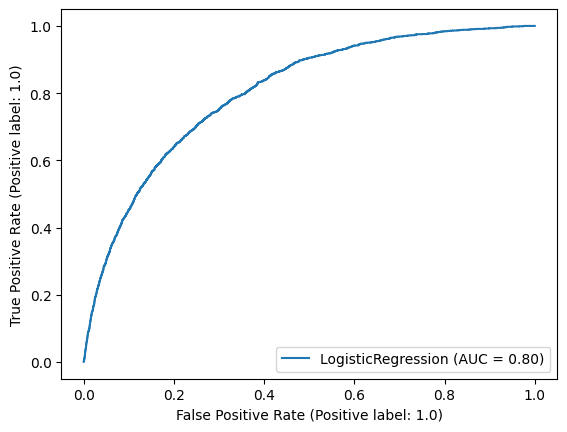

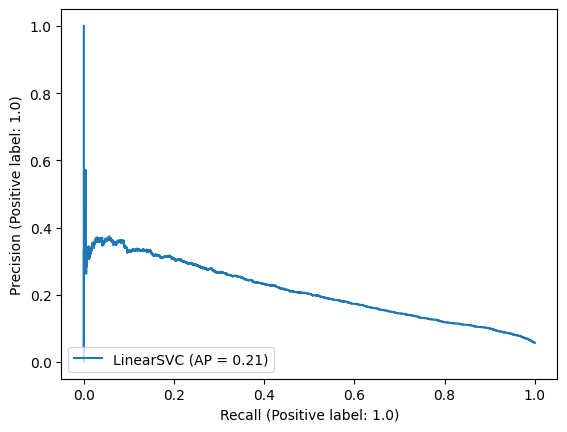

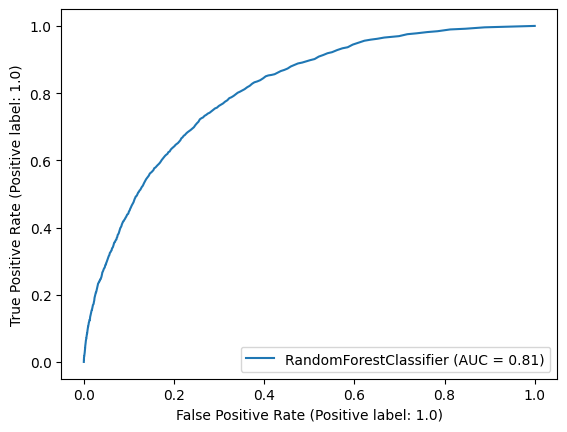

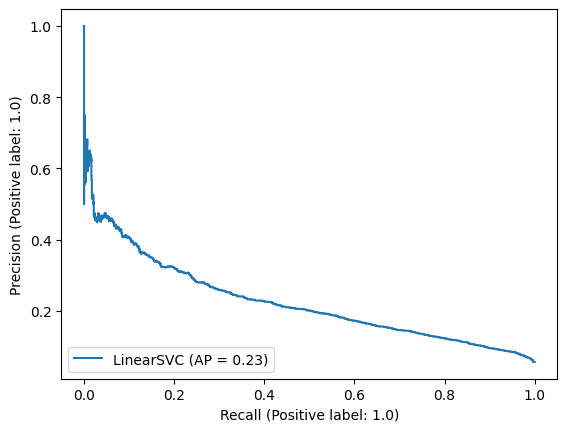

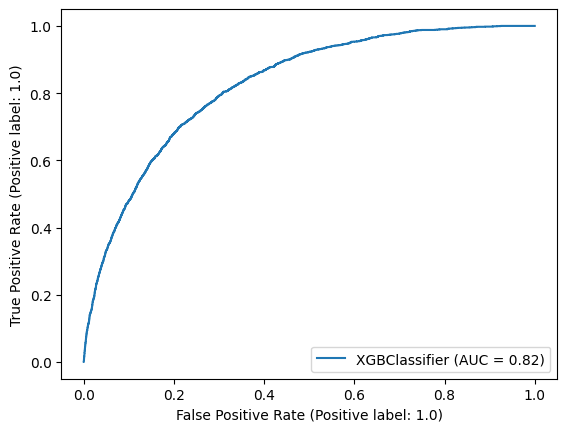

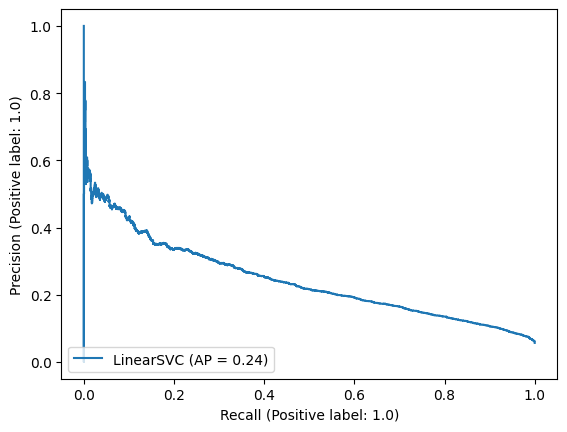

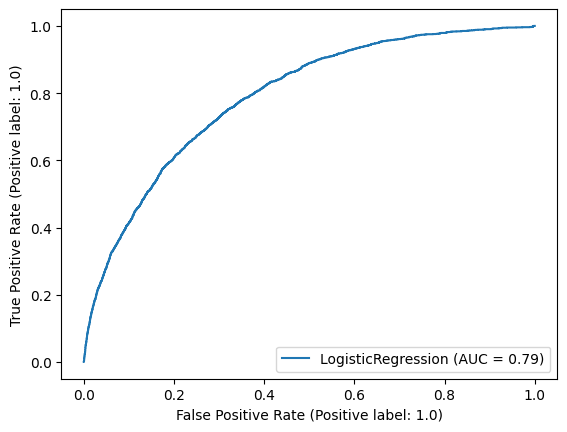

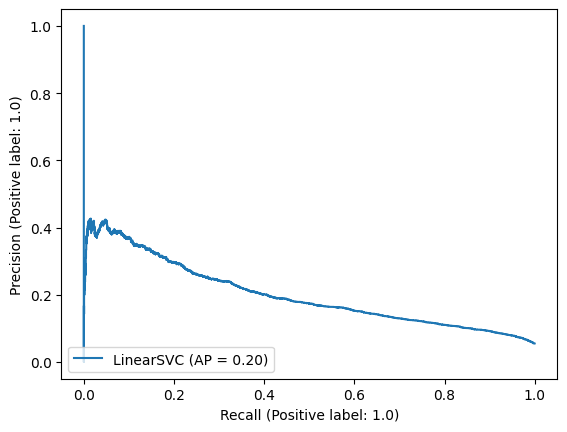

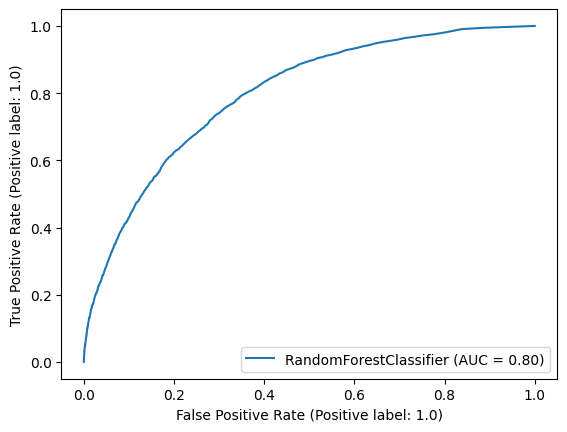

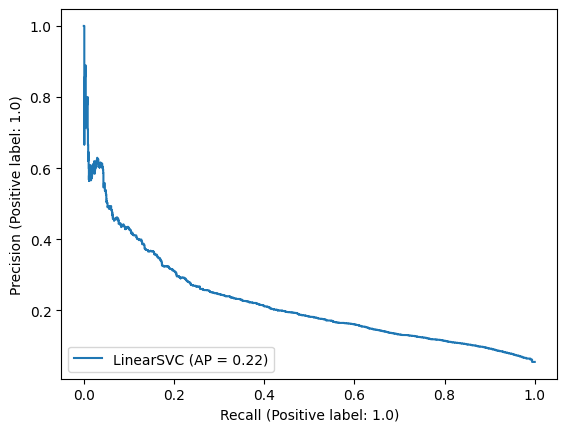

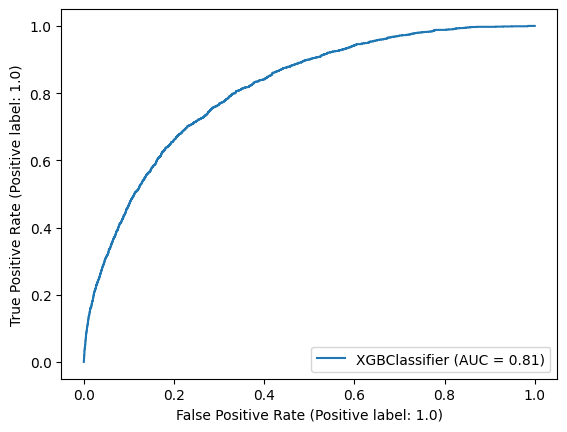

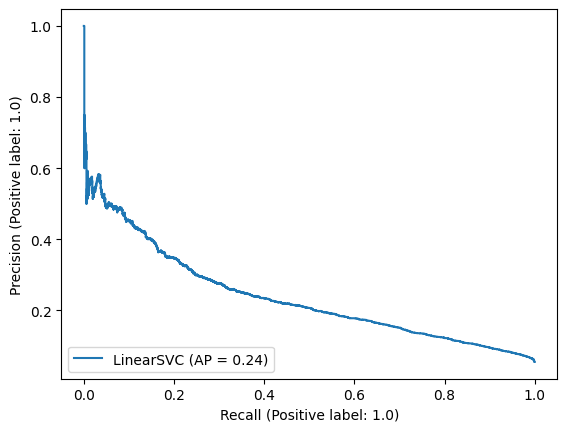

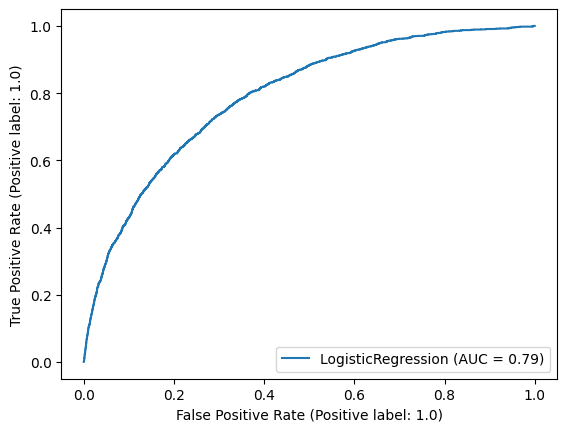

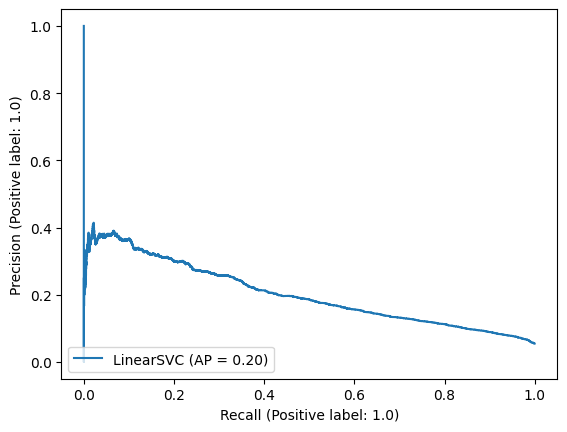

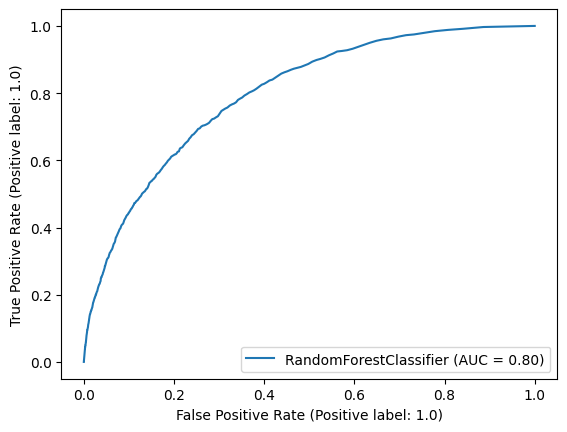

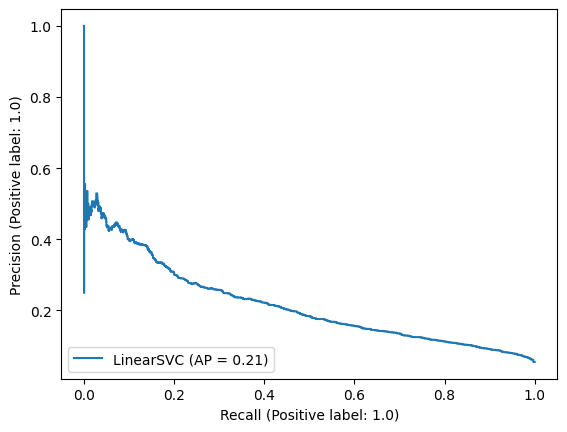

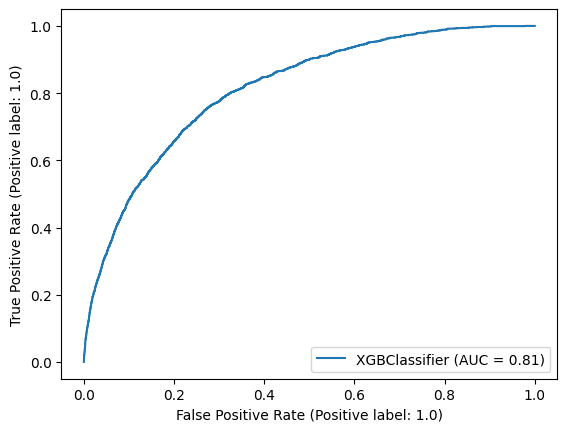

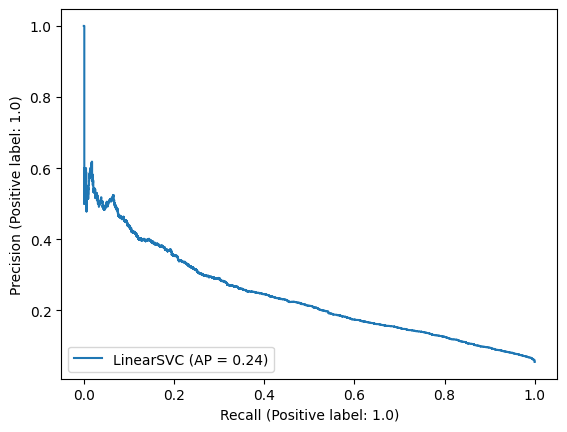

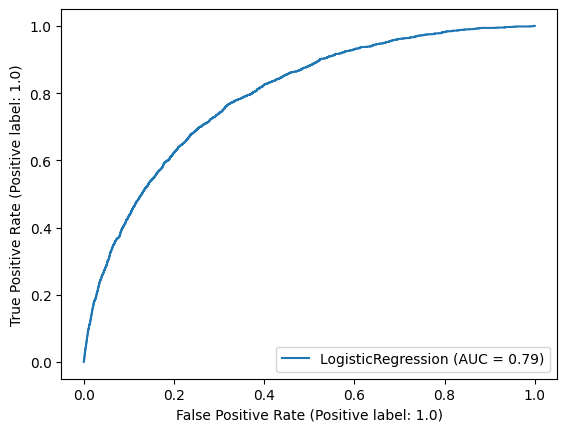

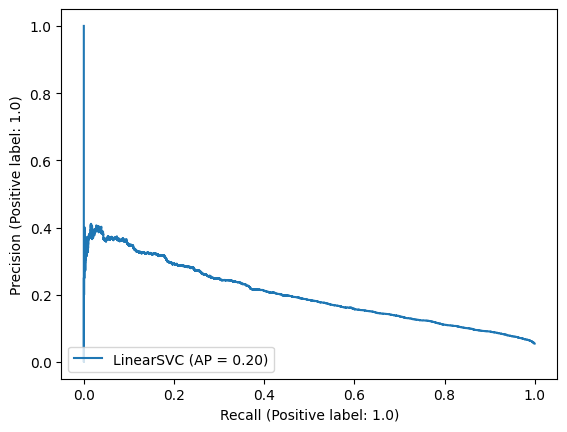

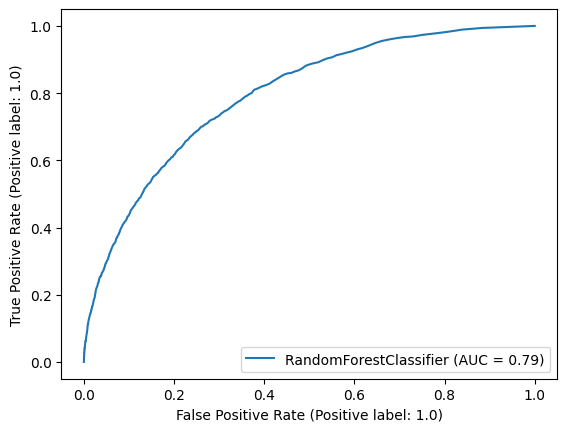

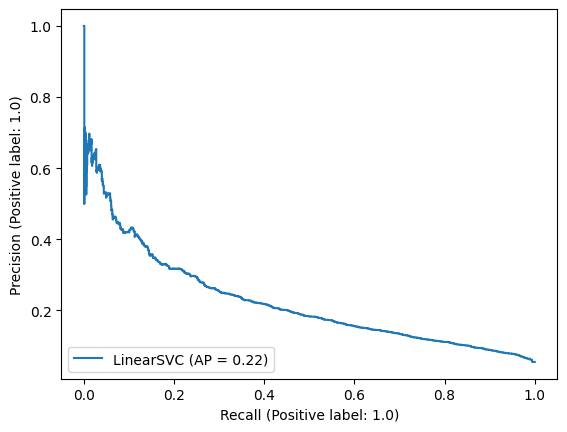

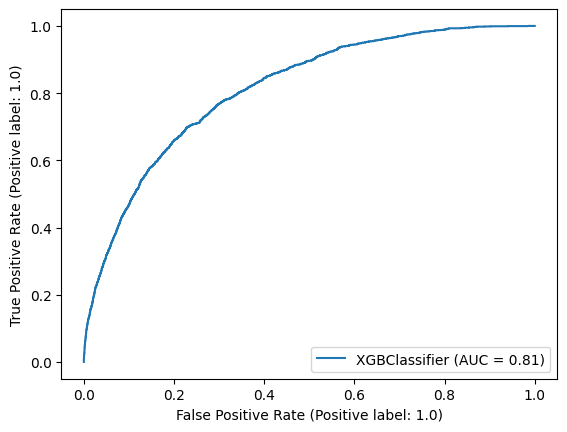

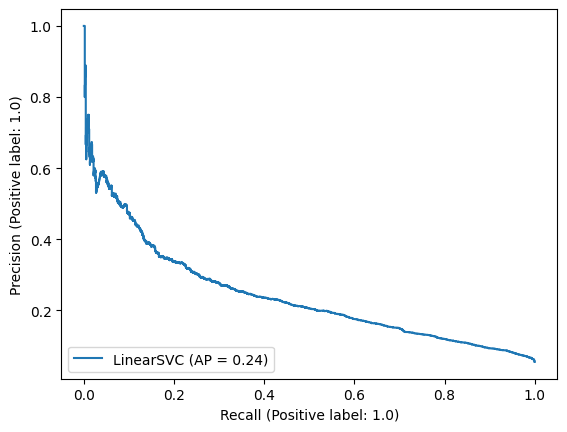

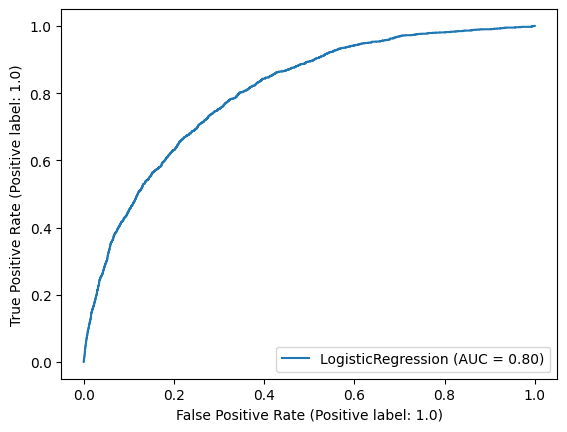

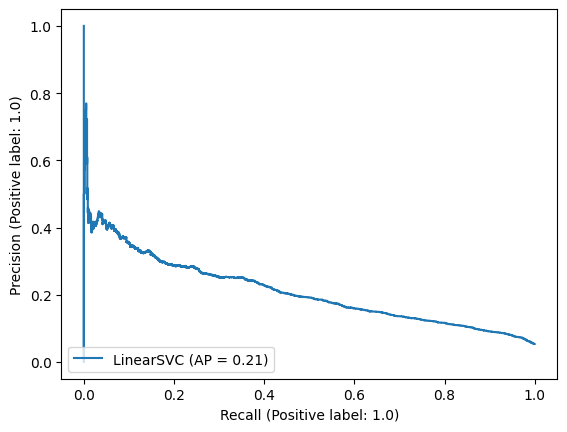

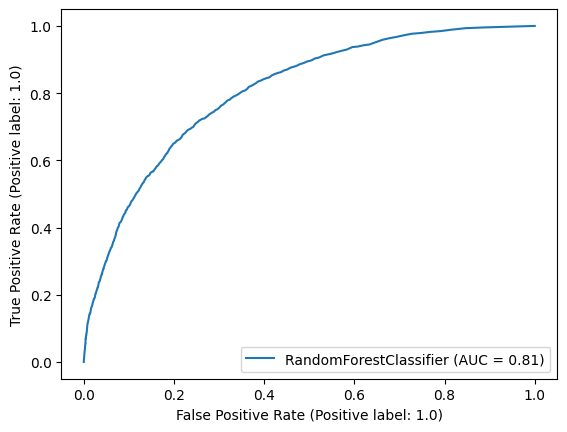

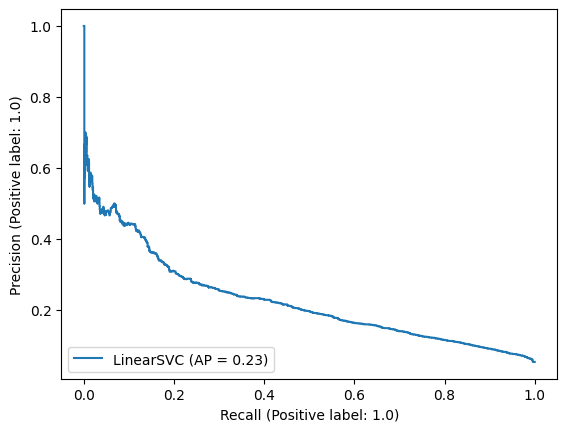

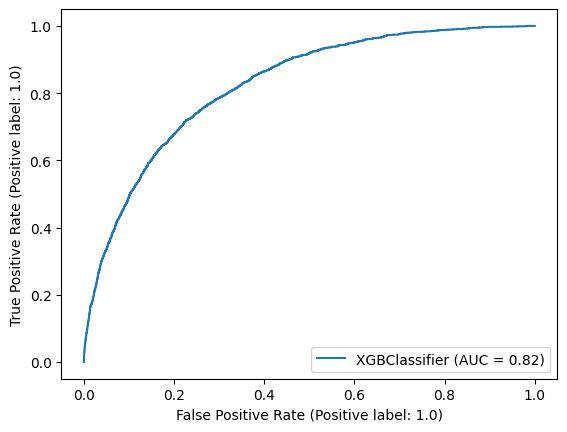

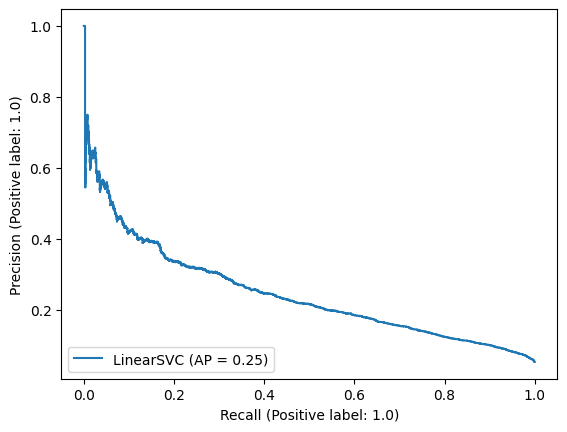

In [14]:
dataTRTR = pd.read_csv("Data/cleanedDataWithoutOutliers_SPO2Corrected_clean.csv", sep=",", encoding='cp1252')
trainTRTR, testTRTR = train_test_split(dataTRTR, train_size=0.7, test_size=0.3, random_state=42)
print('Logistic: ')
TRTRtesting(trainTRTR, testTRTR, 'Logistic')
print('Random Forest: ')
TRTRtesting(trainTRTR, testTRTR, 'rf')
print('XGBoost: ')
TRTRtesting(trainTRTR, testTRTR, 'XGBoost')

trainTRTR, testTRTR = train_test_split(dataTRTR, train_size=0.7, test_size=0.3, random_state=33)
print('Logistic: ')
TRTRtesting(trainTRTR, testTRTR, 'Logistic')
print('Random Forest: ')
TRTRtesting(trainTRTR, testTRTR, 'rf')
print('XGBoost: ')
TRTRtesting(trainTRTR, testTRTR, 'XGBoost')

trainTRTR, testTRTR = train_test_split(dataTRTR, train_size=0.7, test_size=0.3, random_state=2)
print('Logistic: ')
TRTRtesting(trainTRTR, testTRTR, 'Logistic')
print('Random Forest: ')
TRTRtesting(trainTRTR, testTRTR, 'rf')
print('XGBoost: ')
TRTRtesting(trainTRTR, testTRTR, 'XGBoost')

trainTRTR, testTRTR = train_test_split(dataTRTR, train_size=0.7, test_size=0.3, random_state=75)
print('Logistic: ')
TRTRtesting(trainTRTR, testTRTR, 'Logistic')
print('Random Forest: ')
TRTRtesting(trainTRTR, testTRTR, 'rf')
print('XGBoost: ')
TRTRtesting(trainTRTR, testTRTR, 'XGBoost')

trainTRTR, testTRTR = train_test_split(dataTRTR, train_size=0.7, test_size=0.3, random_state=300)
print('Logistic: ')
TRTRtesting(trainTRTR, testTRTR, 'Logistic')
print('Random Forest: ')
TRTRtesting(trainTRTR, testTRTR, 'rf')
print('XGBoost: ')
TRTRtesting(trainTRTR, testTRTR, 'XGBoost')

In [16]:
LogisticAUC=[0.8, 0.79, 0.79, 0.79, 0.8]
RandomForestAUC=[0.81, 0.8, 0.8, 0.79, 0.81]
XGBoostAUC=[0.82, 0.81, 0.81, 0.81, 0.82]



LogisticAUC=np.array(LogisticAUC)
RandomForestAUC=np.array(RandomForestAUC)
XGBoostAUC=np.array(XGBoostAUC)

print("Logistic AUC")
print('mean: ',LogisticAUC.mean())
print('std: ',LogisticAUC.std())
print("Random Forest AUC")
print('mean: ',RandomForestAUC.mean())
print('std: ',RandomForestAUC.std())
print("XGBoost AUC")
print('mean: ',XGBoostAUC.mean())
print('std: ',XGBoostAUC.std())


Logistic AUC
mean:  0.7939999999999999
std:  0.00489897948556636
Random Forest AUC
mean:  0.8019999999999999
std:  0.007483314773547889
XGBoost AUC
mean:  0.8140000000000001
std:  0.004898979485566306


#### TABDDPM 75000 5 RUN AUC PRC

Logistic: 


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Random Forest: 
XGBoost: 
[13:25:00] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

Logistic: 


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Random Forest: 
XGBoost: 
[13:26:36] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

Logistic: 


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Random Forest: 
XGBoost: 
[13:28:10] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

Logistic: 


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Random Forest: 


C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_plot\roc_curve.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


XGBoost: 
[13:29:41] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

Logistic: 


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Random Forest: 
XGBoost: 
[13:31:14] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.



(<sklearn.metrics._plot.roc_curve.RocCurveDisplay at 0x2c9598f00d0>,
 <sklearn.metrics._plot.precision_recall_curve.PrecisionRecallDisplay at 0x2c9595f4e50>)

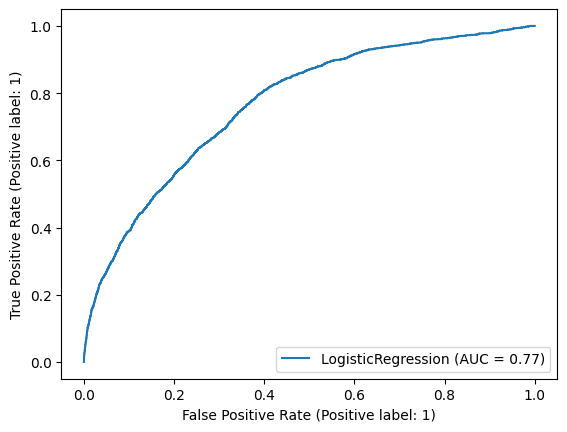

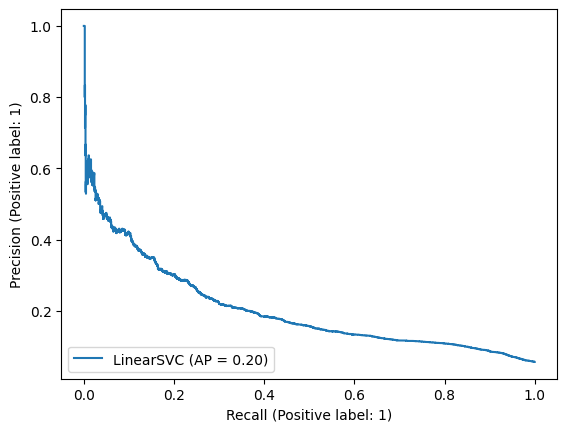

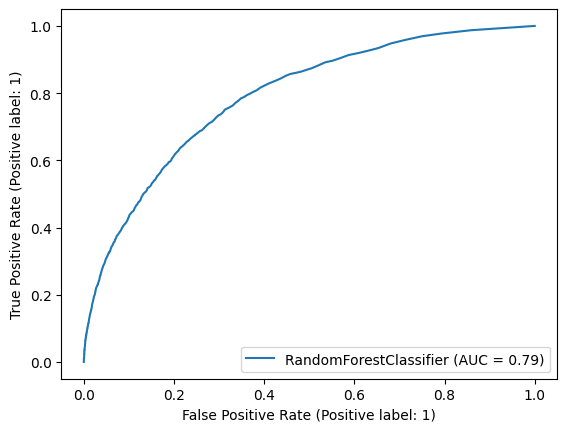

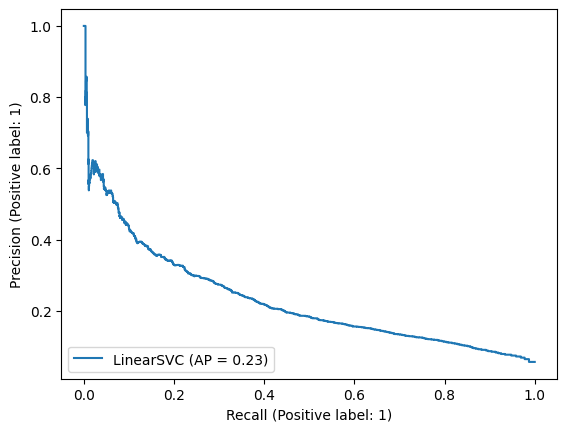

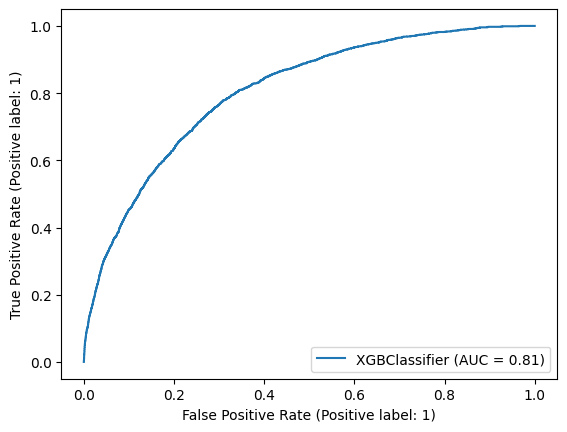

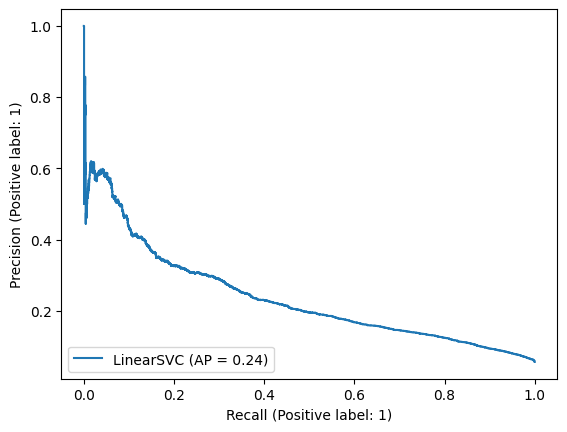

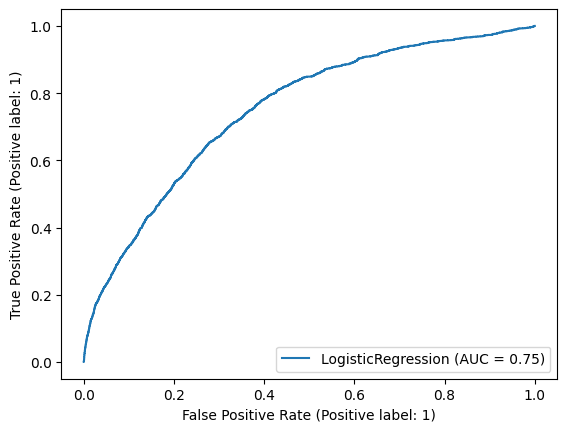

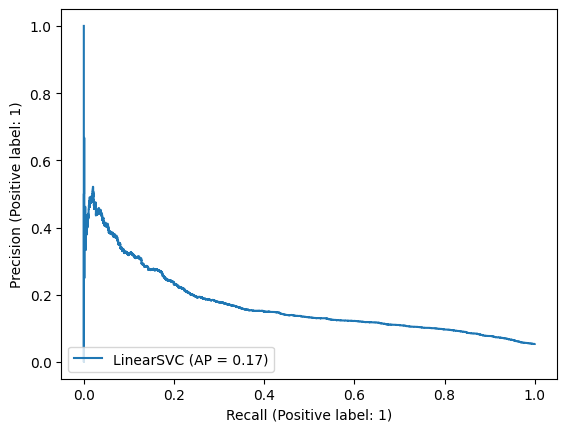

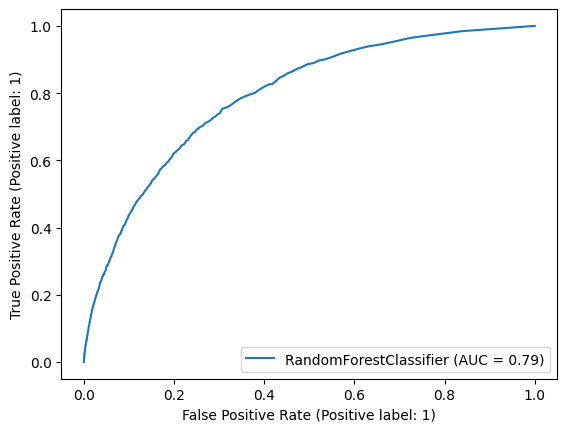

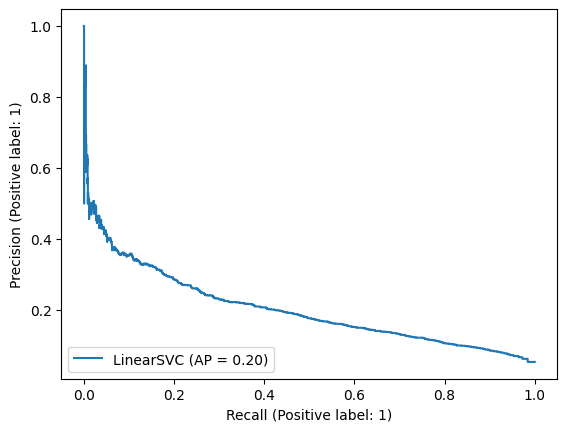

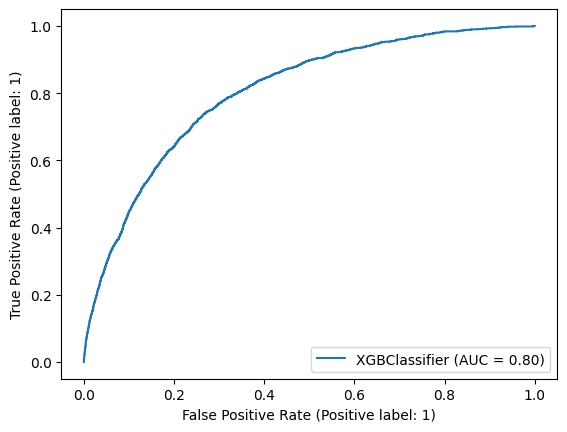

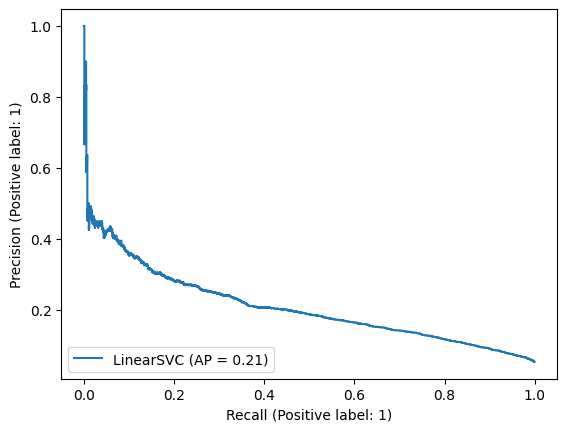

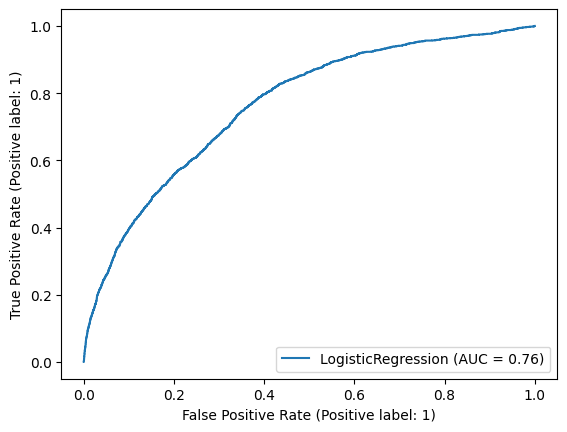

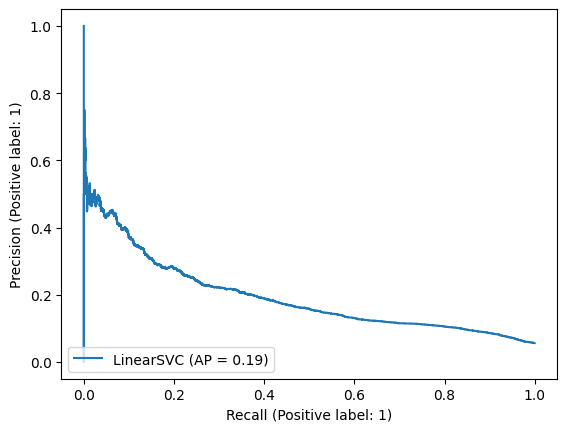

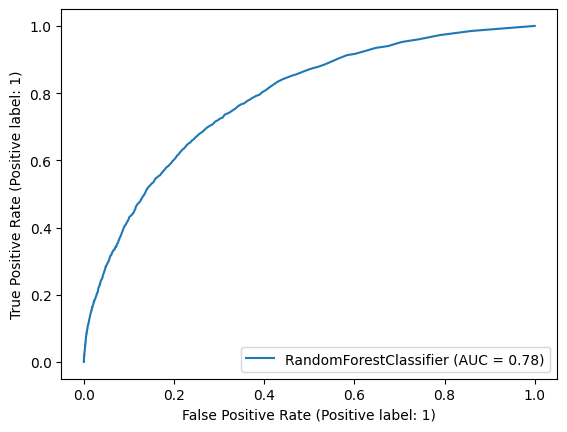

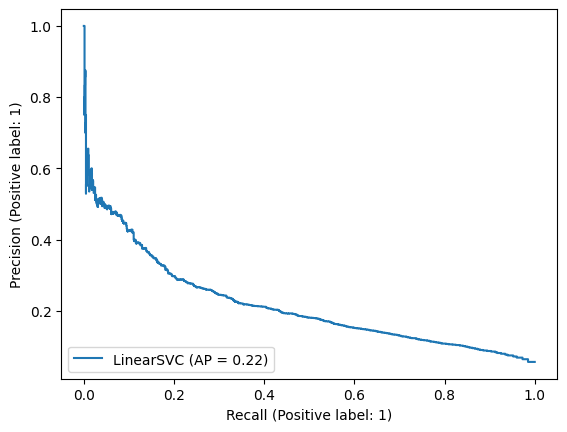

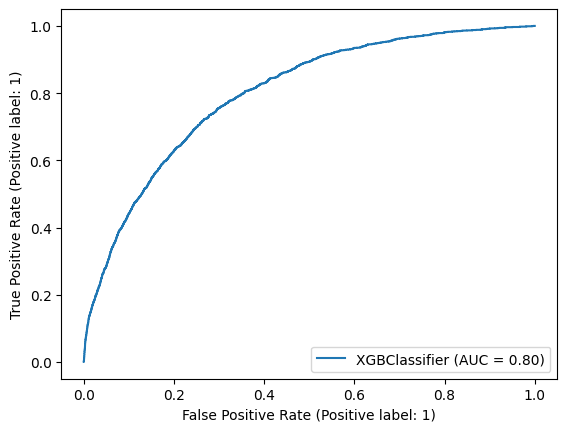

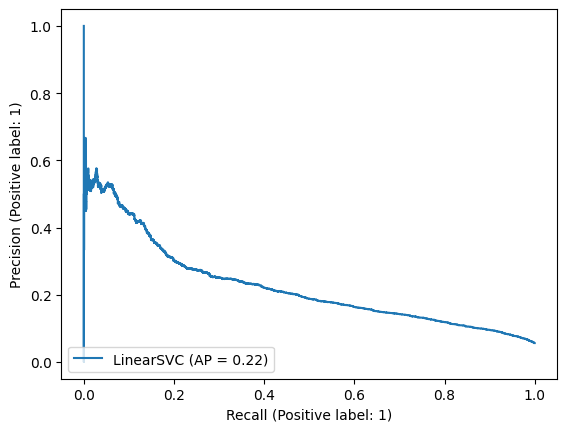

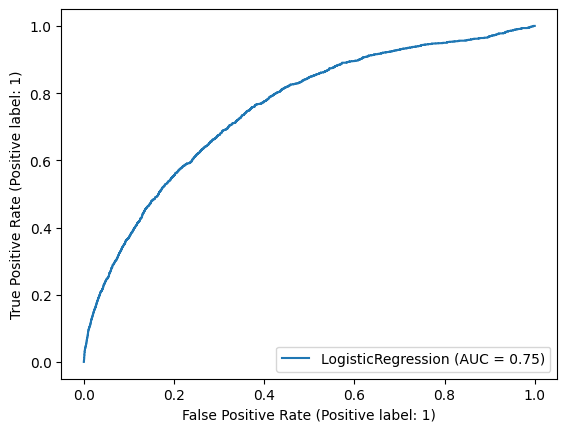

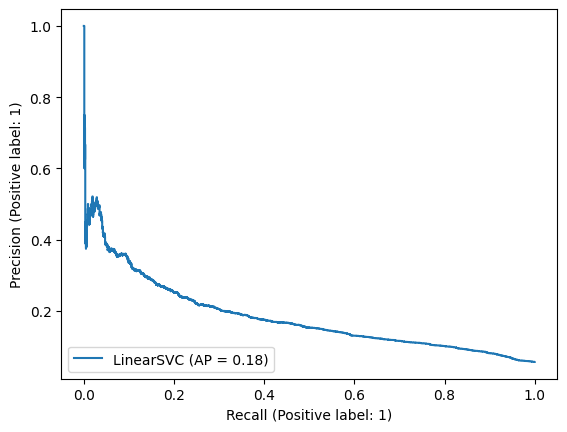

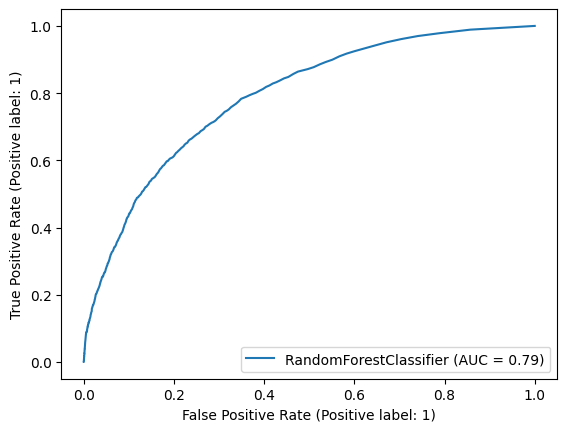

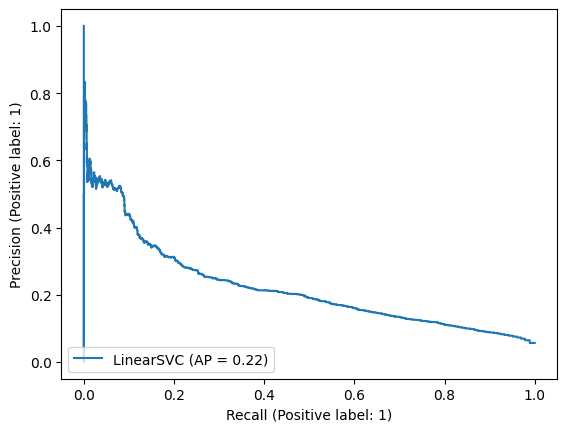

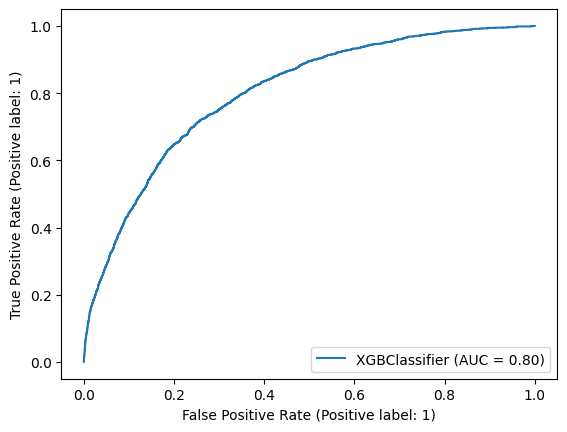

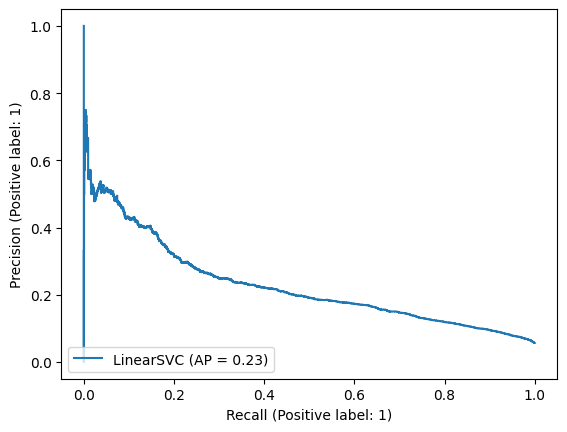

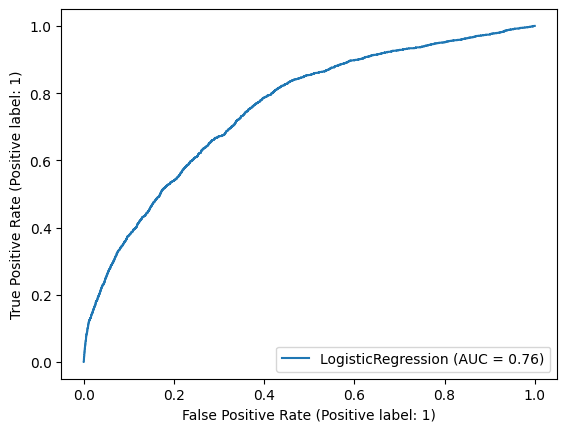

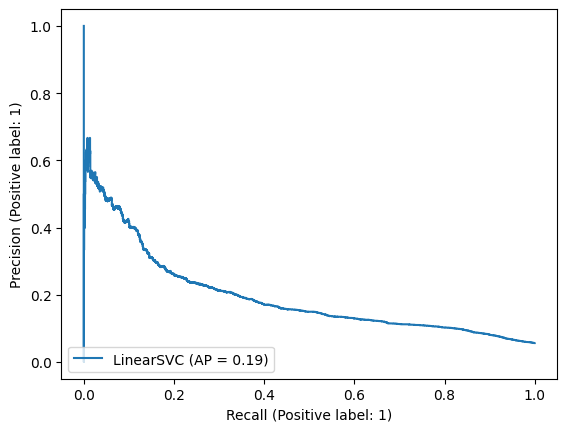

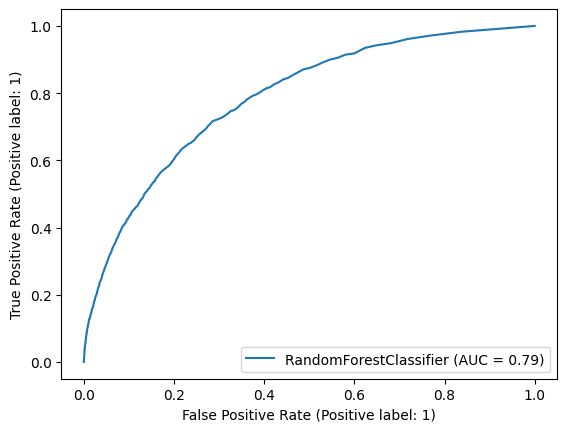

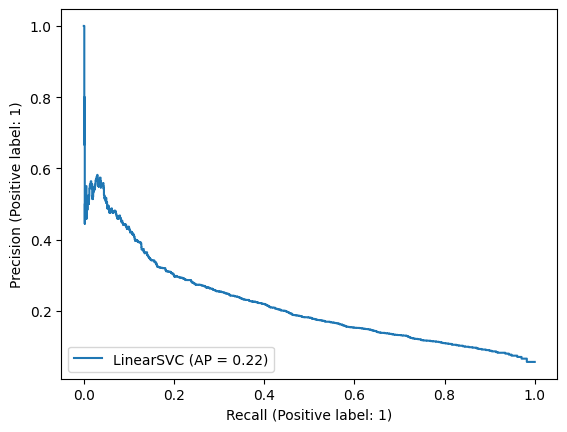

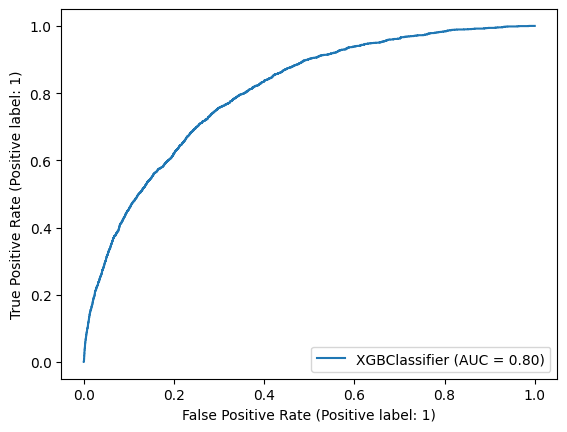

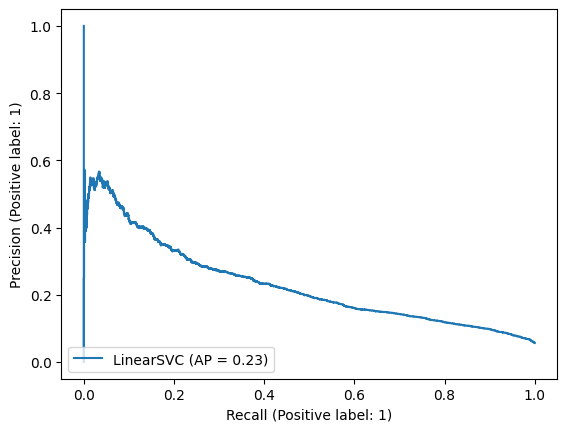

In [36]:
trainTabDDPM75000 = pd.read_csv("Results/TDDPM_75000_final_test_KS_kyuHwan_stability_AUCPRC_1/RealTDDPM_1.csv", sep=",", encoding='cp1252')
holdoutTabDDPM75000 = pd.read_csv("Results/TDDPM_75000_final_test_KS_kyuHwan_stability_AUCPRC_1/testTDDPM_1.csv", sep=",", encoding='cp1252')
synthTabDDPM75000 = pd.read_csv("Results/TDDPM_75000_final_test_KS_kyuHwan_stability_AUCPRC_1/SyntheticTDDPM_1.csv", sep=",", encoding='cp1252')
trainTabDDPM75000 = trainTabDDPM75000.drop(trainTabDDPM75000.columns[0],axis = 1)
holdoutTabDDPM75000 = holdoutTabDDPM75000.drop(holdoutTabDDPM75000.columns[0],axis = 1)
synthTabDDPM75000 = synthTabDDPM75000.drop(synthTabDDPM75000.columns[0],axis = 1)
print('Logistic: ')
TRTRtesting(synthTabDDPM75000, holdoutTabDDPM75000, 'Logistic')
print('Random Forest: ')
TRTRtesting(synthTabDDPM75000, holdoutTabDDPM75000, 'rf')
print('XGBoost: ')
TRTRtesting(synthTabDDPM75000, holdoutTabDDPM75000, 'XGBoost')

trainTabDDPM75000 = pd.read_csv("Results/TDDPM_75000_final_test_KS_kyuHwan_stability_AUCPRC_2/RealTDDPM_1.csv", sep=",", encoding='cp1252')
holdoutTabDDPM75000 = pd.read_csv("Results/TDDPM_75000_final_test_KS_kyuHwan_stability_AUCPRC_2/testTDDPM_1.csv", sep=",", encoding='cp1252')
synthTabDDPM75000 = pd.read_csv("Results/TDDPM_75000_final_test_KS_kyuHwan_stability_AUCPRC_2/SyntheticTDDPM_1.csv", sep=",", encoding='cp1252')
trainTabDDPM75000 = trainTabDDPM75000.drop(trainTabDDPM75000.columns[0],axis = 1)
holdoutTabDDPM75000 = holdoutTabDDPM75000.drop(holdoutTabDDPM75000.columns[0],axis = 1)
synthTabDDPM75000 = synthTabDDPM75000.drop(synthTabDDPM75000.columns[0],axis = 1)
print('Logistic: ')
TRTRtesting(synthTabDDPM75000, holdoutTabDDPM75000, 'Logistic')
print('Random Forest: ')
TRTRtesting(synthTabDDPM75000, holdoutTabDDPM75000, 'rf')
print('XGBoost: ')
TRTRtesting(synthTabDDPM75000, holdoutTabDDPM75000, 'XGBoost')

trainTabDDPM75000 = pd.read_csv("Results/TDDPM_75000_final_test_KS_kyuHwan_stability_AUCPRC_3/RealTDDPM_1.csv", sep=",", encoding='cp1252')
holdoutTabDDPM75000 = pd.read_csv("Results/TDDPM_75000_final_test_KS_kyuHwan_stability_AUCPRC_3/testTDDPM_1.csv", sep=",", encoding='cp1252')
synthTabDDPM75000 = pd.read_csv("Results/TDDPM_75000_final_test_KS_kyuHwan_stability_AUCPRC_3/SyntheticTDDPM_1.csv", sep=",", encoding='cp1252')
trainTabDDPM75000 = trainTabDDPM75000.drop(trainTabDDPM75000.columns[0],axis = 1)
holdoutTabDDPM75000 = holdoutTabDDPM75000.drop(holdoutTabDDPM75000.columns[0],axis = 1)
synthTabDDPM75000 = synthTabDDPM75000.drop(synthTabDDPM75000.columns[0],axis = 1)
print('Logistic: ')
TRTRtesting(synthTabDDPM75000, holdoutTabDDPM75000, 'Logistic')
print('Random Forest: ')
TRTRtesting(synthTabDDPM75000, holdoutTabDDPM75000, 'rf')
print('XGBoost: ')
TRTRtesting(synthTabDDPM75000, holdoutTabDDPM75000, 'XGBoost')

trainTabDDPM75000 = pd.read_csv("Results/TDDPM_75000_final_test_KS_kyuHwan_stability_AUCPRC_4/RealTDDPM_1.csv", sep=",", encoding='cp1252')
holdoutTabDDPM75000 = pd.read_csv("Results/TDDPM_75000_final_test_KS_kyuHwan_stability_AUCPRC_4/testTDDPM_1.csv", sep=",", encoding='cp1252')
synthTabDDPM75000 = pd.read_csv("Results/TDDPM_75000_final_test_KS_kyuHwan_stability_AUCPRC_4/SyntheticTDDPM_1.csv", sep=",", encoding='cp1252')
trainTabDDPM75000 = trainTabDDPM75000.drop(trainTabDDPM75000.columns[0],axis = 1)
holdoutTabDDPM75000 = holdoutTabDDPM75000.drop(holdoutTabDDPM75000.columns[0],axis = 1)
synthTabDDPM75000 = synthTabDDPM75000.drop(synthTabDDPM75000.columns[0],axis = 1)
print('Logistic: ')
TRTRtesting(synthTabDDPM75000, holdoutTabDDPM75000, 'Logistic')
print('Random Forest: ')
TRTRtesting(synthTabDDPM75000, holdoutTabDDPM75000, 'rf')
print('XGBoost: ')
TRTRtesting(synthTabDDPM75000, holdoutTabDDPM75000, 'XGBoost')

trainTabDDPM75000 = pd.read_csv("Results/TDDPM_75000_final_test_KS_kyuHwan_stability_AUCPRC_5/RealTDDPM_1.csv", sep=",", encoding='cp1252')
holdoutTabDDPM75000 = pd.read_csv("Results/TDDPM_75000_final_test_KS_kyuHwan_stability_AUCPRC_5/testTDDPM_1.csv", sep=",", encoding='cp1252')
synthTabDDPM75000 = pd.read_csv("Results/TDDPM_75000_final_test_KS_kyuHwan_stability_AUCPRC_5/SyntheticTDDPM_1.csv", sep=",", encoding='cp1252')
trainTabDDPM75000 = trainTabDDPM75000.drop(trainTabDDPM75000.columns[0],axis = 1)
holdoutTabDDPM75000 = holdoutTabDDPM75000.drop(holdoutTabDDPM75000.columns[0],axis = 1)
synthTabDDPM75000 = synthTabDDPM75000.drop(synthTabDDPM75000.columns[0],axis = 1)
print('Logistic: ')
TRTRtesting(synthTabDDPM75000, holdoutTabDDPM75000, 'Logistic')
print('Random Forest: ')
TRTRtesting(synthTabDDPM75000, holdoutTabDDPM75000, 'rf')
print('XGBoost: ')
TRTRtesting(synthTabDDPM75000, holdoutTabDDPM75000, 'XGBoost')

In [41]:
LogisticAUC=[0.77,0.75,0.76,0.75,0.76]
RandomForestAUC=[0.79,0.79,0.78,0.79,0.79]
XGBoostAUC=[0.81,0.8,0.8,0.8,0.8]



LogisticAUC=np.array(LogisticAUC)
RandomForestAUC=np.array(RandomForestAUC)
XGBoostAUC=np.array(XGBoostAUC)

print("Logistic AUC")
print('mean: ',LogisticAUC.mean())
print('std: ',LogisticAUC.std())
print("Random Forest AUC")
print('mean: ',RandomForestAUC.mean())
print('std: ',RandomForestAUC.std())
print("XGBoost AUC")
print('mean: ',XGBoostAUC.mean())
print('std: ',XGBoostAUC.std())


Logistic AUC
mean:  0.758
std:  0.007483314773547889
Random Forest AUC
mean:  0.788
std:  0.0040000000000000036
XGBoost AUC
mean:  0.8019999999999999
std:  0.004000000000000004


#### TABDDPM 50000 5 RUN AUC PRC

Logistic: 


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Random Forest: 
XGBoost: 
[13:47:29] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

Logistic: 


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Random Forest: 
XGBoost: 
[13:48:53] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

Logistic: 


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Random Forest: 
XGBoost: 
[13:50:17] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

Logistic: 


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Random Forest: 


C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_plot\roc_curve.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_plot\precision_recall_curve.py:162: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


XGBoost: 
[13:51:41] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.



C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_plot\roc_curve.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_plot\precision_recall_curve.py:162: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic: 


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_plot\roc_curve.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_plot\precision_recall_curve.py:162: RuntimeWarning

Random Forest: 


C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_plot\roc_curve.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_plot\precision_recall_curve.py:162: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


XGBoost: 
[13:53:08] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.



C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_plot\roc_curve.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_plot\precision_recall_curve.py:162: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


(<sklearn.metrics._plot.roc_curve.RocCurveDisplay at 0x1df2632d700>,
 <sklearn.metrics._plot.precision_recall_curve.PrecisionRecallDisplay at 0x1df00c35d60>)

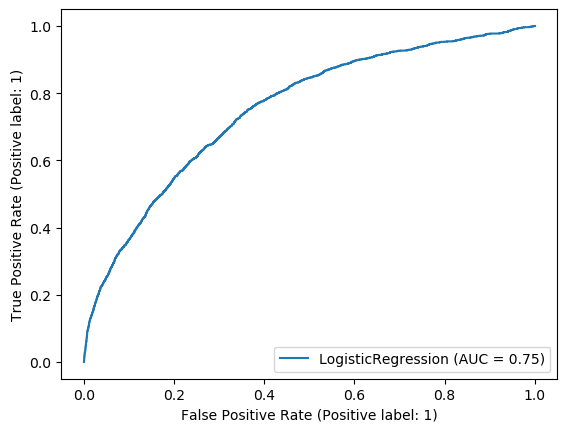

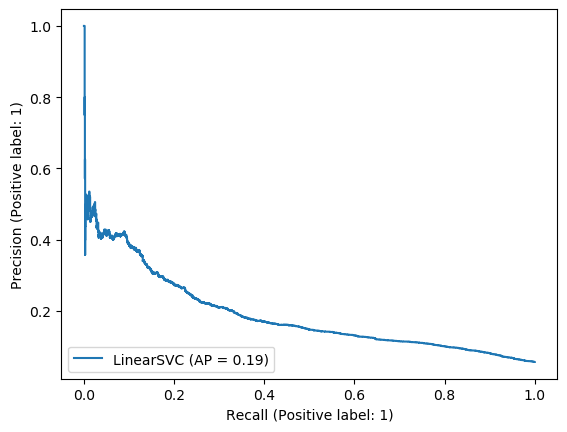

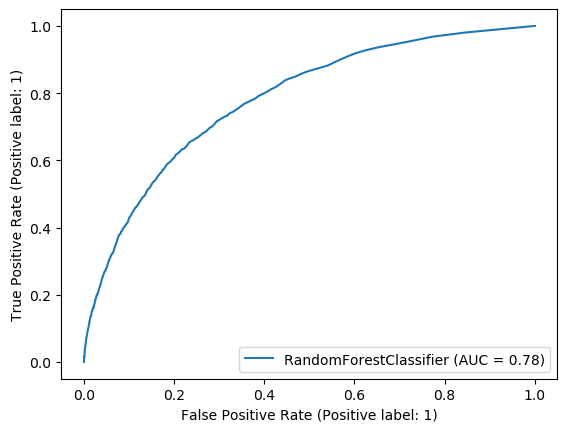

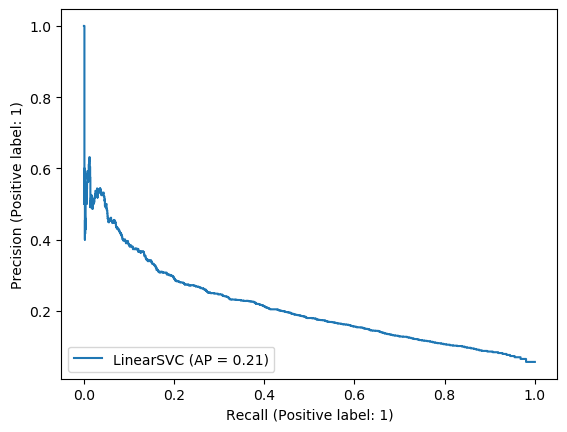

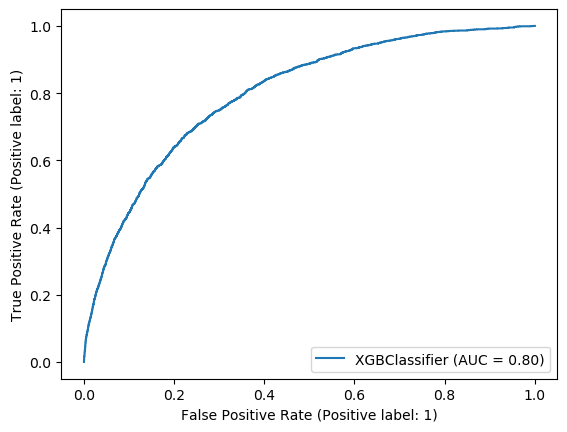

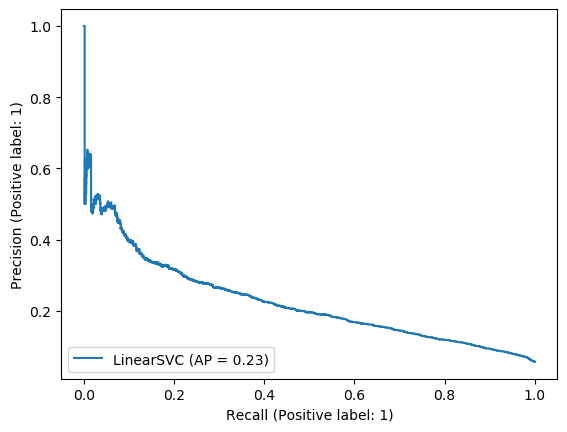

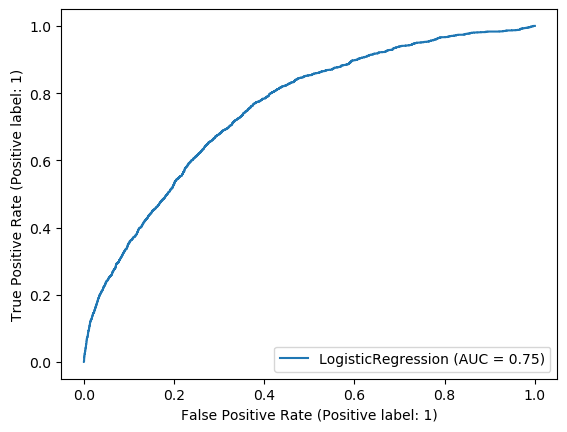

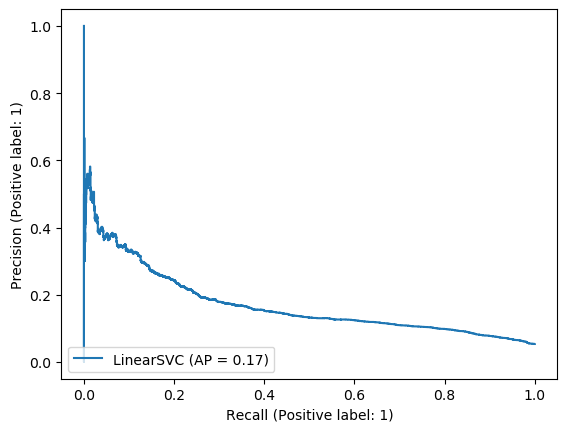

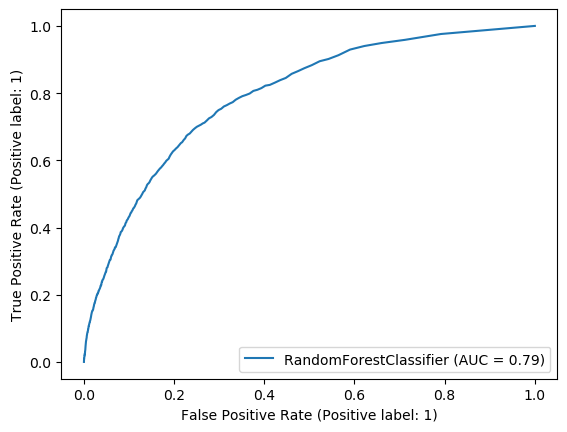

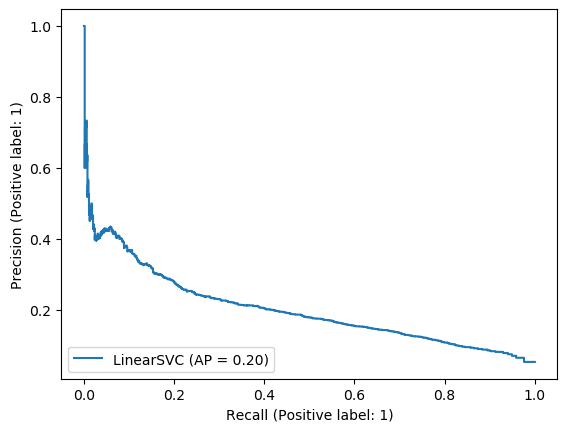

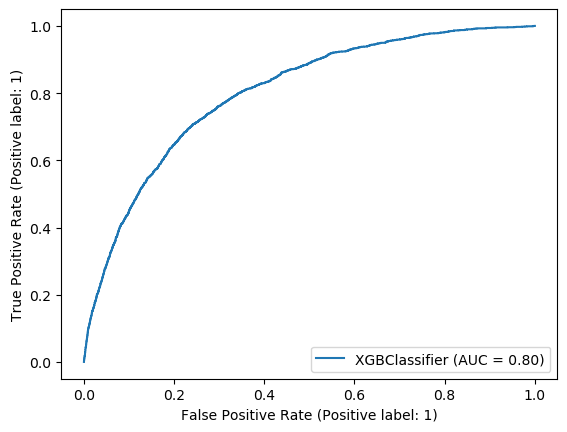

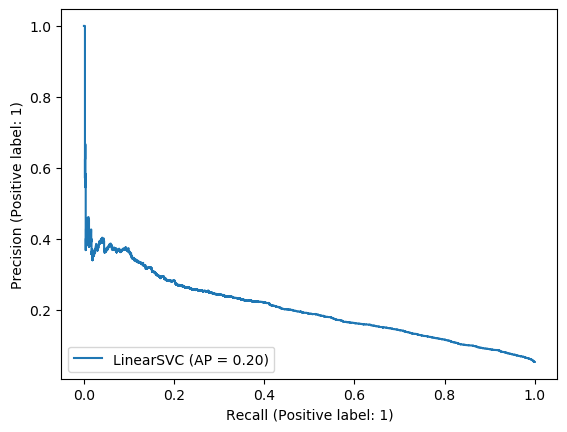

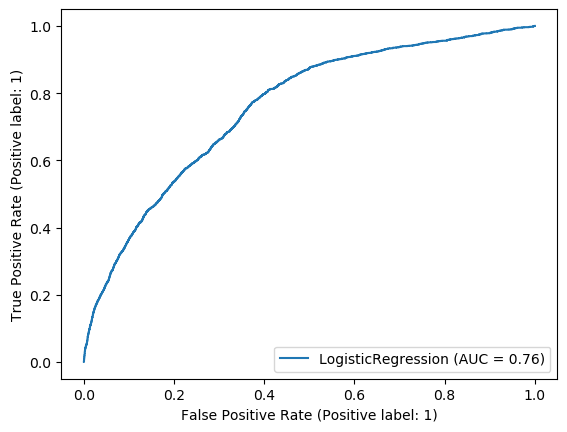

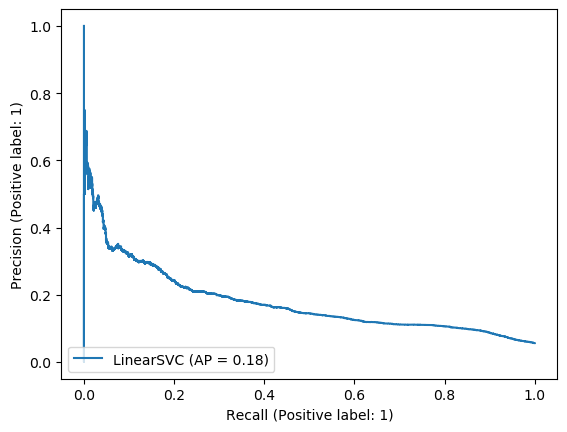

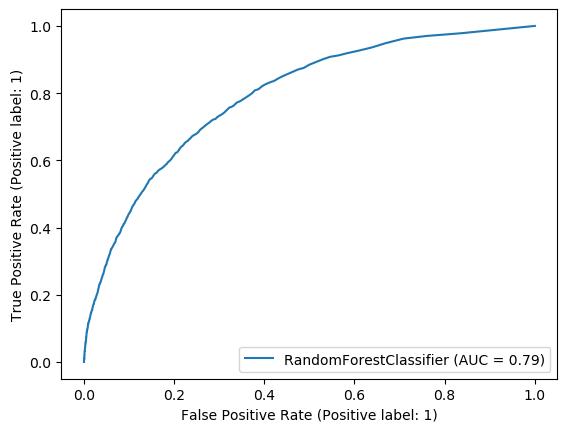

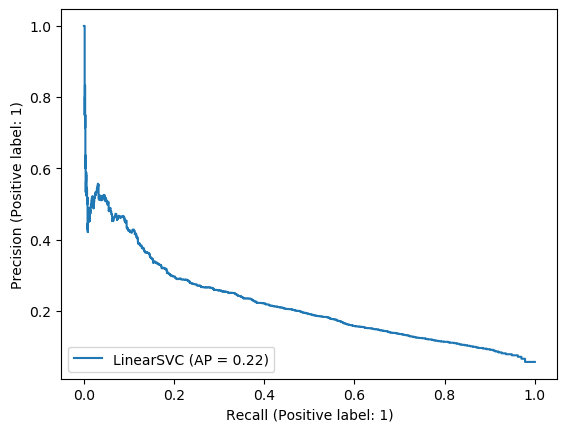

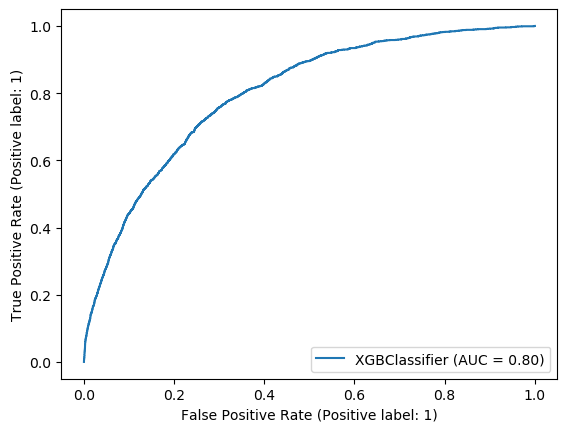

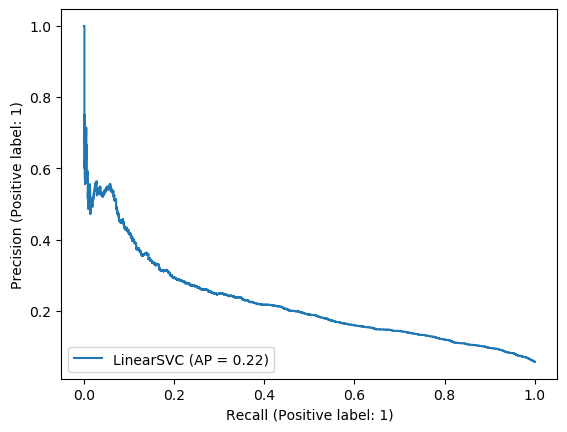

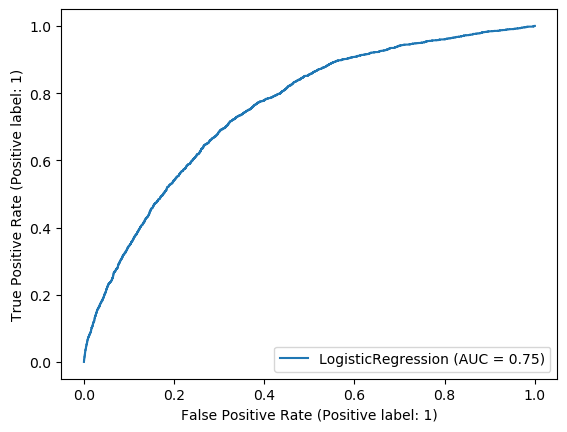

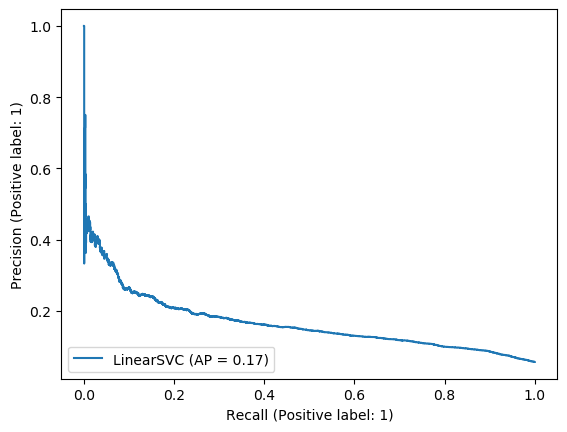

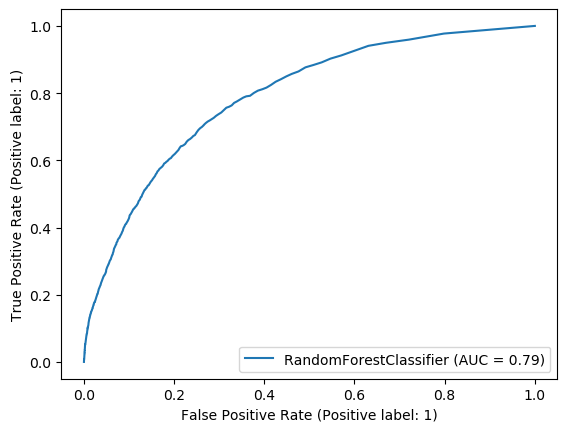

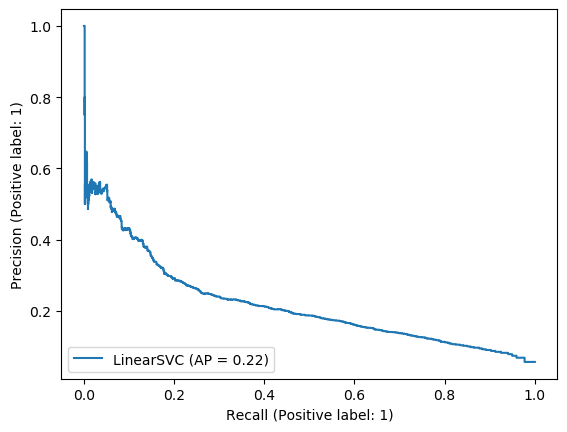

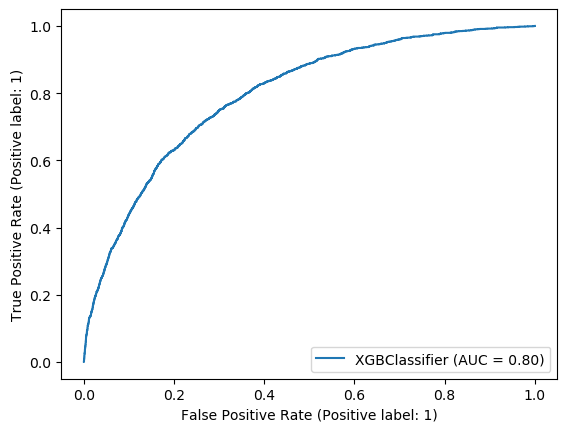

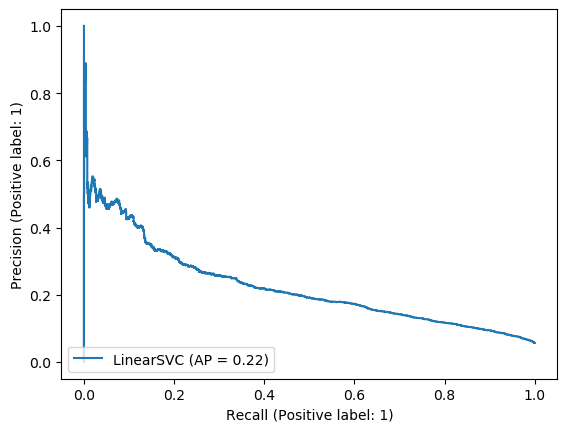

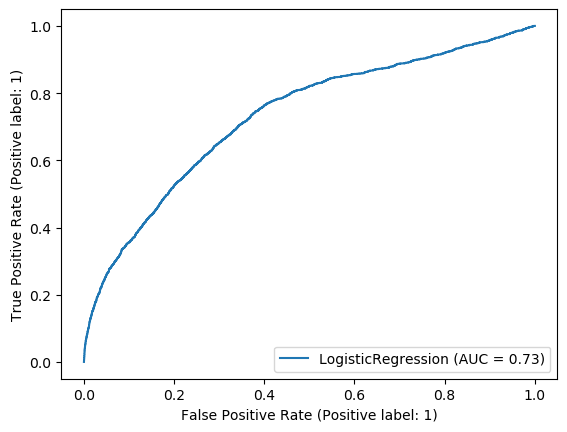

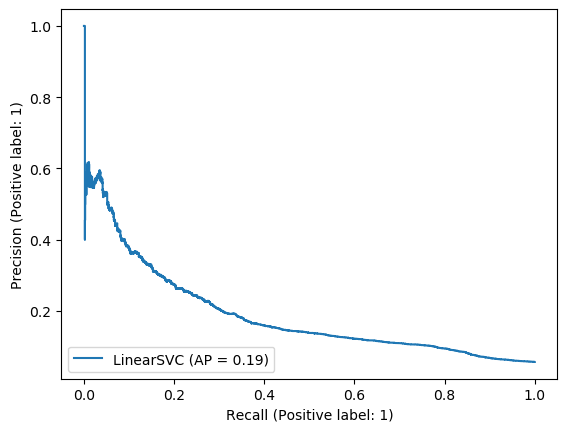

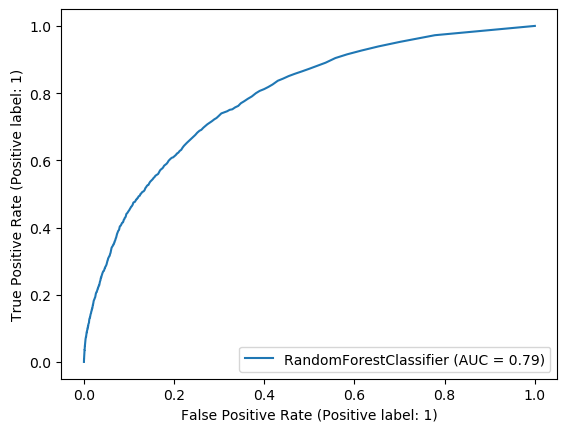

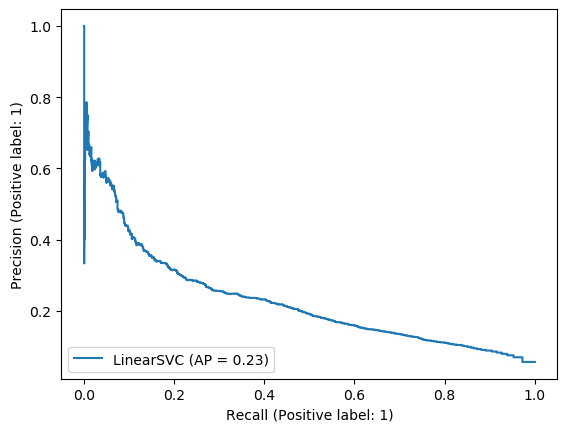

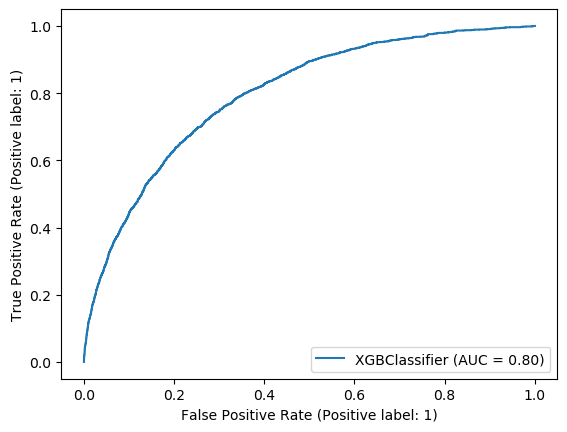

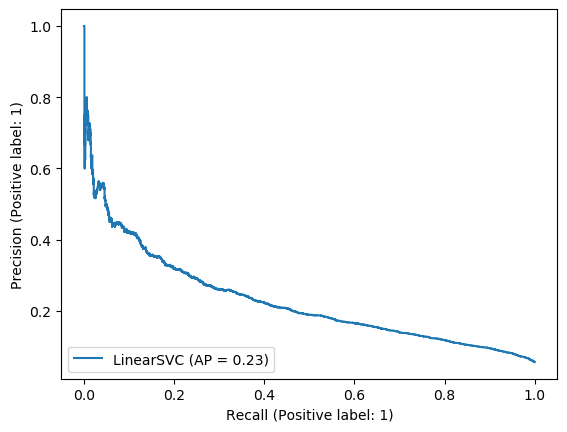

In [8]:
trainTabDDPM50000 = pd.read_csv("Results/TDDPM_50000_steps_for_AUCPRC_0.7_0.002_1ndRun/RealTDDPM_1.csv", sep=",", encoding='cp1252')
holdoutTabDDPM50000 = pd.read_csv("Results/TDDPM_50000_steps_for_AUCPRC_0.7_0.002_1ndRun/testTDDPM_1.csv", sep=",", encoding='cp1252')
synthTabDDPM50000 = pd.read_csv("Results/TDDPM_50000_steps_for_AUCPRC_0.7_0.002_1ndRun/SyntheticTDDPM_1.csv", sep=",", encoding='cp1252')
trainTabDDPM50000 = trainTabDDPM50000.drop(trainTabDDPM50000.columns[0],axis = 1)
holdoutTabDDPM50000 = holdoutTabDDPM50000.drop(holdoutTabDDPM50000.columns[0],axis = 1)
synthTabDDPM50000 = synthTabDDPM50000.drop(synthTabDDPM50000.columns[0],axis = 1)
print('Logistic: ')
TRTRtesting(synthTabDDPM50000, holdoutTabDDPM50000, 'Logistic')
print('Random Forest: ')
TRTRtesting(synthTabDDPM50000, holdoutTabDDPM50000, 'rf')
print('XGBoost: ')
TRTRtesting(synthTabDDPM50000, holdoutTabDDPM50000, 'XGBoost')

trainTabDDPM50000 = pd.read_csv("Results/TDDPM_50000_steps_for_AUCPRC_0.7_0.002_2ndRun/RealTDDPM_1.csv", sep=",", encoding='cp1252')
holdoutTabDDPM50000 = pd.read_csv("Results/TDDPM_50000_steps_for_AUCPRC_0.7_0.002_2ndRun/testTDDPM_1.csv", sep=",", encoding='cp1252')
synthTabDDPM50000 = pd.read_csv("Results/TDDPM_50000_steps_for_AUCPRC_0.7_0.002_2ndRun/SyntheticTDDPM_1.csv", sep=",", encoding='cp1252')
trainTabDDPM50000 = trainTabDDPM50000.drop(trainTabDDPM50000.columns[0],axis = 1)
holdoutTabDDPM50000 = holdoutTabDDPM50000.drop(holdoutTabDDPM50000.columns[0],axis = 1)
synthTabDDPM50000 = synthTabDDPM50000.drop(synthTabDDPM50000.columns[0],axis = 1)
print('Logistic: ')
TRTRtesting(synthTabDDPM50000, holdoutTabDDPM50000, 'Logistic')
print('Random Forest: ')
TRTRtesting(synthTabDDPM50000, holdoutTabDDPM50000, 'rf')
print('XGBoost: ')
TRTRtesting(synthTabDDPM50000, holdoutTabDDPM50000, 'XGBoost')

trainTabDDPM50000 = pd.read_csv("Results/TDDPM_50000_steps_for_AUCPRC_0.7_0.002_3ndRun/RealTDDPM_1.csv", sep=",", encoding='cp1252')
holdoutTabDDPM50000 = pd.read_csv("Results/TDDPM_50000_steps_for_AUCPRC_0.7_0.002_3ndRun/testTDDPM_1.csv", sep=",", encoding='cp1252')
synthTabDDPM50000 = pd.read_csv("Results/TDDPM_50000_steps_for_AUCPRC_0.7_0.002_3ndRun/SyntheticTDDPM_1.csv", sep=",", encoding='cp1252')
trainTabDDPM50000 = trainTabDDPM50000.drop(trainTabDDPM50000.columns[0],axis = 1)
holdoutTabDDPM50000 = holdoutTabDDPM50000.drop(holdoutTabDDPM50000.columns[0],axis = 1)
synthTabDDPM50000 = synthTabDDPM50000.drop(synthTabDDPM50000.columns[0],axis = 1)
print('Logistic: ')
TRTRtesting(synthTabDDPM50000, holdoutTabDDPM50000, 'Logistic')
print('Random Forest: ')
TRTRtesting(synthTabDDPM50000, holdoutTabDDPM50000, 'rf')
print('XGBoost: ')
TRTRtesting(synthTabDDPM50000, holdoutTabDDPM50000, 'XGBoost')

trainTabDDPM50000 = pd.read_csv("Results/TDDPM_50000_steps_for_AUCPRC_0.7_0.002_4ndRun/RealTDDPM_1.csv", sep=",", encoding='cp1252')
holdoutTabDDPM50000 = pd.read_csv("Results/TDDPM_50000_steps_for_AUCPRC_0.7_0.002_4ndRun/testTDDPM_1.csv", sep=",", encoding='cp1252')
synthTabDDPM50000 = pd.read_csv("Results/TDDPM_50000_steps_for_AUCPRC_0.7_0.002_4ndRun/SyntheticTDDPM_1.csv", sep=",", encoding='cp1252')
trainTabDDPM50000 = trainTabDDPM50000.drop(trainTabDDPM50000.columns[0],axis = 1)
holdoutTabDDPM50000 = holdoutTabDDPM50000.drop(holdoutTabDDPM50000.columns[0],axis = 1)
synthTabDDPM50000 = synthTabDDPM50000.drop(synthTabDDPM50000.columns[0],axis = 1)
print('Logistic: ')
TRTRtesting(synthTabDDPM50000, holdoutTabDDPM50000, 'Logistic')
print('Random Forest: ')
TRTRtesting(synthTabDDPM50000, holdoutTabDDPM50000, 'rf')
print('XGBoost: ')
TRTRtesting(synthTabDDPM50000, holdoutTabDDPM50000, 'XGBoost')

trainTabDDPM50000 = pd.read_csv("Results/TDDPM_50000_steps_for_AUCPRC_0.7_0.002_5ndRun/RealTDDPM_1.csv", sep=",", encoding='cp1252')
holdoutTabDDPM50000 = pd.read_csv("Results/TDDPM_50000_steps_for_AUCPRC_0.7_0.002_5ndRun/testTDDPM_1.csv", sep=",", encoding='cp1252')
synthTabDDPM50000 = pd.read_csv("Results/TDDPM_50000_steps_for_AUCPRC_0.7_0.002_5ndRun/SyntheticTDDPM_1.csv", sep=",", encoding='cp1252')
trainTabDDPM50000 = trainTabDDPM50000.drop(trainTabDDPM50000.columns[0],axis = 1)
holdoutTabDDPM50000 = holdoutTabDDPM50000.drop(holdoutTabDDPM50000.columns[0],axis = 1)
synthTabDDPM50000 = synthTabDDPM50000.drop(synthTabDDPM50000.columns[0],axis = 1)
print('Logistic: ')
TRTRtesting(synthTabDDPM50000, holdoutTabDDPM50000, 'Logistic')
print('Random Forest: ')
TRTRtesting(synthTabDDPM50000, holdoutTabDDPM50000, 'rf')
print('XGBoost: ')
TRTRtesting(synthTabDDPM50000, holdoutTabDDPM50000, 'XGBoost')

#### TABDDPM 25000 5 RUN AUC PRC

Logistic: 


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Random Forest: 
XGBoost: 
[13:32:42] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

Logistic: 


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Random Forest: 
XGBoost: 
[13:34:10] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

Logistic: 


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Random Forest: 
XGBoost: 
[13:35:39] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

Logistic: 


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Random Forest: 


C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_plot\roc_curve.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


XGBoost: 
[13:37:11] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

Logistic: 


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Random Forest: 
XGBoost: 
[13:38:40] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.



(<sklearn.metrics._plot.roc_curve.RocCurveDisplay at 0x2c956d02c10>,
 <sklearn.metrics._plot.precision_recall_curve.PrecisionRecallDisplay at 0x2c95326ba30>)

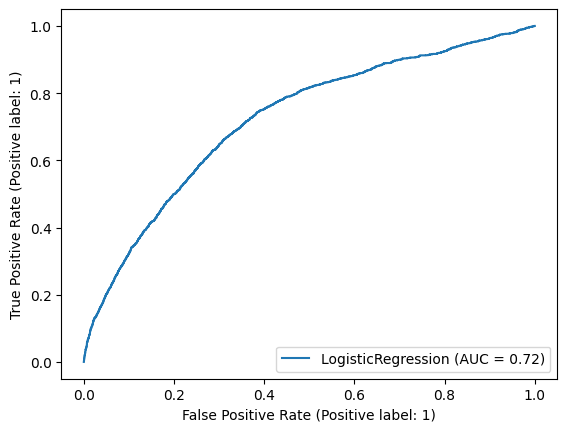

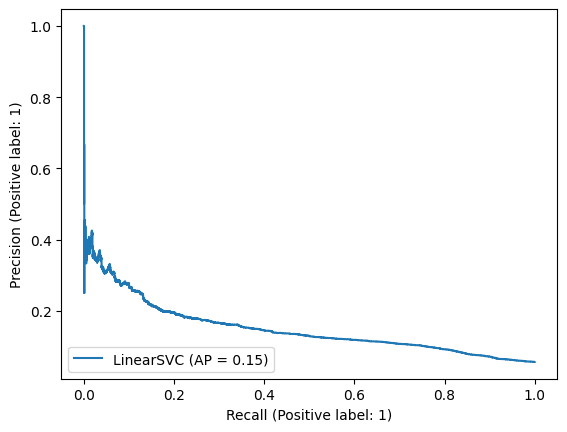

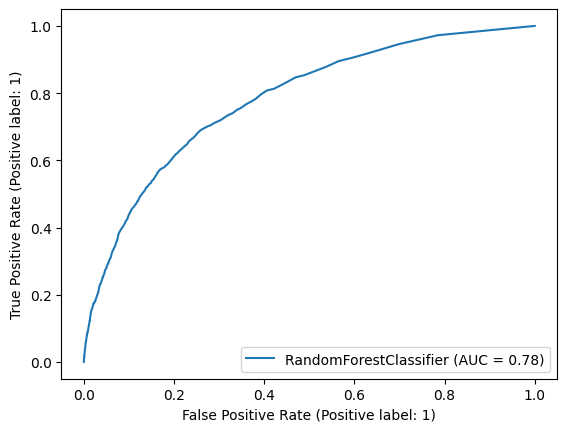

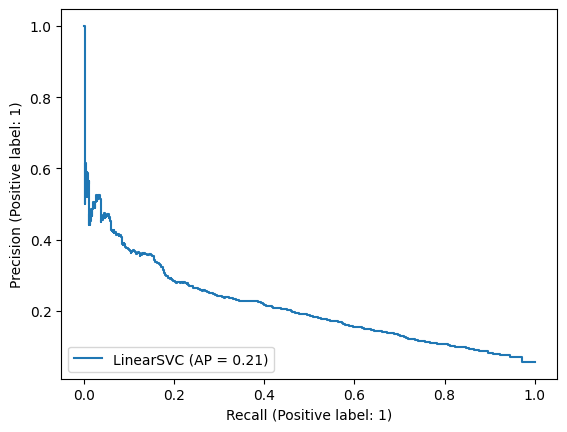

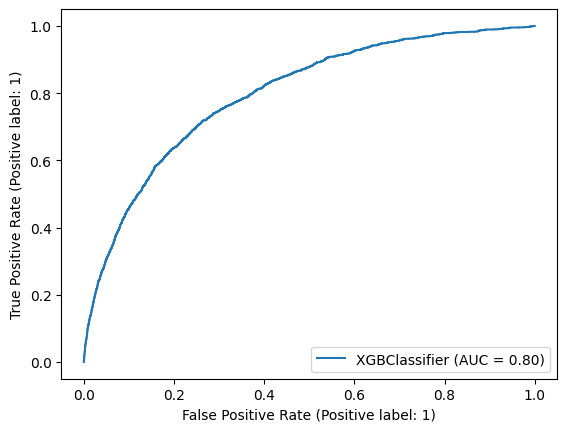

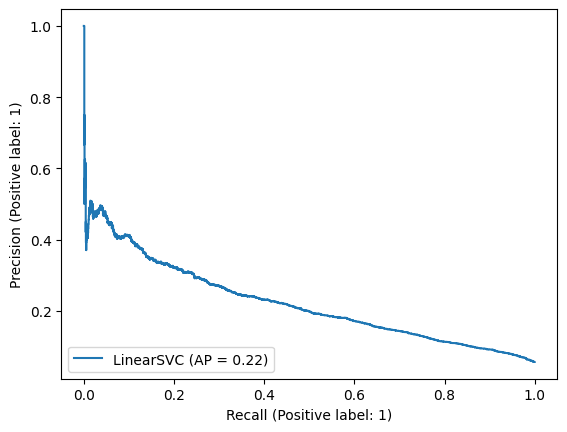

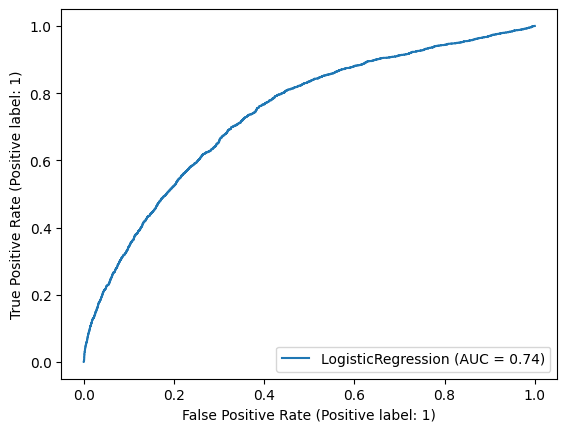

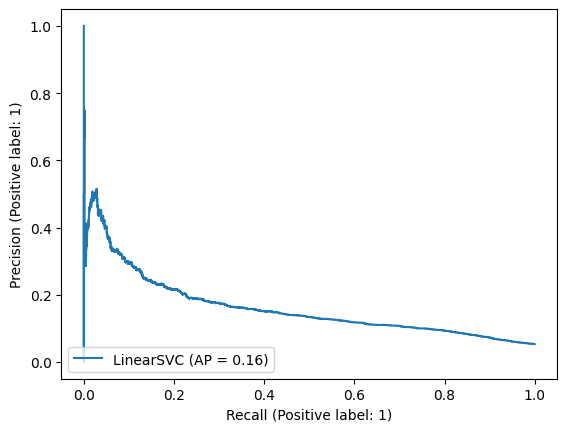

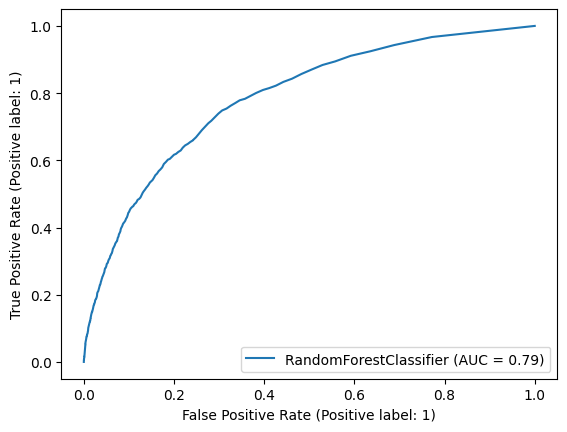

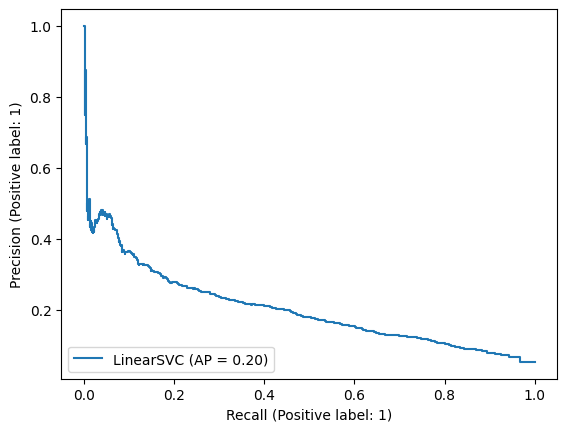

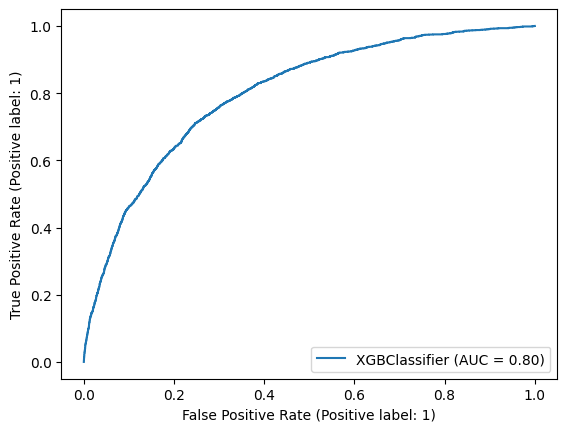

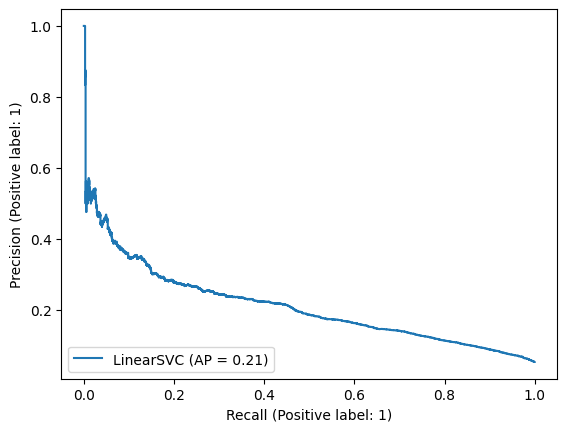

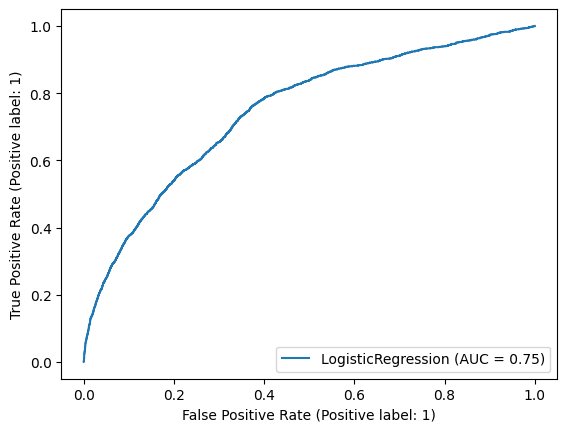

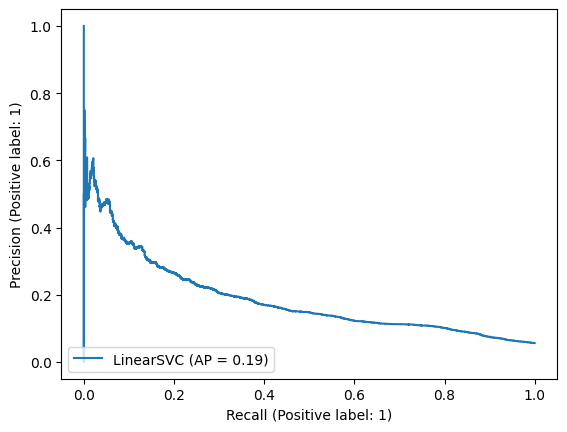

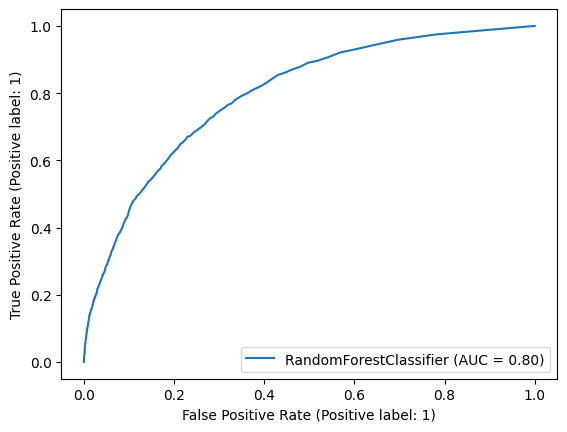

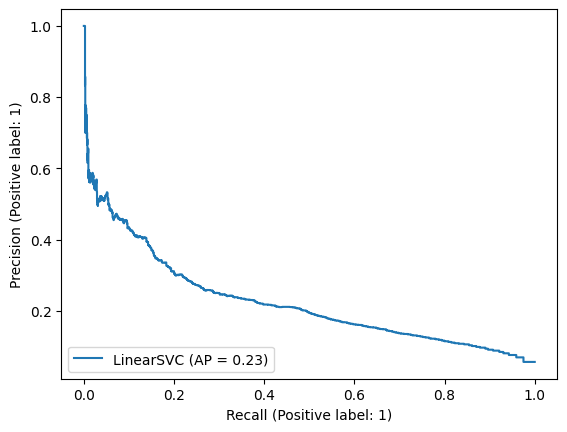

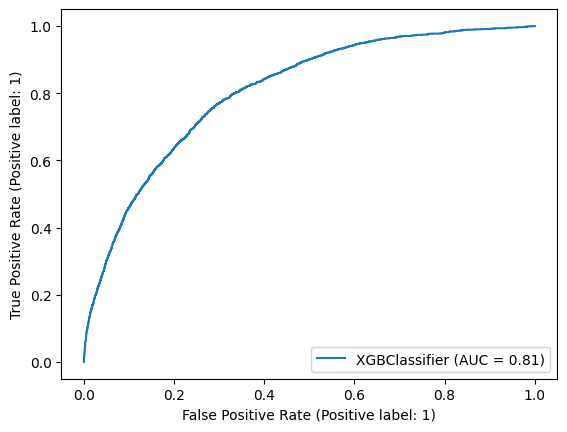

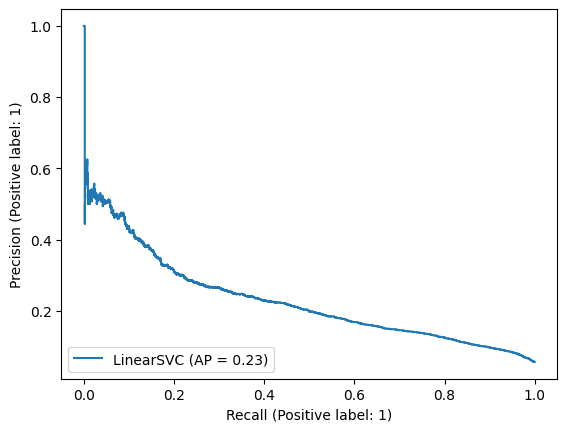

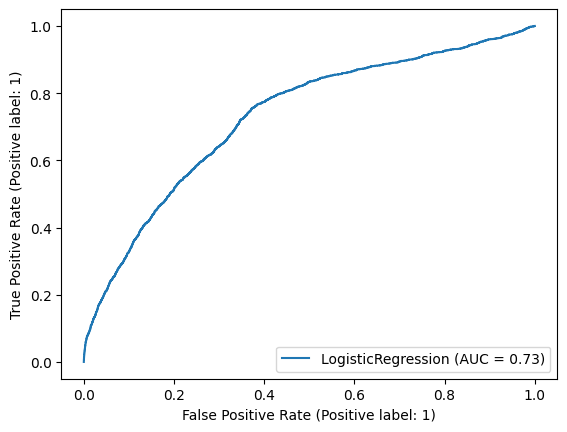

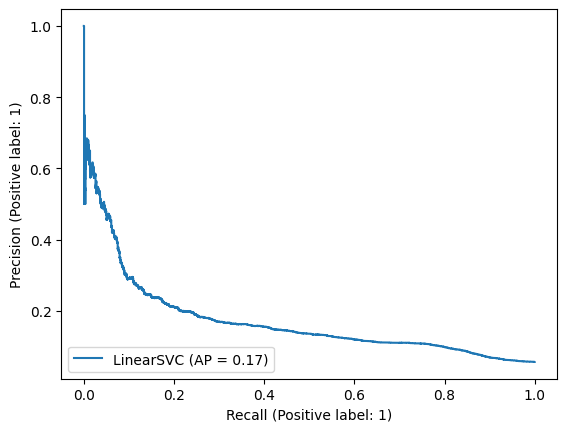

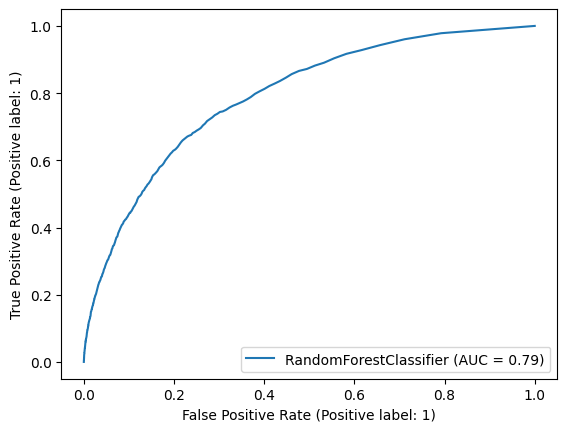

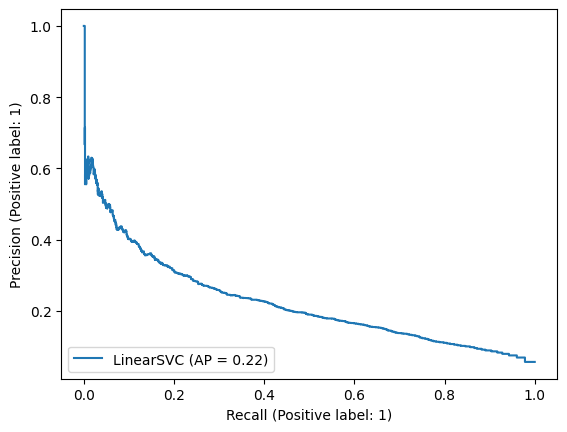

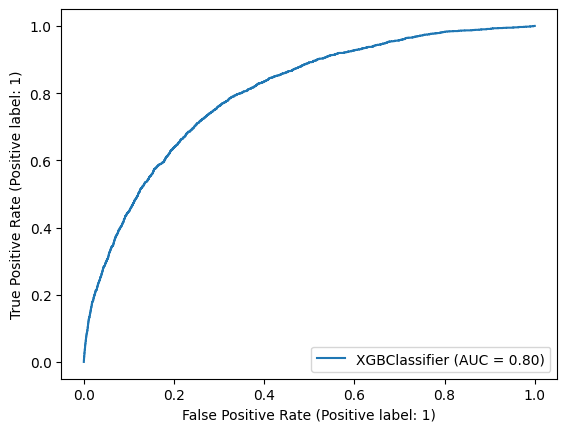

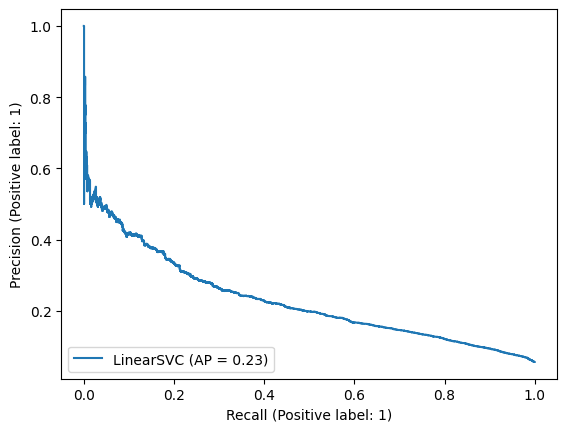

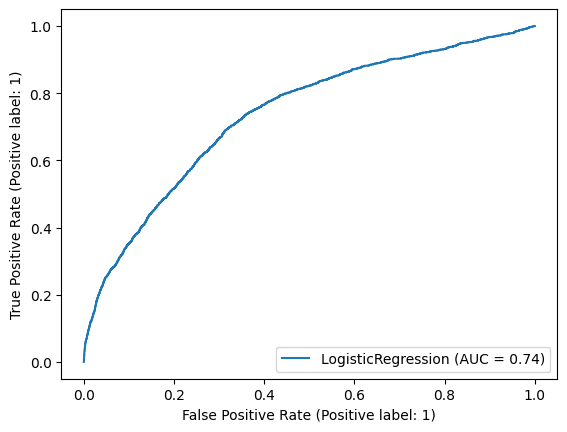

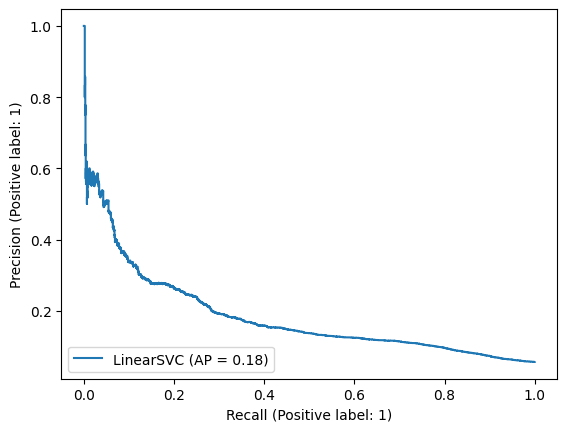

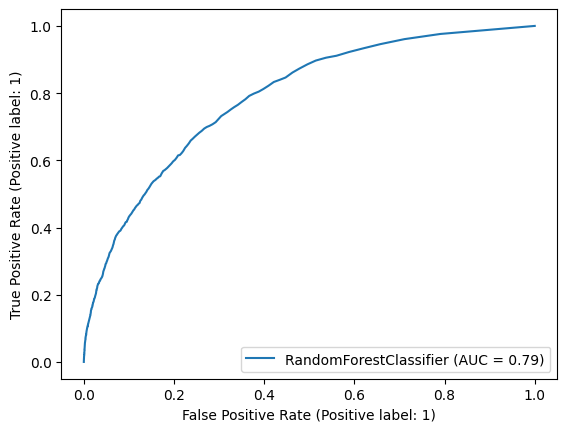

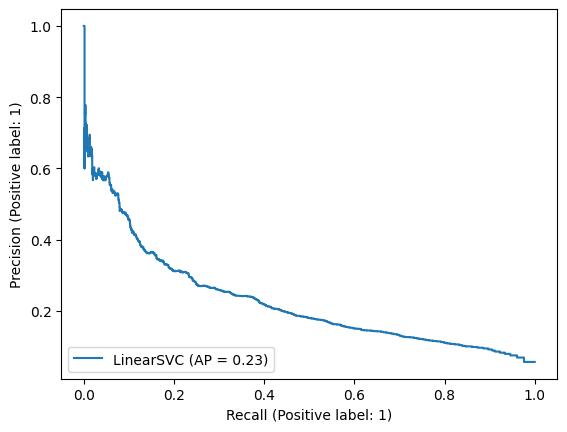

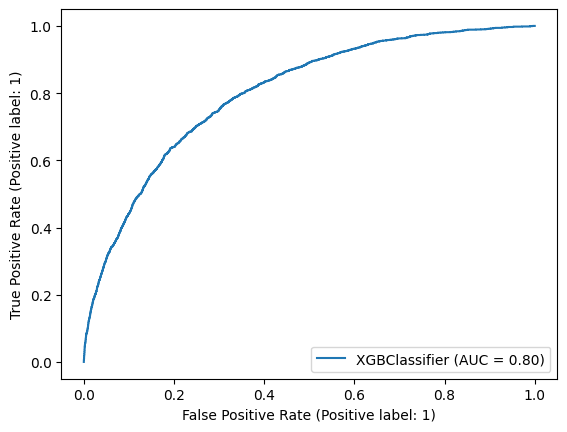

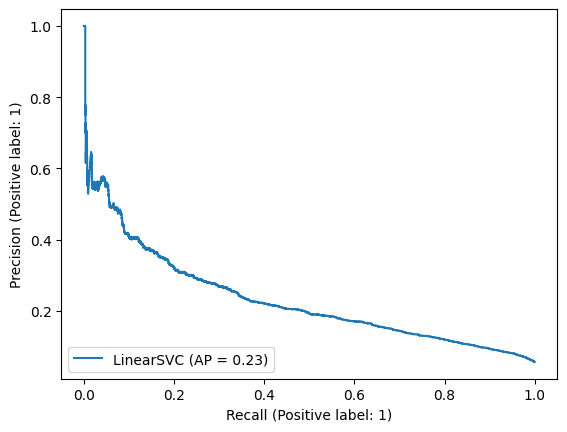

In [37]:
trainTabDDPM25000 = pd.read_csv("Results/TDDPM_25000_final_test_KS_kyuHwan_stability_AUCPRC_1/RealTDDPM_1.csv", sep=",", encoding='cp1252')
holdoutTabDDPM25000 = pd.read_csv("Results/TDDPM_25000_final_test_KS_kyuHwan_stability_AUCPRC_1/testTDDPM_1.csv", sep=",", encoding='cp1252')
synthTabDDPM25000 = pd.read_csv("Results/TDDPM_25000_final_test_KS_kyuHwan_stability_AUCPRC_1/SyntheticTDDPM_1.csv", sep=",", encoding='cp1252')
trainTabDDPM25000 = trainTabDDPM25000.drop(trainTabDDPM25000.columns[0],axis = 1)
holdoutTabDDPM25000 = holdoutTabDDPM25000.drop(holdoutTabDDPM25000.columns[0],axis = 1)
synthTabDDPM25000 = synthTabDDPM25000.drop(synthTabDDPM25000.columns[0],axis = 1)
print('Logistic: ')
TRTRtesting(synthTabDDPM25000, holdoutTabDDPM25000, 'Logistic')
print('Random Forest: ')
TRTRtesting(synthTabDDPM25000, holdoutTabDDPM25000, 'rf')
print('XGBoost: ')
TRTRtesting(synthTabDDPM25000, holdoutTabDDPM25000, 'XGBoost')

trainTabDDPM25000 = pd.read_csv("Results/TDDPM_25000_final_test_KS_kyuHwan_stability_AUCPRC_2/RealTDDPM_1.csv", sep=",", encoding='cp1252')
holdoutTabDDPM25000 = pd.read_csv("Results/TDDPM_25000_final_test_KS_kyuHwan_stability_AUCPRC_2/testTDDPM_1.csv", sep=",", encoding='cp1252')
synthTabDDPM25000 = pd.read_csv("Results/TDDPM_25000_final_test_KS_kyuHwan_stability_AUCPRC_2/SyntheticTDDPM_1.csv", sep=",", encoding='cp1252')
trainTabDDPM25000 = trainTabDDPM25000.drop(trainTabDDPM25000.columns[0],axis = 1)
holdoutTabDDPM25000 = holdoutTabDDPM25000.drop(holdoutTabDDPM25000.columns[0],axis = 1)
synthTabDDPM25000 = synthTabDDPM25000.drop(synthTabDDPM25000.columns[0],axis = 1)
print('Logistic: ')
TRTRtesting(synthTabDDPM25000, holdoutTabDDPM25000, 'Logistic')
print('Random Forest: ')
TRTRtesting(synthTabDDPM25000, holdoutTabDDPM25000, 'rf')
print('XGBoost: ')
TRTRtesting(synthTabDDPM25000, holdoutTabDDPM25000, 'XGBoost')

trainTabDDPM25000 = pd.read_csv("Results/TDDPM_25000_final_test_KS_kyuHwan_stability_AUCPRC_3/RealTDDPM_1.csv", sep=",", encoding='cp1252')
holdoutTabDDPM25000 = pd.read_csv("Results/TDDPM_25000_final_test_KS_kyuHwan_stability_AUCPRC_3/testTDDPM_1.csv", sep=",", encoding='cp1252')
synthTabDDPM25000 = pd.read_csv("Results/TDDPM_25000_final_test_KS_kyuHwan_stability_AUCPRC_3/SyntheticTDDPM_1.csv", sep=",", encoding='cp1252')
trainTabDDPM25000 = trainTabDDPM25000.drop(trainTabDDPM25000.columns[0],axis = 1)
holdoutTabDDPM25000 = holdoutTabDDPM25000.drop(holdoutTabDDPM25000.columns[0],axis = 1)
synthTabDDPM25000 = synthTabDDPM25000.drop(synthTabDDPM25000.columns[0],axis = 1)
print('Logistic: ')
TRTRtesting(synthTabDDPM25000, holdoutTabDDPM25000, 'Logistic')
print('Random Forest: ')
TRTRtesting(synthTabDDPM25000, holdoutTabDDPM25000, 'rf')
print('XGBoost: ')
TRTRtesting(synthTabDDPM25000, holdoutTabDDPM25000, 'XGBoost')

trainTabDDPM25000 = pd.read_csv("Results/TDDPM_25000_final_test_KS_kyuHwan_stability_AUCPRC_4/RealTDDPM_1.csv", sep=",", encoding='cp1252')
holdoutTabDDPM25000 = pd.read_csv("Results/TDDPM_25000_final_test_KS_kyuHwan_stability_AUCPRC_4/testTDDPM_1.csv", sep=",", encoding='cp1252')
synthTabDDPM25000 = pd.read_csv("Results/TDDPM_25000_final_test_KS_kyuHwan_stability_AUCPRC_4/SyntheticTDDPM_1.csv", sep=",", encoding='cp1252')
trainTabDDPM25000 = trainTabDDPM25000.drop(trainTabDDPM25000.columns[0],axis = 1)
holdoutTabDDPM25000 = holdoutTabDDPM25000.drop(holdoutTabDDPM25000.columns[0],axis = 1)
synthTabDDPM25000 = synthTabDDPM25000.drop(synthTabDDPM25000.columns[0],axis = 1)
print('Logistic: ')
TRTRtesting(synthTabDDPM25000, holdoutTabDDPM25000, 'Logistic')
print('Random Forest: ')
TRTRtesting(synthTabDDPM25000, holdoutTabDDPM25000, 'rf')
print('XGBoost: ')
TRTRtesting(synthTabDDPM25000, holdoutTabDDPM25000, 'XGBoost')

trainTabDDPM25000 = pd.read_csv("Results/TDDPM_25000_final_test_KS_kyuHwan_stability_AUCPRC_5/RealTDDPM_1.csv", sep=",", encoding='cp1252')
holdoutTabDDPM25000 = pd.read_csv("Results/TDDPM_25000_final_test_KS_kyuHwan_stability_AUCPRC_5/testTDDPM_1.csv", sep=",", encoding='cp1252')
synthTabDDPM25000 = pd.read_csv("Results/TDDPM_25000_final_test_KS_kyuHwan_stability_AUCPRC_5/SyntheticTDDPM_1.csv", sep=",", encoding='cp1252')
trainTabDDPM25000 = trainTabDDPM25000.drop(trainTabDDPM25000.columns[0],axis = 1)
holdoutTabDDPM25000 = holdoutTabDDPM25000.drop(holdoutTabDDPM25000.columns[0],axis = 1)
synthTabDDPM25000 = synthTabDDPM25000.drop(synthTabDDPM25000.columns[0],axis = 1)
print('Logistic: ')
TRTRtesting(synthTabDDPM25000, holdoutTabDDPM25000, 'Logistic')
print('Random Forest: ')
TRTRtesting(synthTabDDPM25000, holdoutTabDDPM25000, 'rf')
print('XGBoost: ')
TRTRtesting(synthTabDDPM25000, holdoutTabDDPM25000, 'XGBoost')

In [39]:
LogisticAUC=[0.72,0.74,0.75,0.73,0.74]
RandomForestAUC=[0.78,0.79,0.8,0.79,0.79]
XGBoostAUC=[0.8,0.8,0.81,0.8,0.8]



LogisticAUC=np.array(LogisticAUC)
RandomForestAUC=np.array(RandomForestAUC)
XGBoostAUC=np.array(XGBoostAUC)

print("Logistic AUC")
print('mean: ',LogisticAUC.mean())
print('std: ',LogisticAUC.std())
print("Random Forest AUC")
print('mean: ',RandomForestAUC.mean())
print('std: ',RandomForestAUC.std())
print("XGBoost AUC")
print('mean: ',XGBoostAUC.mean())
print('std: ',XGBoostAUC.std())


Logistic AUC
mean:  0.736
std:  0.01019803902718558
Random Forest AUC
mean:  0.79
std:  0.006324555320336764
XGBoost AUC
mean:  0.8019999999999999
std:  0.0040000000000000036


#### CTGAN 5 RUN AUC PRC

Logistic: 


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Random Forest: 
XGBoost: 
[13:53:38] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

Logistic: 


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Random Forest: 
XGBoost: 
[13:55:18] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

Logistic: 


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Random Forest: 
XGBoost: 
[13:56:57] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

Logistic: 


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Random Forest: 


C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_plot\roc_curve.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_plot\precision_recall_curve.py:162: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


XGBoost: 
[13:58:29] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.



C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_plot\roc_curve.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_plot\precision_recall_curve.py:162: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Logistic: 


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_plot\roc_curve.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_plot\precision_recall_curve.py:162: RuntimeWarning

Random Forest: 


C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_plot\roc_curve.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_plot\precision_recall_curve.py:162: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


XGBoost: 
[13:59:59] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.



C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_plot\roc_curve.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_plot\precision_recall_curve.py:162: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


(<sklearn.metrics._plot.roc_curve.RocCurveDisplay at 0x1d7bc77c190>,
 <sklearn.metrics._plot.precision_recall_curve.PrecisionRecallDisplay at 0x1d7c064b580>)

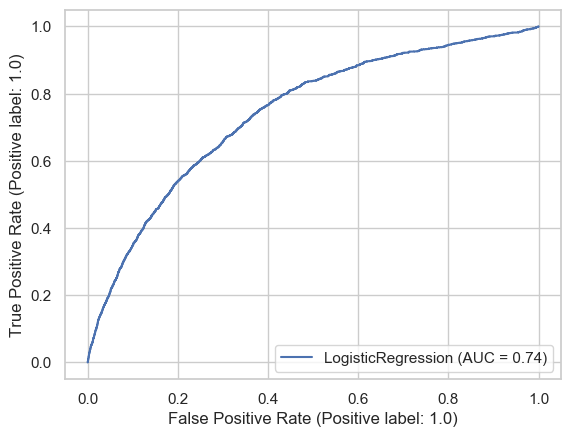

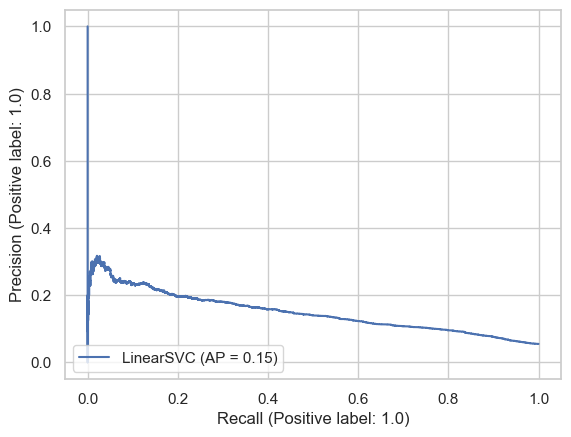

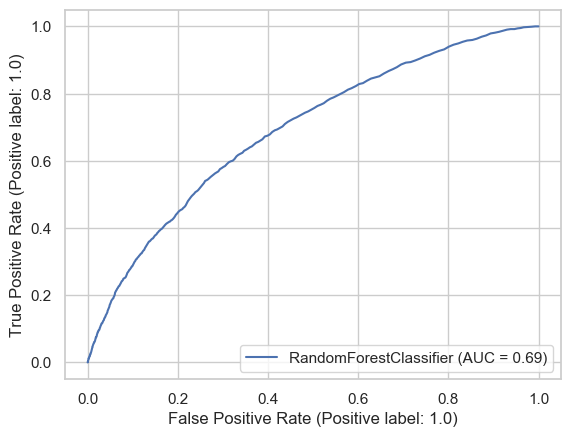

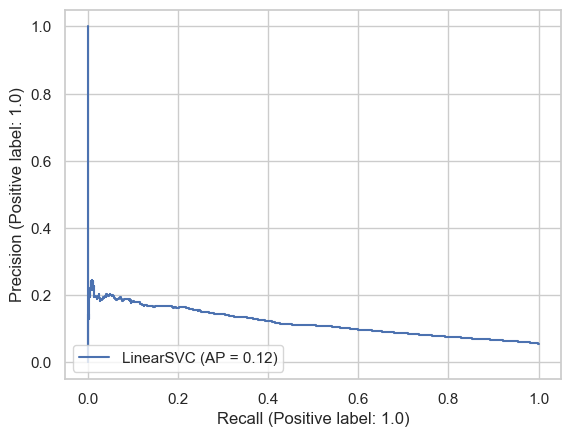

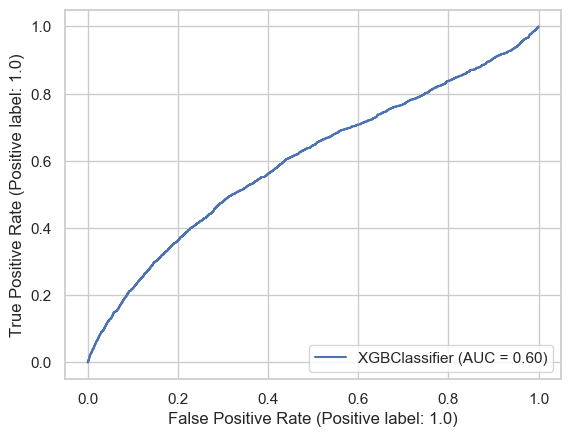

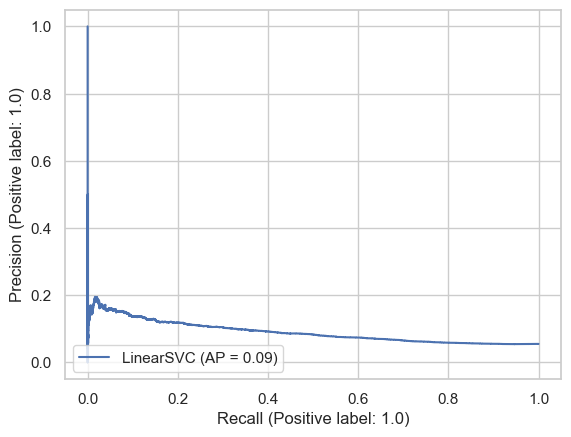

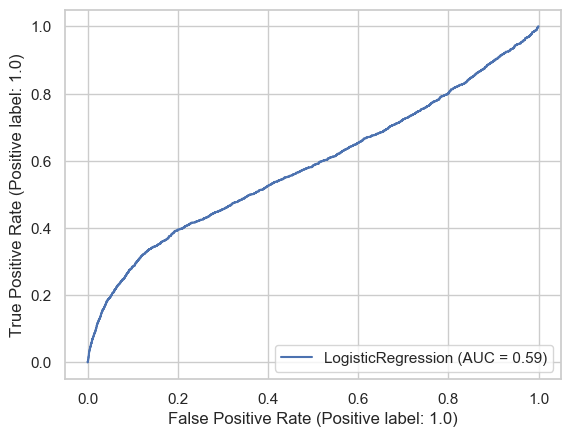

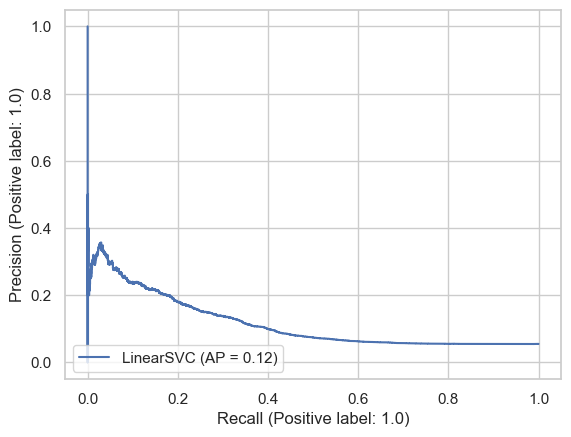

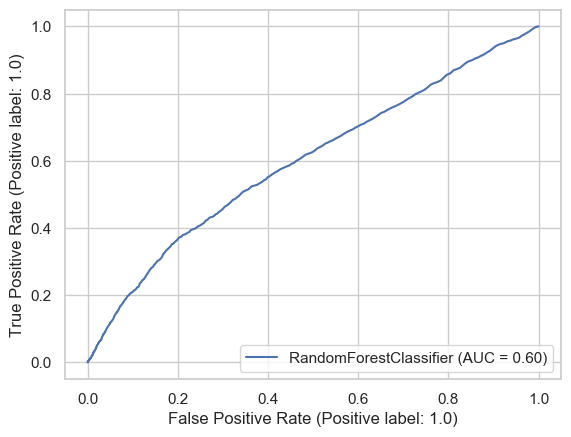

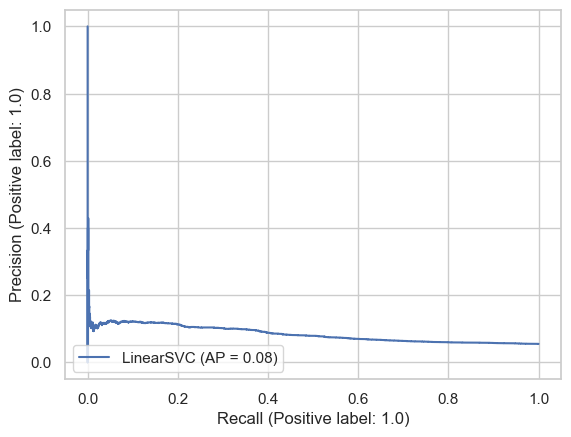

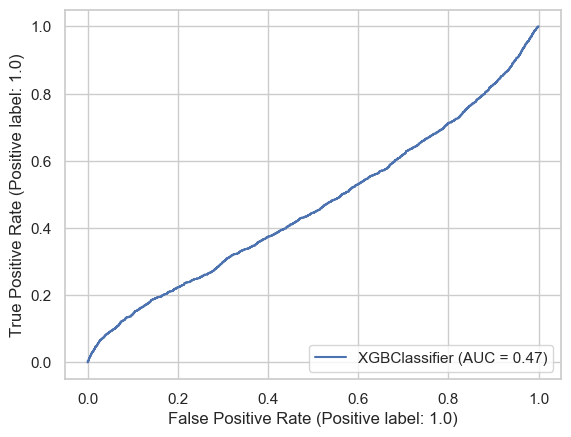

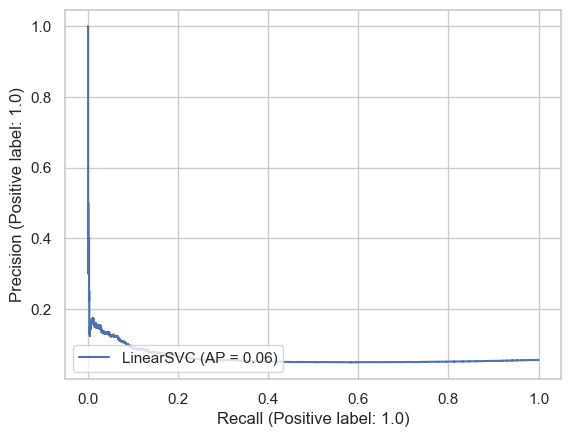

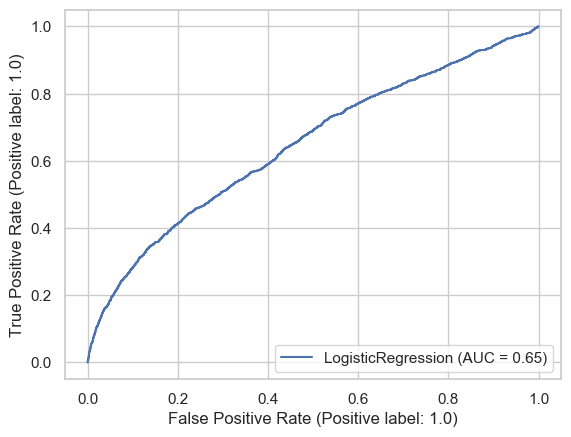

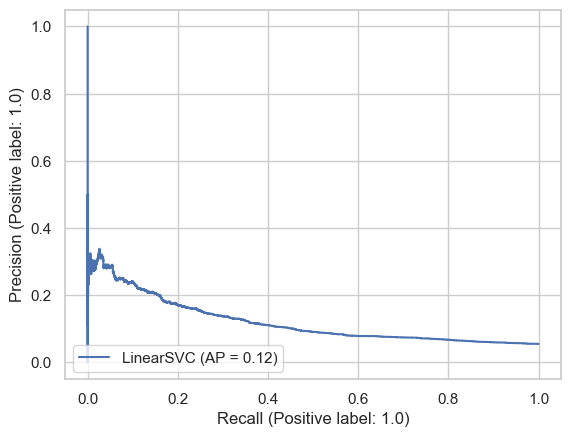

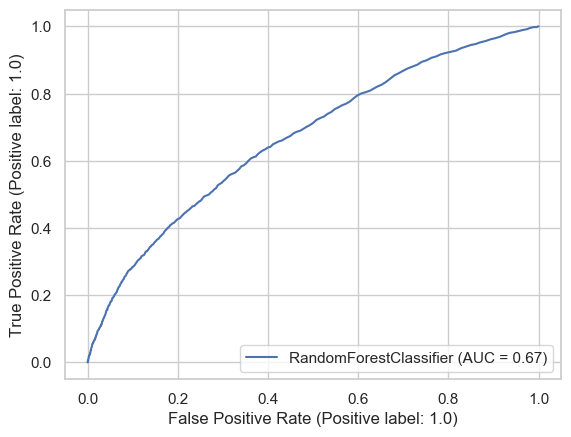

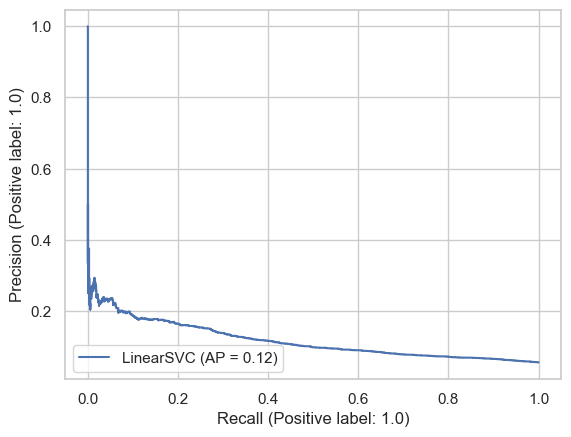

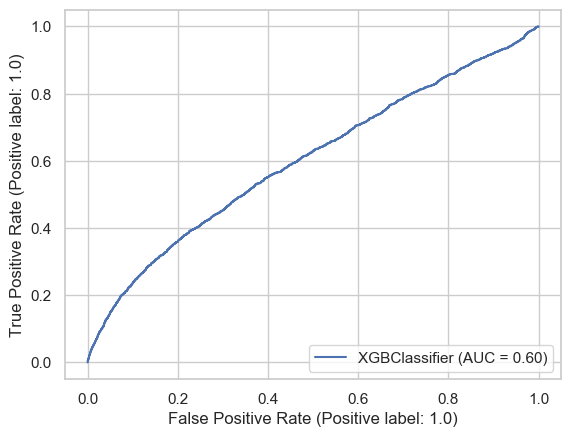

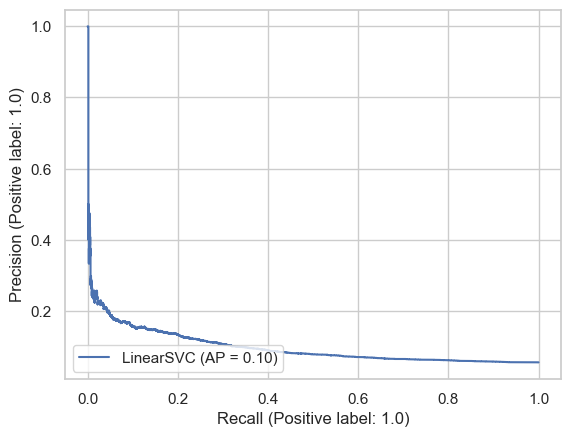

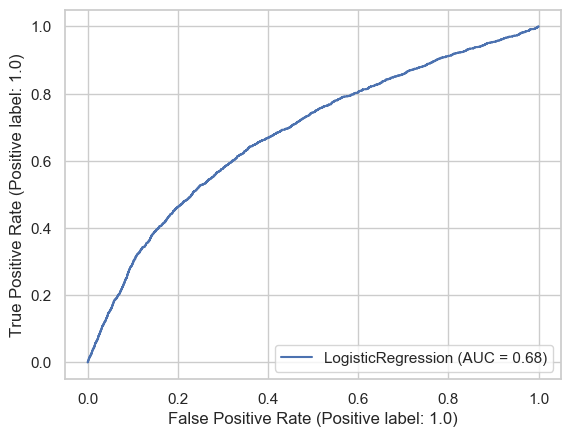

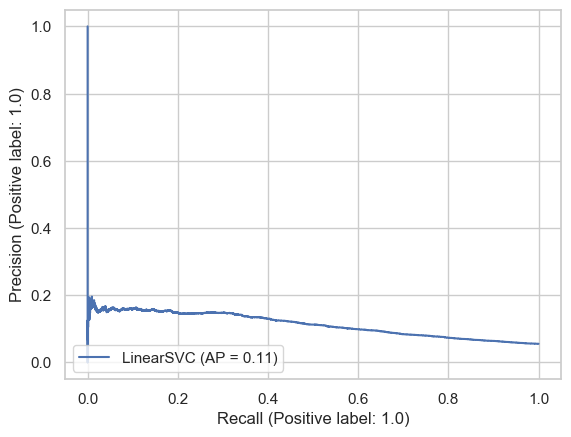

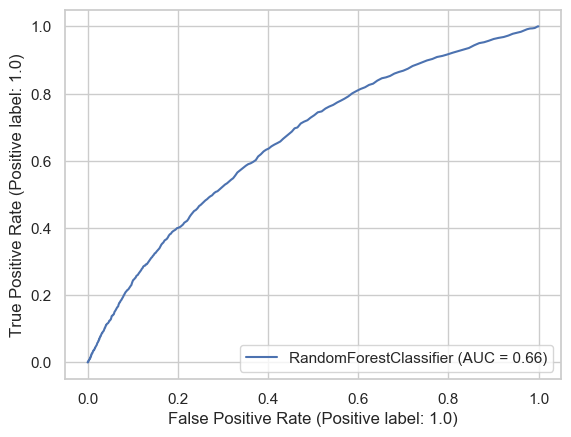

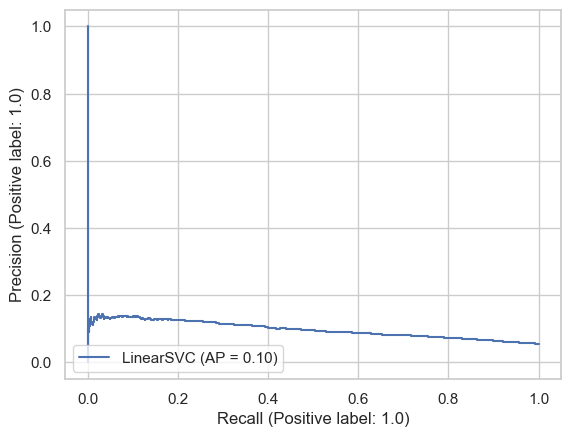

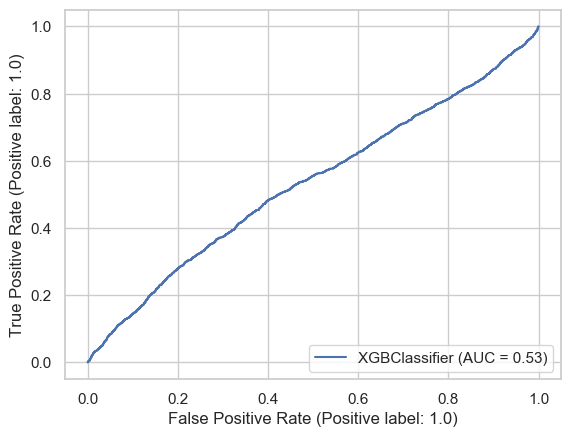

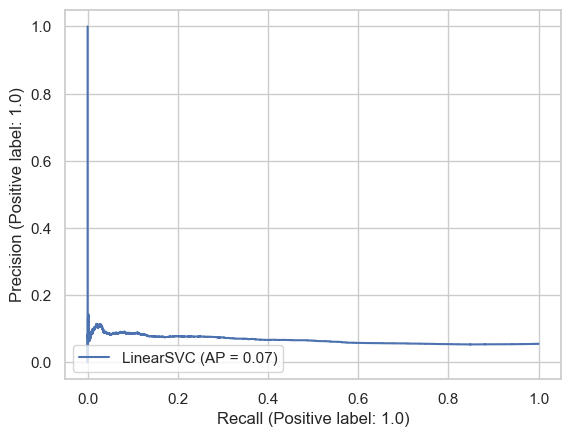

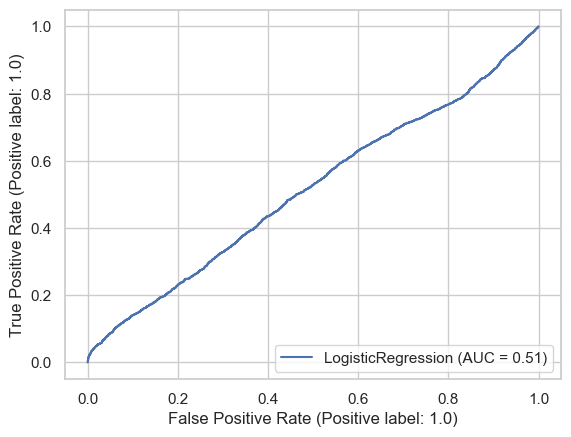

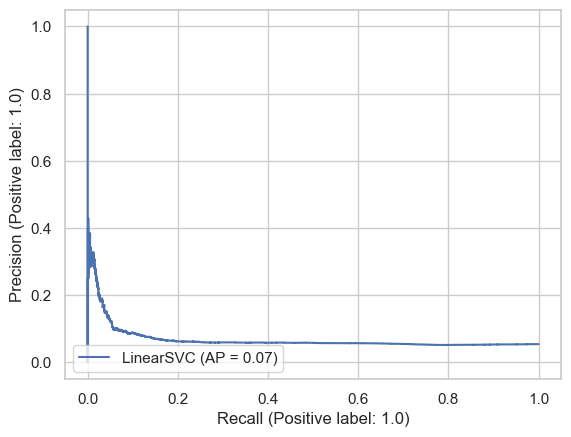

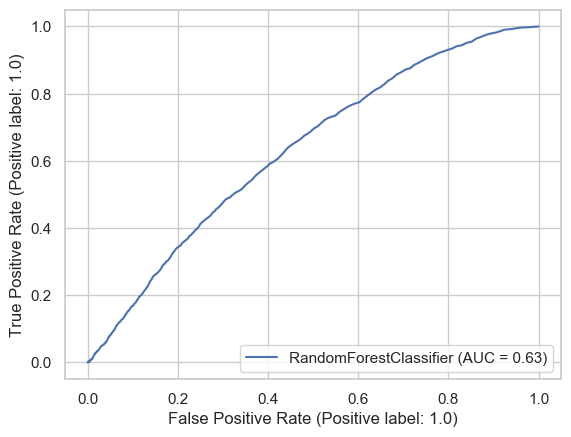

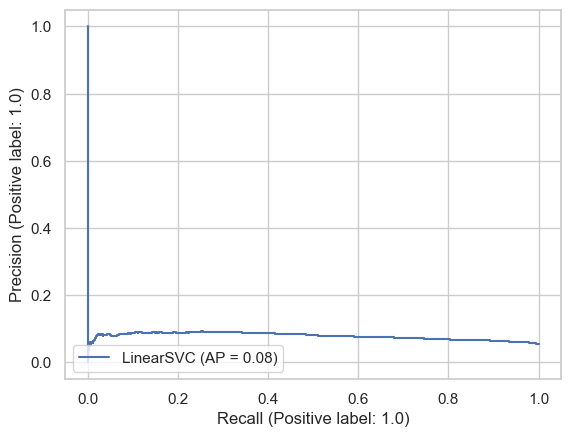

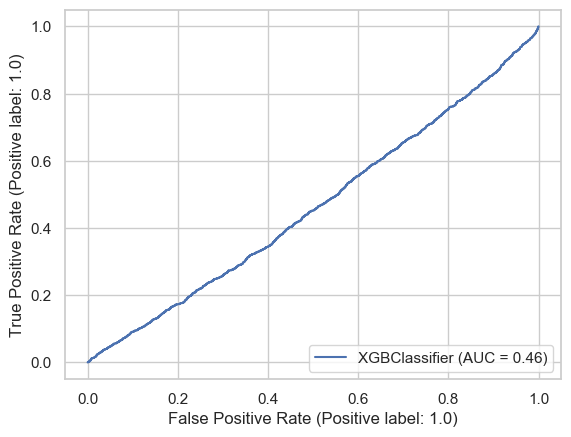

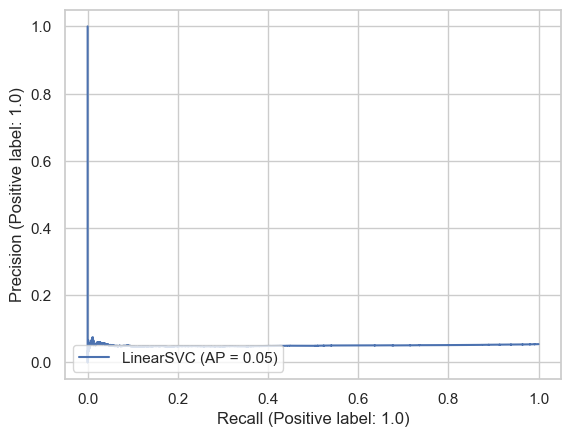

In [24]:
trainCTGAN = pd.read_csv("Results/CTGAN_100_epoch_for_AUCPRC_0.7_1ndRun/CTGAN_100_epoch_for_AUCPRC_0.7_1ndRun_originalData.csv", sep=",", encoding='cp1252')
holdoutCTGAN = pd.read_csv("Results/CTGAN_100_epoch_for_AUCPRC_0.7_1ndRun/CTGAN_100_epoch_for_AUCPRC_0.7_1ndRun_testData.csv", sep=",", encoding='cp1252')
synthCTGAN = pd.read_csv("Results/CTGAN_100_epoch_for_AUCPRC_0.7_1ndRun/CTGAN_100_epoch_for_AUCPRC_0.7_1ndRun_synthData.csv", sep=",", encoding='cp1252')
trainCTGAN = trainCTGAN.drop(trainCTGAN.columns[0],axis = 1)
holdoutCTGAN = holdoutCTGAN.drop(holdoutCTGAN.columns[0],axis = 1)
synthCTGAN = synthCTGAN.drop(synthCTGAN.columns[0],axis = 1)
print('Logistic: ')
TRTRtesting(synthCTGAN, holdoutCTGAN, 'Logistic')
print('Random Forest: ')
TRTRtesting(synthCTGAN, holdoutCTGAN, 'rf')
print('XGBoost: ')
TRTRtesting(synthCTGAN, holdoutCTGAN, 'XGBoost')

trainCTGAN = pd.read_csv("Results/CTGAN_100_epoch_for_AUCPRC_0.7_2ndRun/CTGAN_100_epoch_for_AUCPRC_0.7_2ndRun_originalData.csv", sep=",", encoding='cp1252')
holdoutCTGAN = pd.read_csv("Results/CTGAN_100_epoch_for_AUCPRC_0.7_2ndRun/CTGAN_100_epoch_for_AUCPRC_0.7_2ndRun_testData.csv", sep=",", encoding='cp1252')
synthCTGAN = pd.read_csv("Results/CTGAN_100_epoch_for_AUCPRC_0.7_2ndRun/CTGAN_100_epoch_for_AUCPRC_0.7_2ndRun_synthData.csv", sep=",", encoding='cp1252')
trainCTGAN = trainCTGAN.drop(trainCTGAN.columns[0],axis = 1)
holdoutCTGAN = holdoutCTGAN.drop(holdoutCTGAN.columns[0],axis = 1)
synthCTGAN = synthCTGAN.drop(synthCTGAN.columns[0],axis = 1)
print('Logistic: ')
TRTRtesting(synthCTGAN, holdoutCTGAN, 'Logistic')
print('Random Forest: ')
TRTRtesting(synthCTGAN, holdoutCTGAN, 'rf')
print('XGBoost: ')
TRTRtesting(synthCTGAN, holdoutCTGAN, 'XGBoost')

trainCTGAN = pd.read_csv("Results/CTGAN_100_epoch_for_AUCPRC_0.7_3ndRun/CTGAN_100_epoch_for_AUCPRC_0.7_3ndRun_originalData.csv", sep=",", encoding='cp1252')
holdoutCTGAN = pd.read_csv("Results/CTGAN_100_epoch_for_AUCPRC_0.7_3ndRun/CTGAN_100_epoch_for_AUCPRC_0.7_3ndRun_testData.csv", sep=",", encoding='cp1252')
synthCTGAN = pd.read_csv("Results/CTGAN_100_epoch_for_AUCPRC_0.7_3ndRun/CTGAN_100_epoch_for_AUCPRC_0.7_3ndRun_synthData.csv", sep=",", encoding='cp1252')
trainCTGAN = trainCTGAN.drop(trainCTGAN.columns[0],axis = 1)
holdoutCTGAN = holdoutCTGAN.drop(holdoutCTGAN.columns[0],axis = 1)
synthCTGAN = synthCTGAN.drop(synthCTGAN.columns[0],axis = 1)
print('Logistic: ')
TRTRtesting(synthCTGAN, holdoutCTGAN, 'Logistic')
print('Random Forest: ')
TRTRtesting(synthCTGAN, holdoutCTGAN, 'rf')
print('XGBoost: ')
TRTRtesting(synthCTGAN, holdoutCTGAN, 'XGBoost')

trainCTGAN = pd.read_csv("Results/CTGAN_100_epoch_for_AUCPRC_0.7_4ndRun/CTGAN_100_epoch_for_AUCPRC_0.7_4ndRun_originalData.csv", sep=",", encoding='cp1252')
holdoutCTGAN = pd.read_csv("Results/CTGAN_100_epoch_for_AUCPRC_0.7_4ndRun/CTGAN_100_epoch_for_AUCPRC_0.7_4ndRun_testData.csv", sep=",", encoding='cp1252')
synthCTGAN = pd.read_csv("Results/CTGAN_100_epoch_for_AUCPRC_0.7_4ndRun/CTGAN_100_epoch_for_AUCPRC_0.7_4ndRun_synthData.csv", sep=",", encoding='cp1252')
trainCTGAN = trainCTGAN.drop(trainCTGAN.columns[0],axis = 1)
holdoutCTGAN = holdoutCTGAN.drop(holdoutCTGAN.columns[0],axis = 1)
synthCTGAN = synthCTGAN.drop(synthCTGAN.columns[0],axis = 1)
print('Logistic: ')
TRTRtesting(synthCTGAN, holdoutCTGAN, 'Logistic')
print('Random Forest: ')
TRTRtesting(synthCTGAN, holdoutCTGAN, 'rf')
print('XGBoost: ')
TRTRtesting(synthCTGAN, holdoutCTGAN, 'XGBoost')

trainCTGAN = pd.read_csv("Results/CTGAN_100_epoch_for_AUCPRC_0.7_5ndRun/CTGAN_100_epoch_for_AUCPRC_0.7_5ndRun_originalData.csv", sep=",", encoding='cp1252')
holdoutCTGAN = pd.read_csv("Results/CTGAN_100_epoch_for_AUCPRC_0.7_5ndRun/CTGAN_100_epoch_for_AUCPRC_0.7_5ndRun_testData.csv", sep=",", encoding='cp1252')
synthCTGAN = pd.read_csv("Results/CTGAN_100_epoch_for_AUCPRC_0.7_5ndRun/CTGAN_100_epoch_for_AUCPRC_0.7_5ndRun_synthData.csv", sep=",", encoding='cp1252')
trainCTGAN = trainCTGAN.drop(trainCTGAN.columns[0],axis = 1)
holdoutCTGAN = holdoutCTGAN.drop(holdoutCTGAN.columns[0],axis = 1)
synthCTGAN = synthCTGAN.drop(synthCTGAN.columns[0],axis = 1)
print('Logistic: ')
TRTRtesting(synthCTGAN, holdoutCTGAN, 'Logistic')
print('Random Forest: ')
TRTRtesting(synthCTGAN, holdoutCTGAN, 'rf')
print('XGBoost: ')
TRTRtesting(synthCTGAN, holdoutCTGAN, 'XGBoost')

#### CTABGAN+ AUC PRC 450 epoch

Logistic: 


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(

Bad key text.latex.preview in file C:\Users\user\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.7.0/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file C:\Users\user\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, lin

Random Forest: 
XGBoost: 
[13:07:57] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

Logistic: 


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Random Forest: 
XGBoost: 
[13:09:38] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

Logistic: 


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Random Forest: 
XGBoost: 
[13:11:09] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

Logistic: 


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Random Forest: 


C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_plot\roc_curve.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


XGBoost: 
[13:12:32] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

Logistic: 


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Random Forest: 
XGBoost: 
[13:14:01] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.



(<sklearn.metrics._plot.roc_curve.RocCurveDisplay at 0x2c954ed26d0>,
 <sklearn.metrics._plot.precision_recall_curve.PrecisionRecallDisplay at 0x2c9550a07f0>)

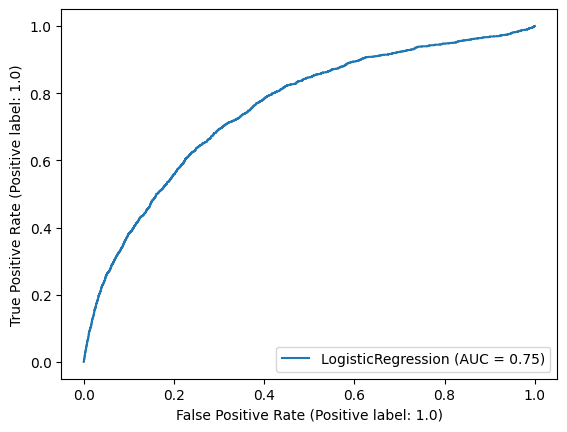

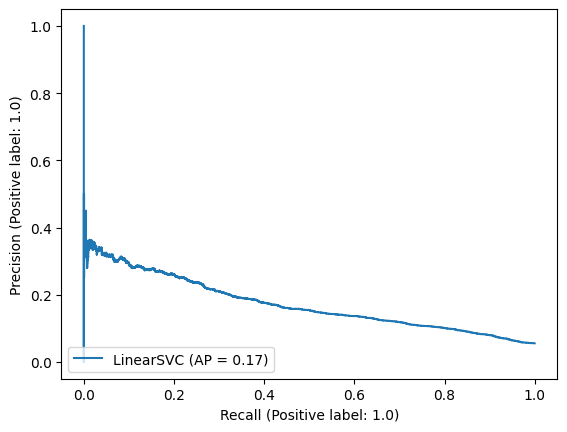

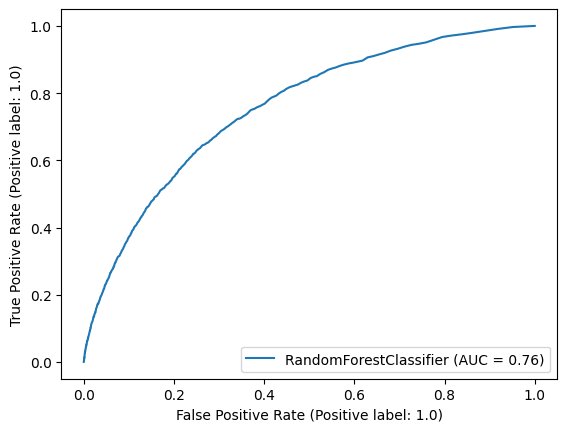

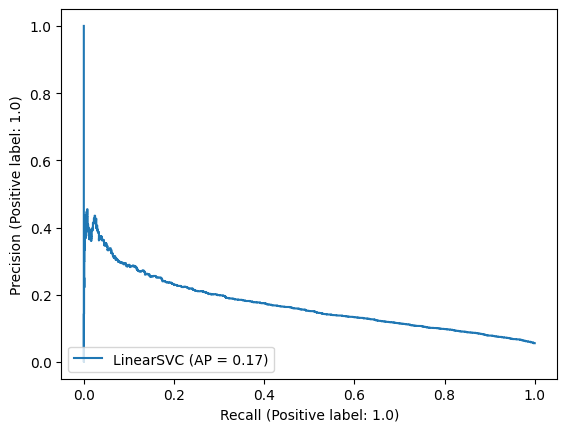

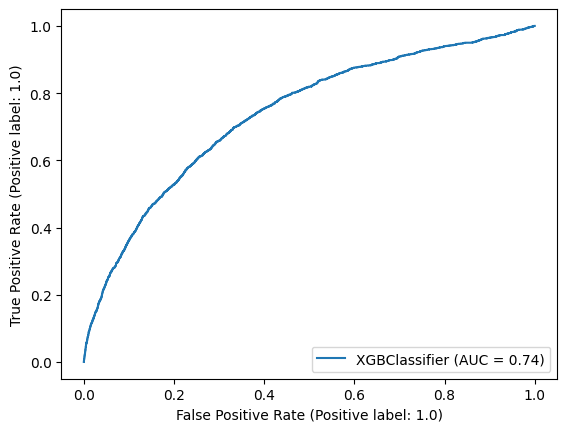

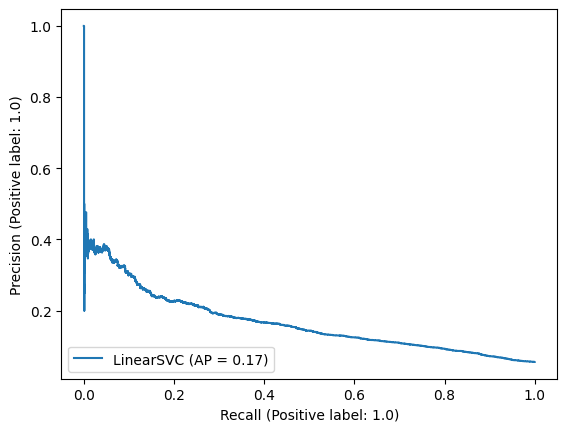

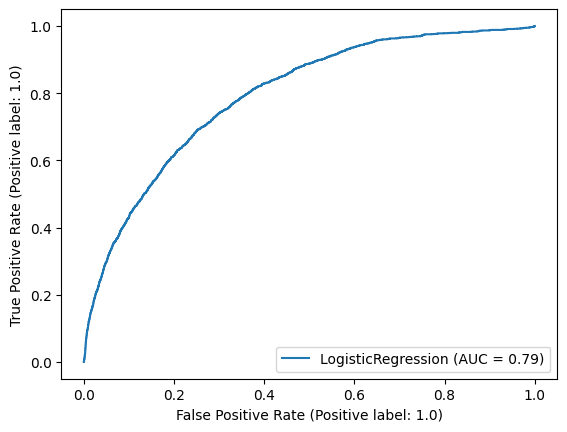

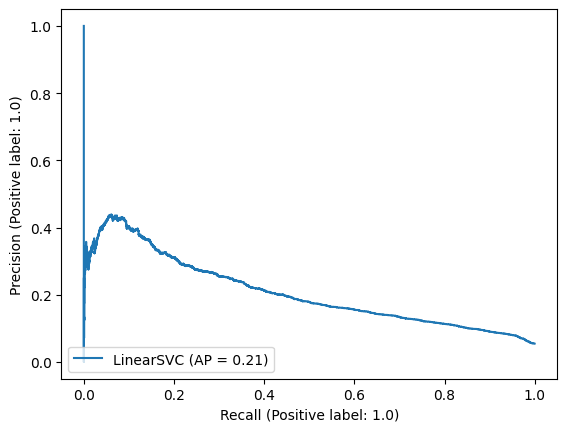

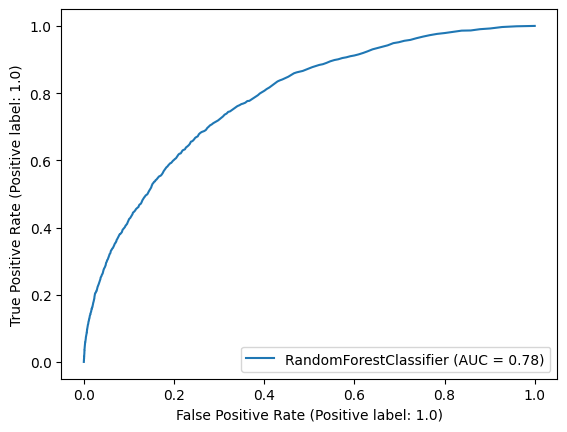

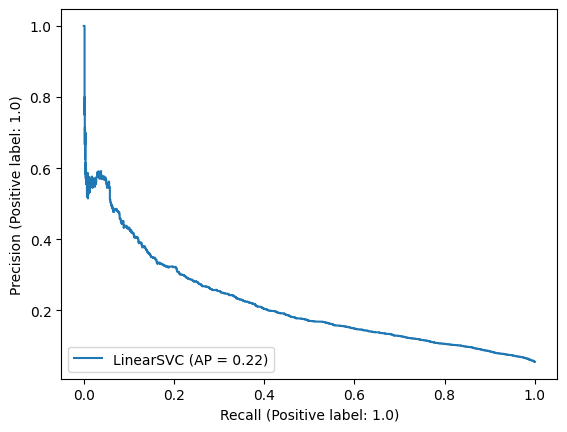

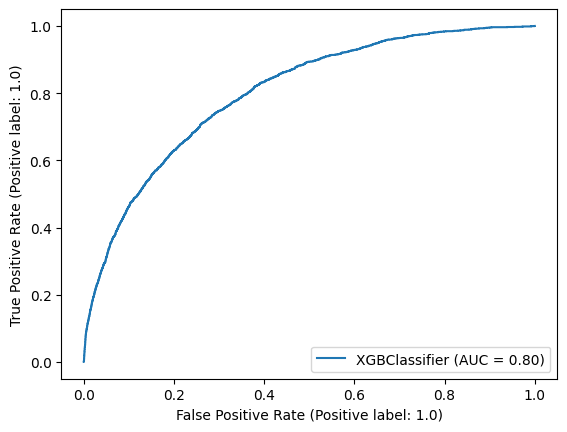

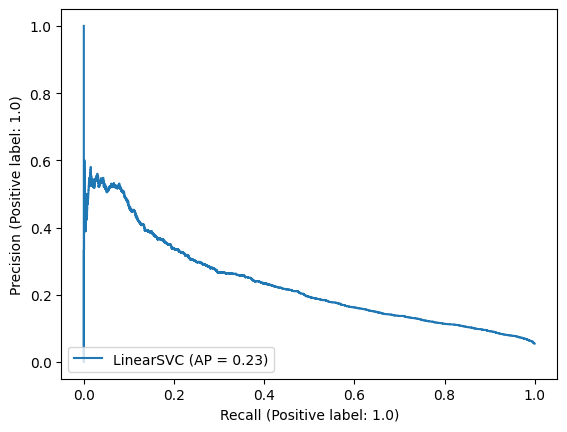

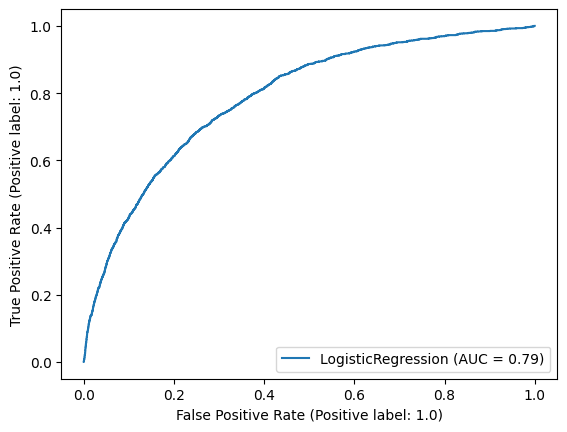

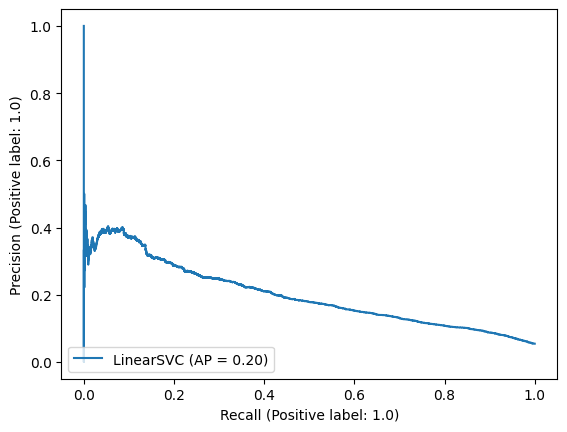

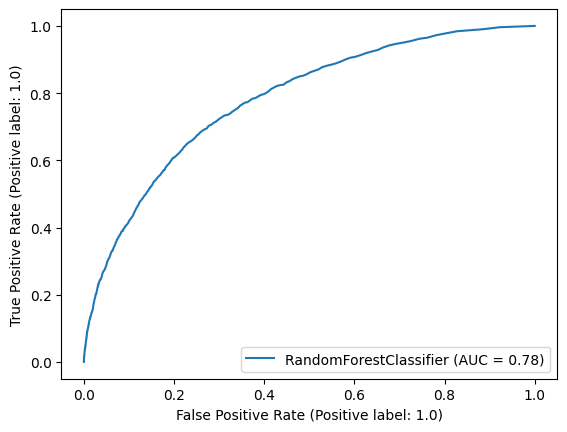

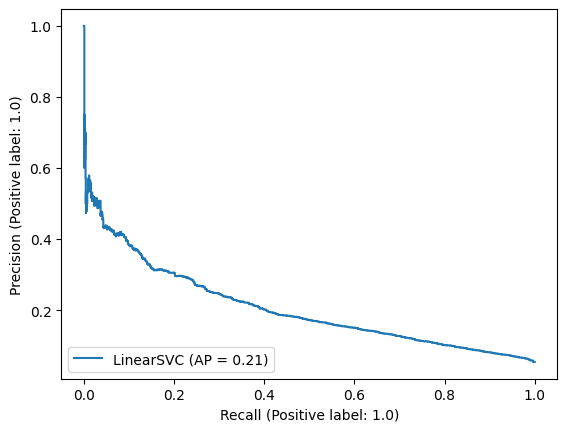

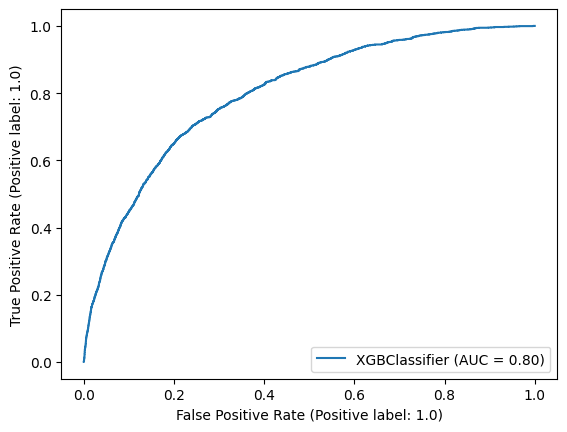

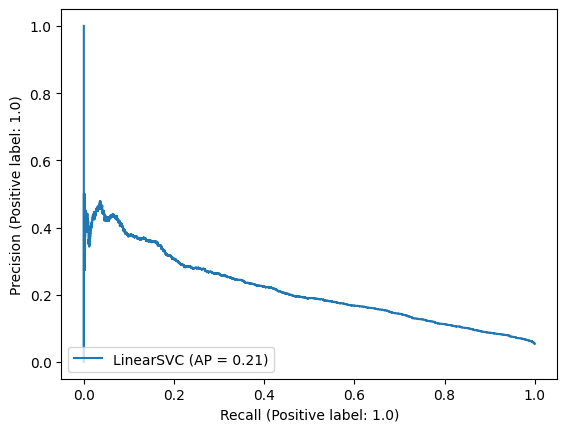

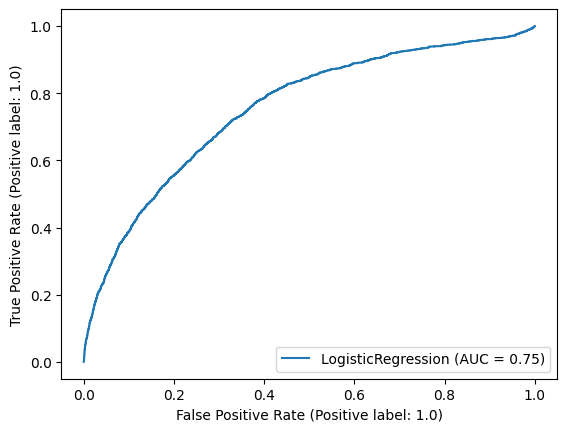

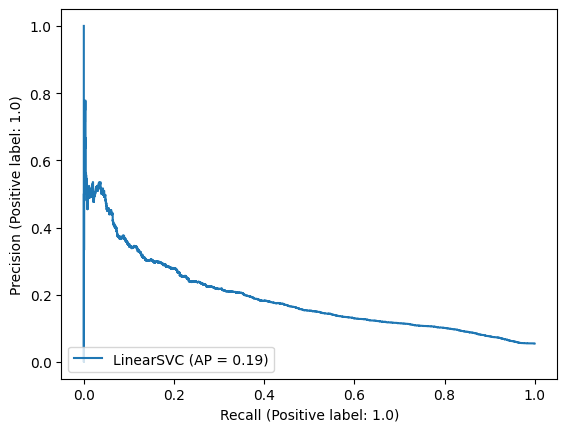

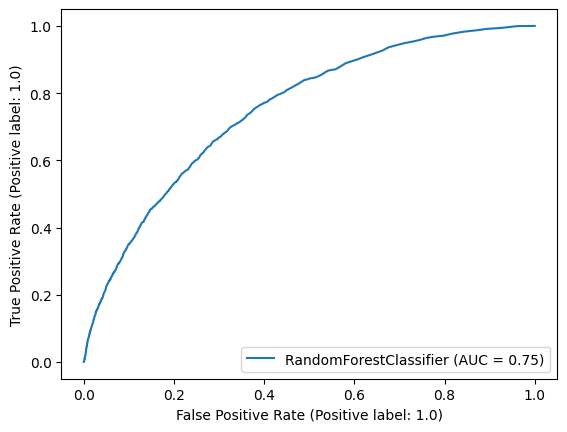

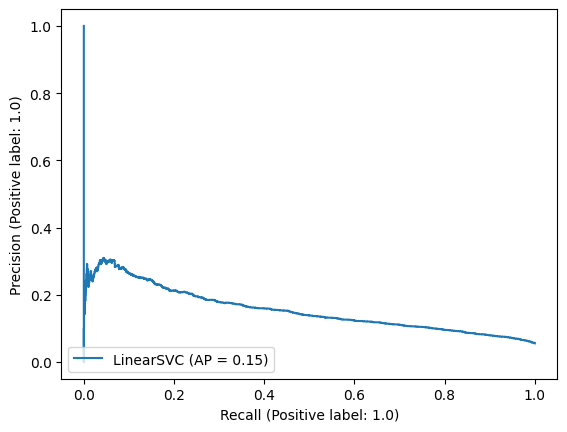

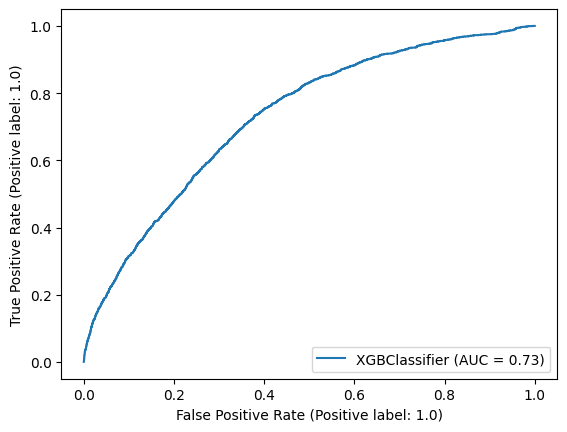

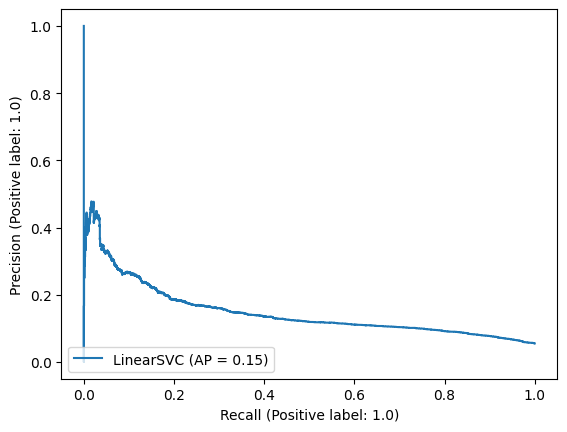

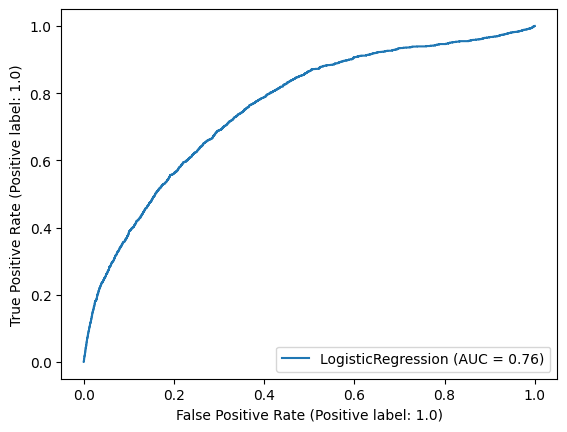

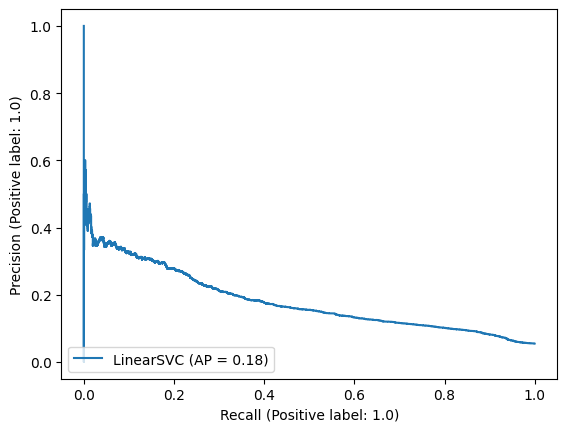

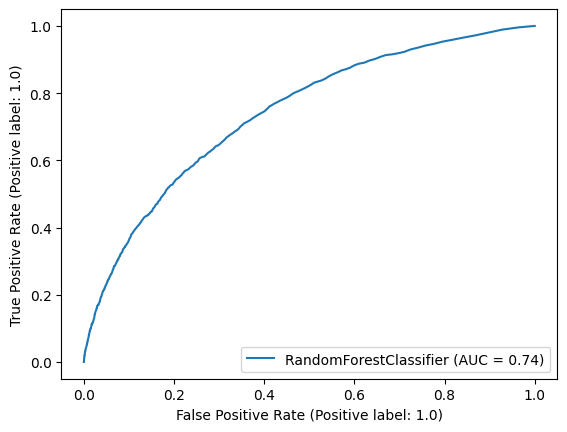

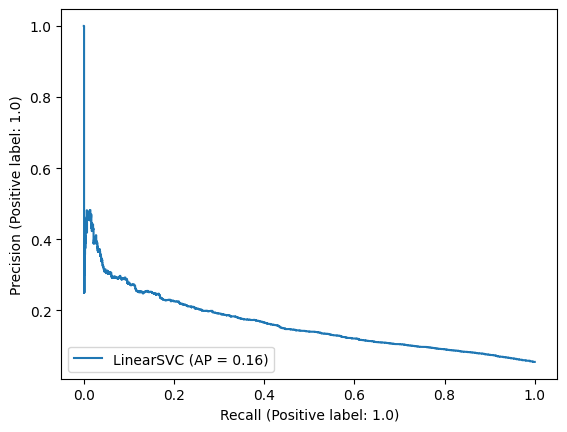

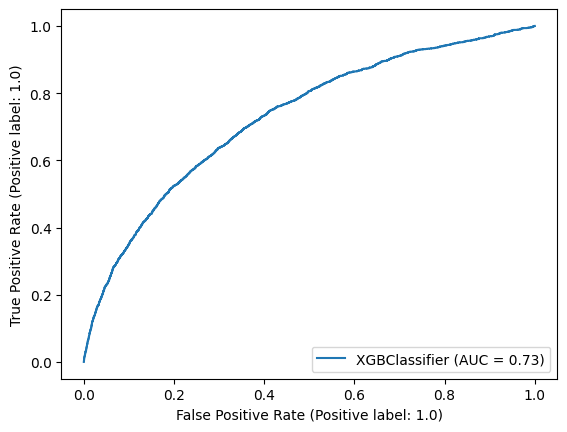

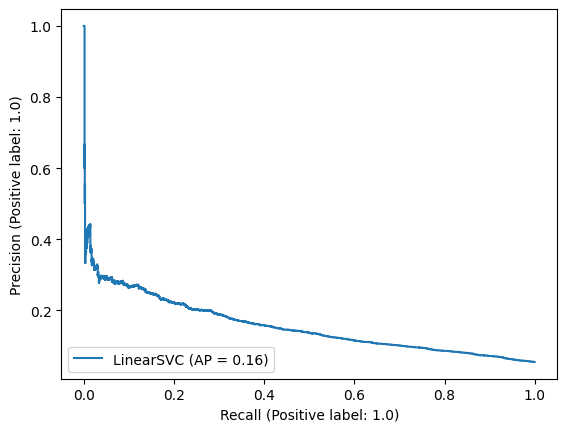

In [8]:
holdoutCTAGBAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Real_Datasets/testCTABGAN1.csv")
synthCTABGAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Fake_Datasets/450epoch_AUCPRC/450epoch_AUCPRC_fake_1.csv")
print('Logistic: ')
TRTRtesting(synthCTABGAN, holdoutCTAGBAN, 'Logistic')
print('Random Forest: ')
TRTRtesting(synthCTABGAN, holdoutCTAGBAN, 'rf')
print('XGBoost: ')
TRTRtesting(synthCTABGAN, holdoutCTAGBAN, 'XGBoost')

holdoutCTAGBAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Real_Datasets/testCTABGAN2.csv")
synthCTABGAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Fake_Datasets/450epoch_AUCPRC/450epoch_AUCPRC_fake_2.csv")
print('Logistic: ')
TRTRtesting(synthCTABGAN, holdoutCTAGBAN, 'Logistic')
print('Random Forest: ')
TRTRtesting(synthCTABGAN, holdoutCTAGBAN, 'rf')
print('XGBoost: ')
TRTRtesting(synthCTABGAN, holdoutCTAGBAN, 'XGBoost')

holdoutCTAGBAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Real_Datasets/testCTABGAN3.csv")
synthCTABGAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Fake_Datasets/450epoch_AUCPRC/450epoch_AUCPRC_fake_3.csv")
print('Logistic: ')
TRTRtesting(synthCTABGAN, holdoutCTAGBAN, 'Logistic')
print('Random Forest: ')
TRTRtesting(synthCTABGAN, holdoutCTAGBAN, 'rf')
print('XGBoost: ')
TRTRtesting(synthCTABGAN, holdoutCTAGBAN, 'XGBoost')

holdoutCTAGBAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Real_Datasets/testCTABGAN4.csv")
synthCTABGAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Fake_Datasets/450epoch_AUCPRC/450epoch_AUCPRC_fake_4.csv")
print('Logistic: ')
TRTRtesting(synthCTABGAN, holdoutCTAGBAN, 'Logistic')
print('Random Forest: ')
TRTRtesting(synthCTABGAN, holdoutCTAGBAN, 'rf')
print('XGBoost: ')
TRTRtesting(synthCTABGAN, holdoutCTAGBAN, 'XGBoost')

holdoutCTAGBAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Real_Datasets/testCTABGAN5.csv")
synthCTABGAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Fake_Datasets/450epoch_AUCPRC/450epoch_AUCPRC_fake_5.csv")
print('Logistic: ')
TRTRtesting(synthCTABGAN, holdoutCTAGBAN, 'Logistic')
print('Random Forest: ')
TRTRtesting(synthCTABGAN, holdoutCTAGBAN, 'rf')
print('XGBoost: ')
TRTRtesting(synthCTABGAN, holdoutCTAGBAN, 'XGBoost')

In [10]:
LogisticAUC=[0.75,0.79,0.79,0.75,0.76]
RandomForestAUC=[0.76,0.78,0.78,0.75,0.74]
XGBoostAUC=[0.74,0.8,0.8,0.73,0.73]



LogisticAUC=np.array(LogisticAUC)
RandomForestAUC=np.array(RandomForestAUC)
XGBoostAUC=np.array(XGBoostAUC)

print("Logistic AUC")
print('mean: ',LogisticAUC.mean())
print('std: ',LogisticAUC.std())
print("Random Forest AUC")
print('mean: ',RandomForestAUC.mean())
print('std: ',RandomForestAUC.std())
print("XGBoost AUC")
print('mean: ',XGBoostAUC.mean())
print('std: ',XGBoostAUC.std())


Logistic AUC
mean:  0.768
std:  0.018330302779823376
Random Forest AUC
mean:  0.7620000000000001
std:  0.016000000000000014
XGBoost AUC
mean:  0.76
std:  0.032863353450309996


#### CTABGAN+ AUC PRC 300 epoch

Logistic: 


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(

Bad key text.latex.preview in file C:\Users\user\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.7.0/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file C:\Users\user\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, lin

Random Forest: 
XGBoost: 
[13:04:55] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

Logistic: 


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Random Forest: 
XGBoost: 
[13:06:30] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

Logistic: 


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Random Forest: 
XGBoost: 
[13:08:15] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

Logistic: 


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Random Forest: 


C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_plot\roc_curve.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


XGBoost: 
[13:09:48] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

Logistic: 


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Random Forest: 
XGBoost: 
[13:11:16] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.



(<sklearn.metrics._plot.roc_curve.RocCurveDisplay at 0x1e0b09a83a0>,
 <sklearn.metrics._plot.precision_recall_curve.PrecisionRecallDisplay at 0x1e0b09c7670>)

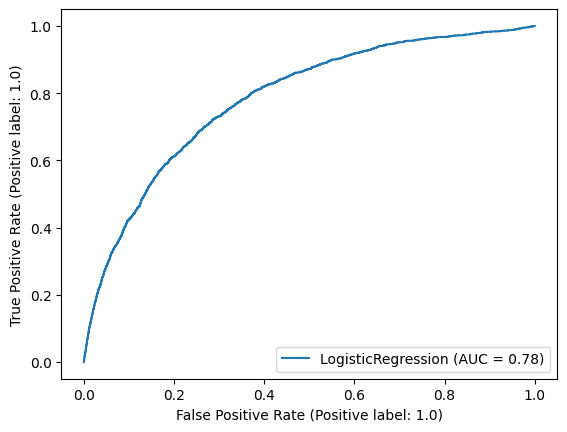

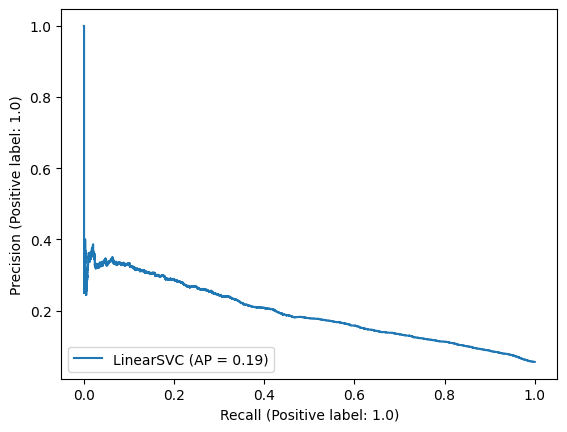

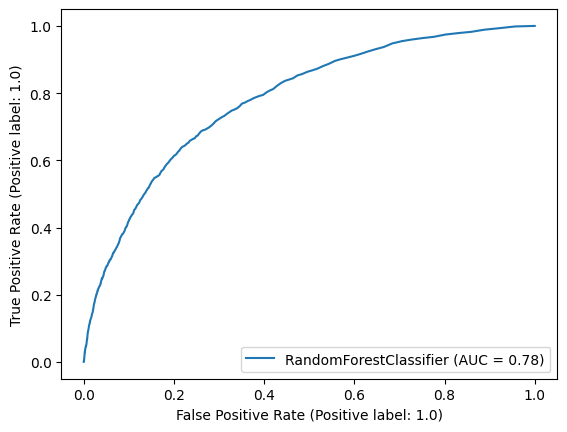

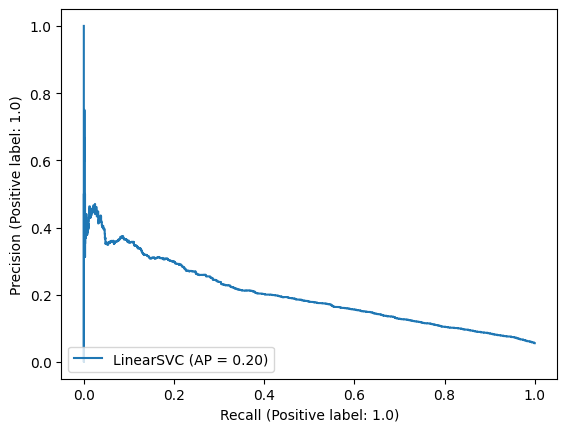

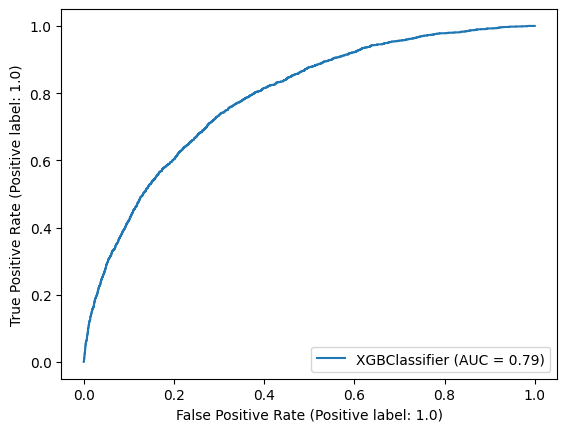

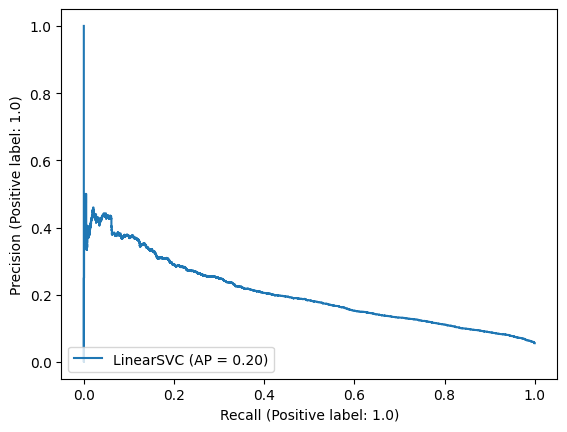

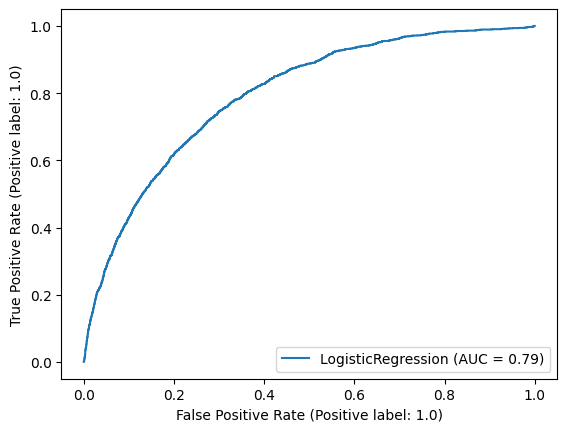

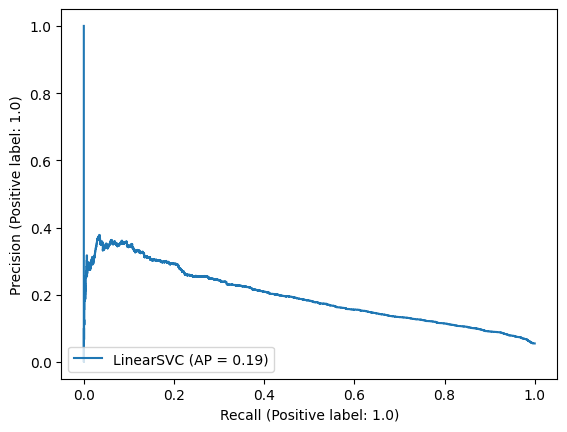

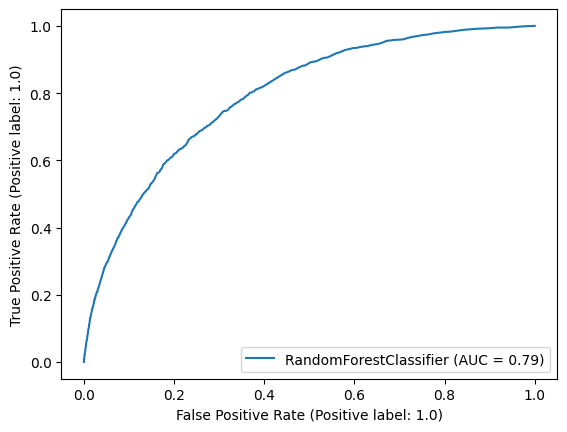

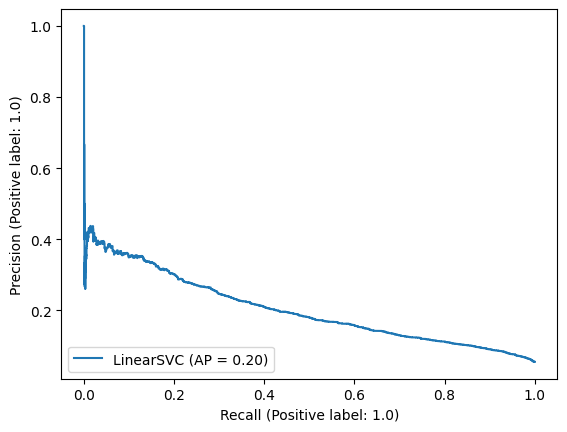

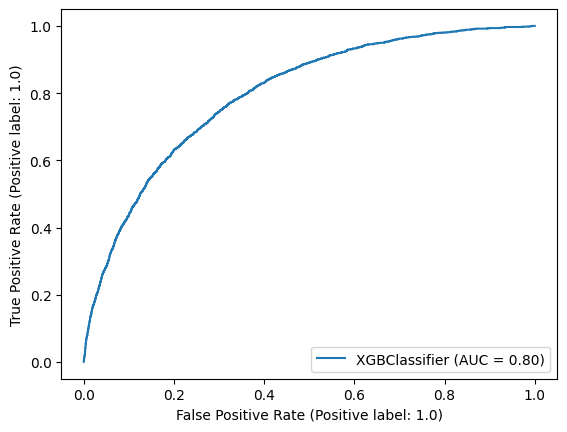

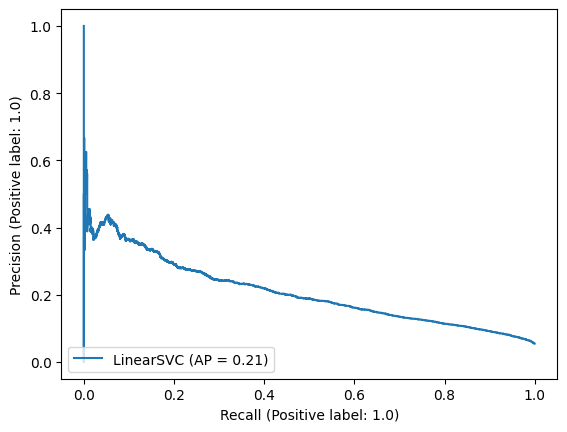

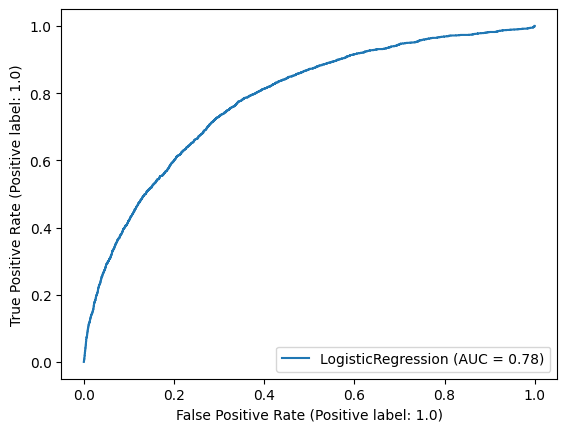

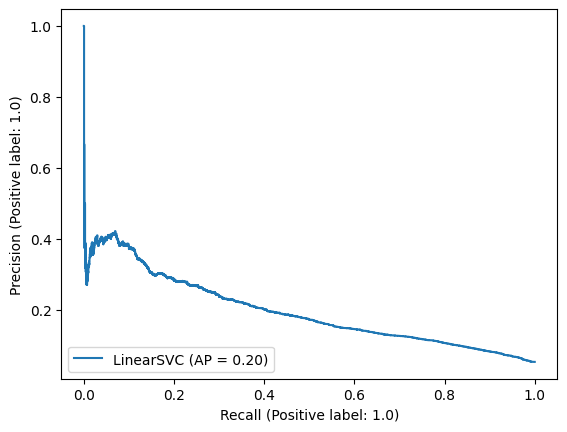

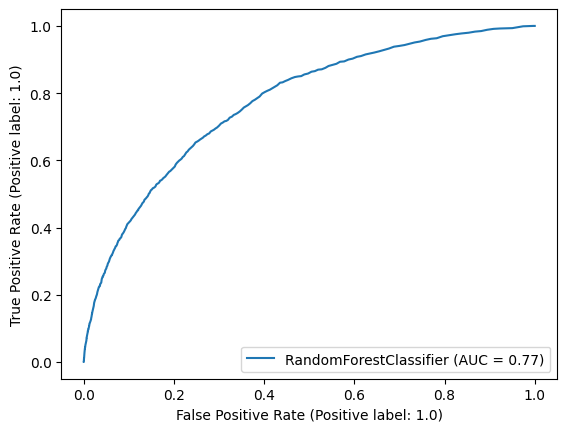

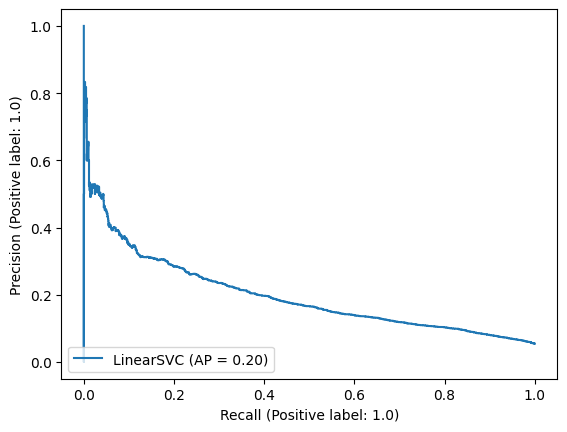

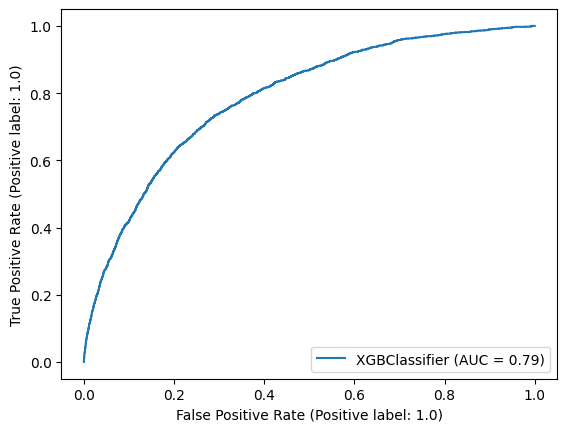

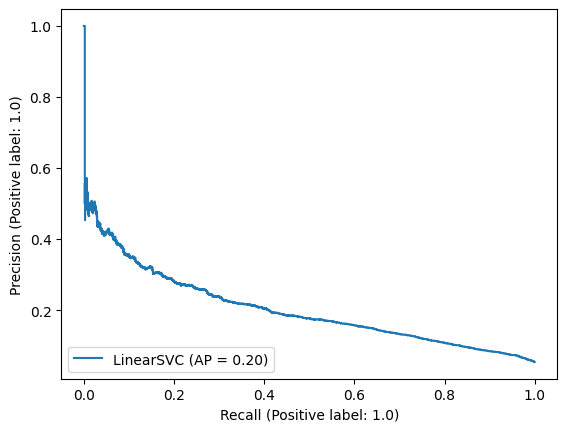

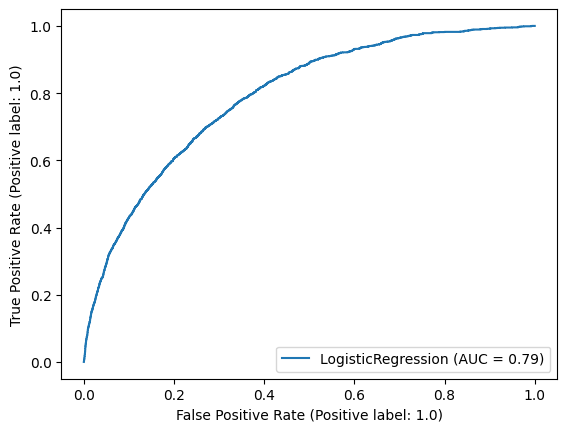

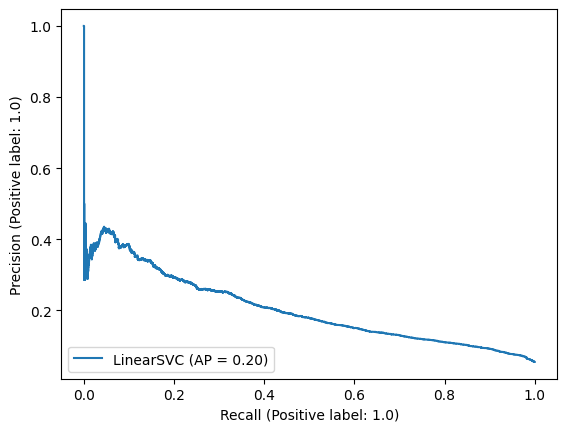

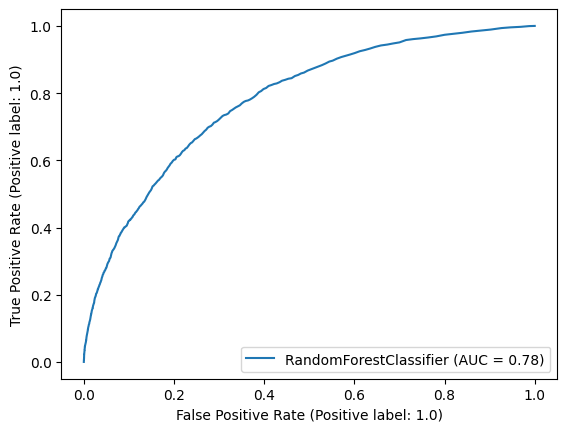

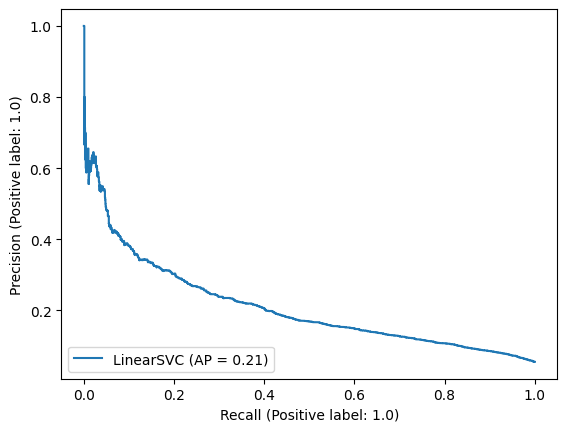

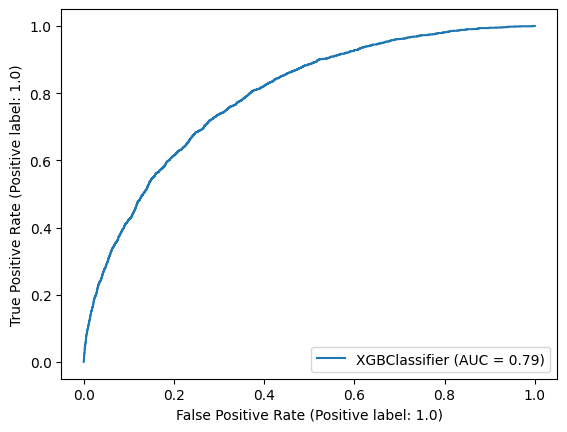

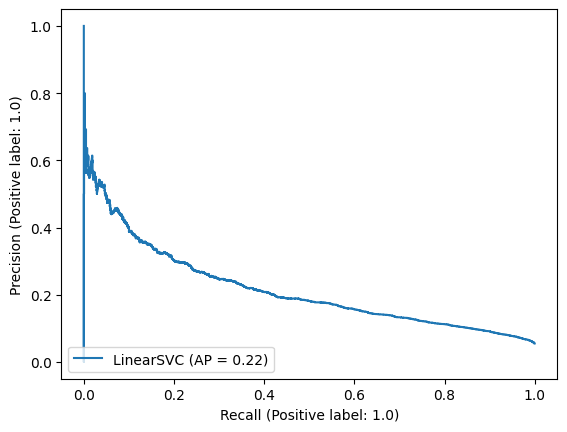

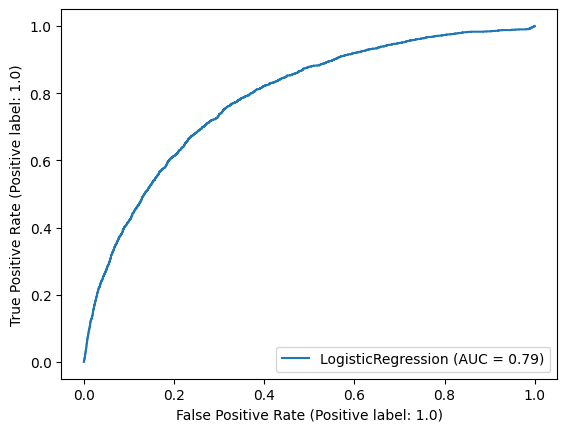

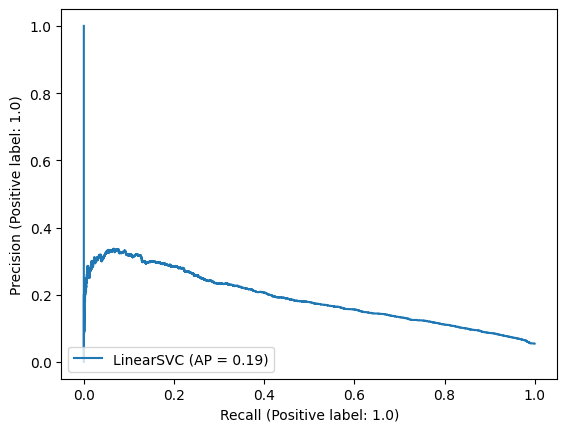

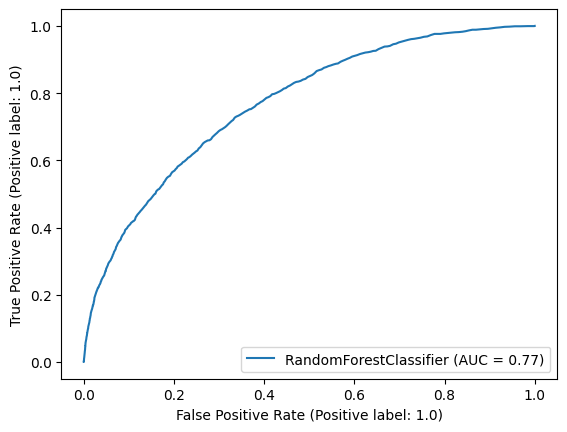

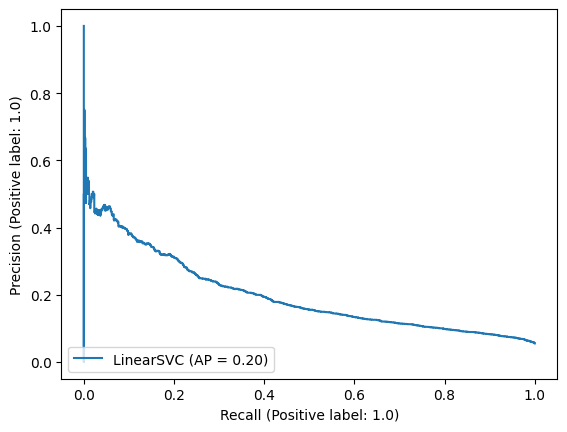

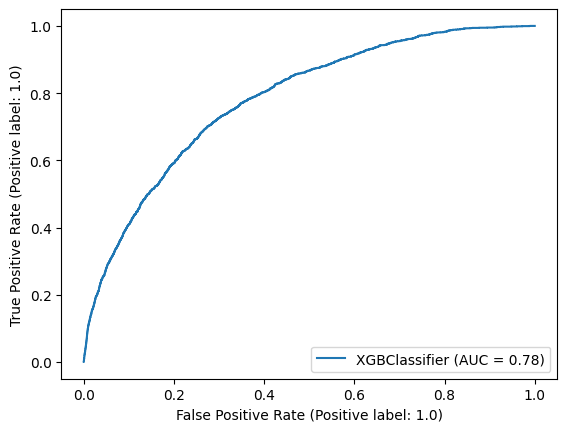

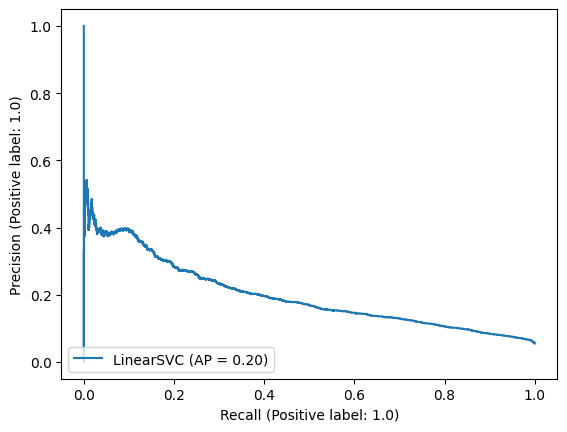

In [11]:
holdoutCTAGBAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Real_Datasets/testCTABGAN1.csv")
synthCTABGAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Fake_Datasets/300epoch_AUCPRC/300epoch_AUCPRC_fake_1.csv")
print('Logistic: ')
TRTRtesting(synthCTABGAN, holdoutCTAGBAN, 'Logistic')
print('Random Forest: ')
TRTRtesting(synthCTABGAN, holdoutCTAGBAN, 'rf')
print('XGBoost: ')
TRTRtesting(synthCTABGAN, holdoutCTAGBAN, 'XGBoost')

holdoutCTAGBAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Real_Datasets/testCTABGAN2.csv")
synthCTABGAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Fake_Datasets/300epoch_AUCPRC/300epoch_AUCPRC_fake_2.csv")
print('Logistic: ')
TRTRtesting(synthCTABGAN, holdoutCTAGBAN, 'Logistic')
print('Random Forest: ')
TRTRtesting(synthCTABGAN, holdoutCTAGBAN, 'rf')
print('XGBoost: ')
TRTRtesting(synthCTABGAN, holdoutCTAGBAN, 'XGBoost')

holdoutCTAGBAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Real_Datasets/testCTABGAN3.csv")
synthCTABGAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Fake_Datasets/300epoch_AUCPRC/300epoch_AUCPRC_fake_3.csv")
print('Logistic: ')
TRTRtesting(synthCTABGAN, holdoutCTAGBAN, 'Logistic')
print('Random Forest: ')
TRTRtesting(synthCTABGAN, holdoutCTAGBAN, 'rf')
print('XGBoost: ')
TRTRtesting(synthCTABGAN, holdoutCTAGBAN, 'XGBoost')

holdoutCTAGBAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Real_Datasets/testCTABGAN4.csv")
synthCTABGAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Fake_Datasets/300epoch_AUCPRC/300epoch_AUCPRC_fake_4.csv")
print('Logistic: ')
TRTRtesting(synthCTABGAN, holdoutCTAGBAN, 'Logistic')
print('Random Forest: ')
TRTRtesting(synthCTABGAN, holdoutCTAGBAN, 'rf')
print('XGBoost: ')
TRTRtesting(synthCTABGAN, holdoutCTAGBAN, 'XGBoost')

holdoutCTAGBAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Real_Datasets/testCTABGAN5.csv")
synthCTABGAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Fake_Datasets/300epoch_AUCPRC/300epoch_AUCPRC_fake_5.csv")
print('Logistic: ')
TRTRtesting(synthCTABGAN, holdoutCTAGBAN, 'Logistic')
print('Random Forest: ')
TRTRtesting(synthCTABGAN, holdoutCTAGBAN, 'rf')
print('XGBoost: ')
TRTRtesting(synthCTABGAN, holdoutCTAGBAN, 'XGBoost')

In [13]:
LogisticAUC=[0.78,0.79,0.78,0.79,0.79]
RandomForestAUC=[0.78,0.79,0.77,0.78,0.77]
XGBoostAUC=[0.79,0.8,0.79,0.79,0.78]



LogisticAUC=np.array(LogisticAUC)
RandomForestAUC=np.array(RandomForestAUC)
XGBoostAUC=np.array(XGBoostAUC)

print("Logistic AUC")
print('mean: ',LogisticAUC.mean())
print('std: ',LogisticAUC.std())
print("Random Forest AUC")
print('mean: ',RandomForestAUC.mean())
print('std: ',RandomForestAUC.std())
print("XGBoost AUC")
print('mean: ',XGBoostAUC.mean())
print('std: ',XGBoostAUC.std())




Logistic AUC
mean:  0.786
std:  0.004898979485566361
Random Forest AUC
mean:  0.778
std:  0.007483314773547889
XGBoost AUC
mean:  0.79
std:  0.006324555320336764


(0.786, 0.004)

#### CTABGAN+ AUC PRC 150 epoch

Logistic: 


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Random Forest: 
XGBoost: 
[15:25:34] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

Logistic: 


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Random Forest: 
XGBoost: 
[15:27:02] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

Logistic: 


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Random Forest: 
XGBoost: 
[15:28:36] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

Logistic: 


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Random Forest: 


C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_plot\roc_curve.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


XGBoost: 
[15:30:14] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

Logistic: 


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Random Forest: 
XGBoost: 
[15:31:56] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.



(<sklearn.metrics._plot.roc_curve.RocCurveDisplay at 0x1e0b0e83a00>,
 <sklearn.metrics._plot.precision_recall_curve.PrecisionRecallDisplay at 0x1e0b3848a30>)

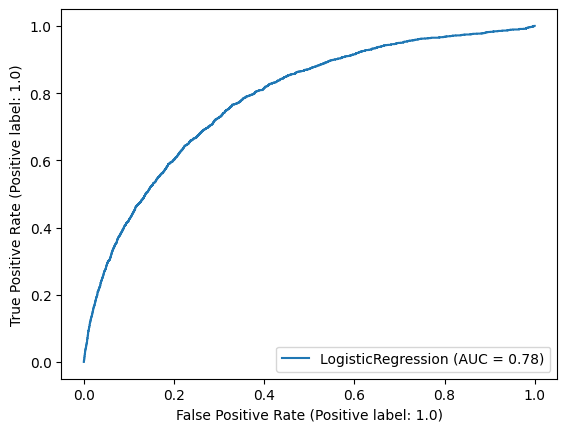

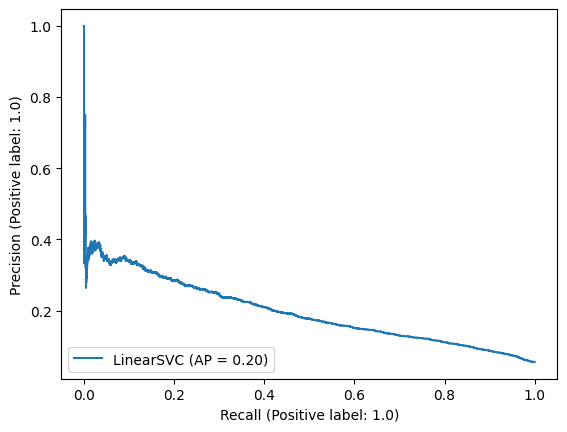

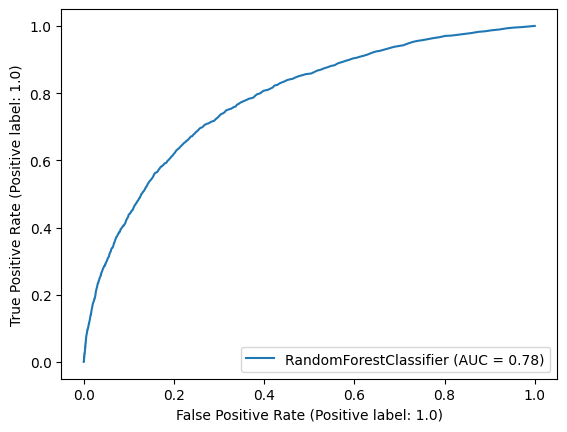

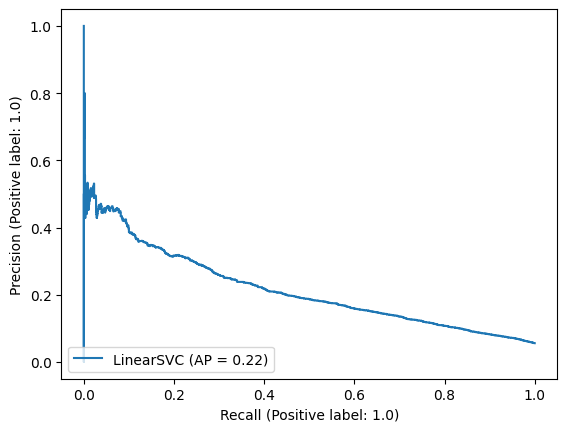

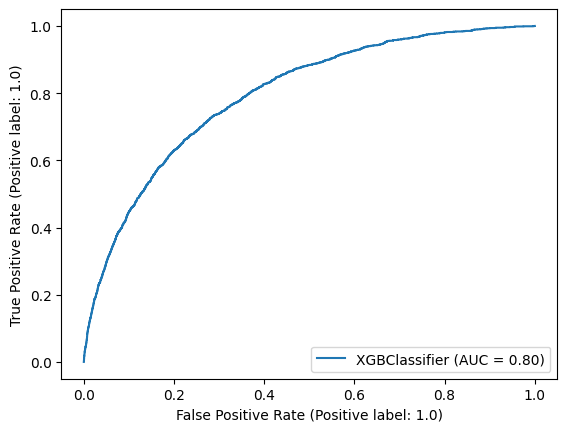

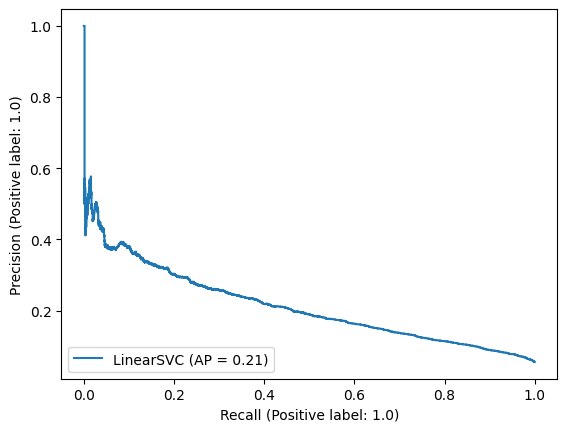

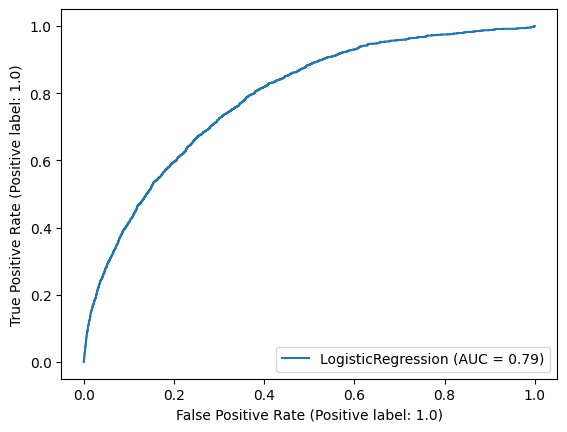

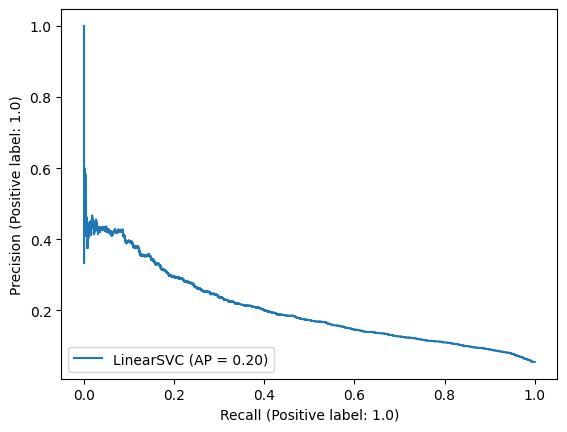

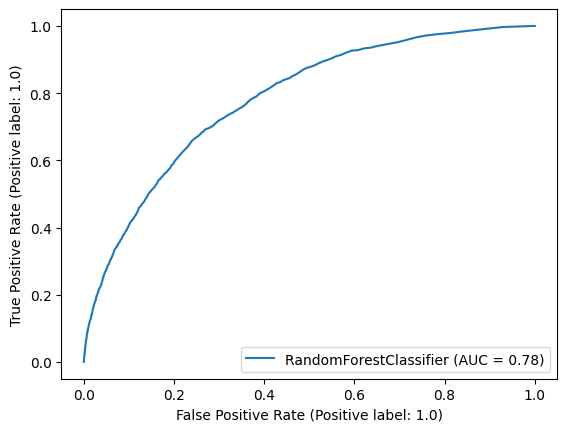

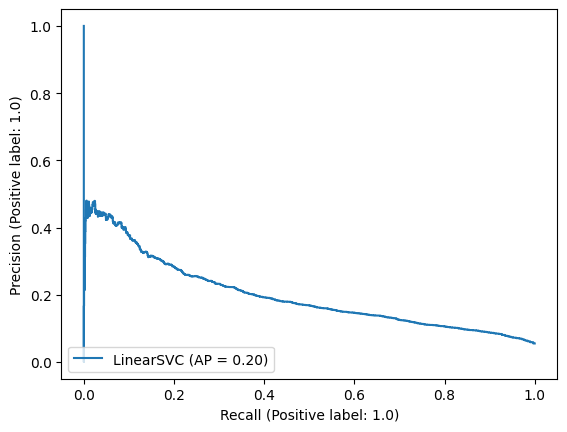

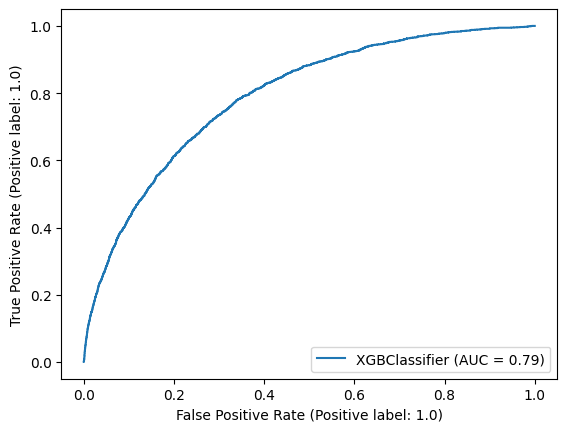

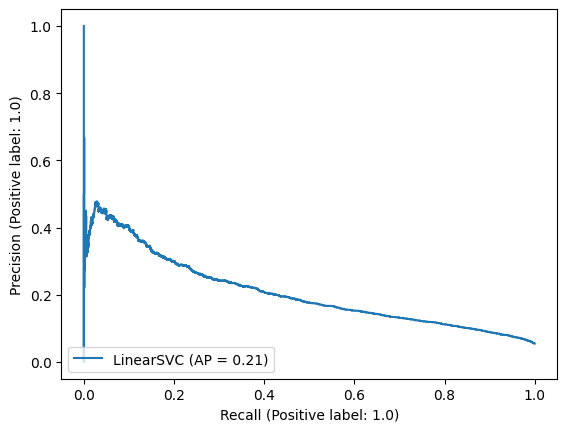

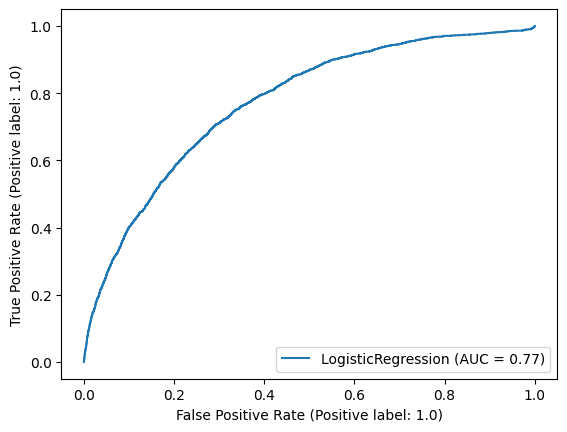

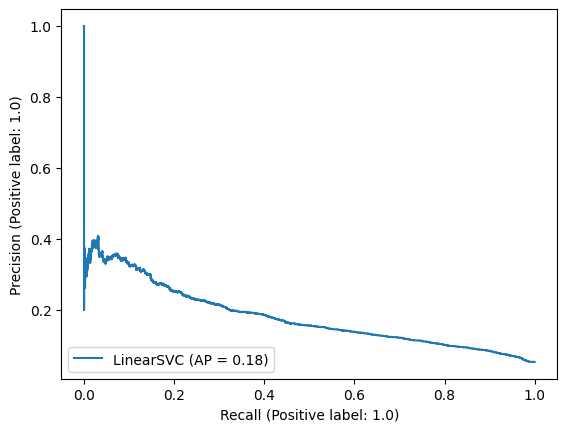

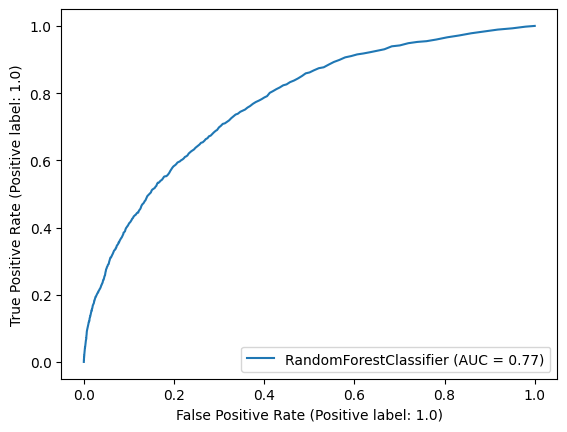

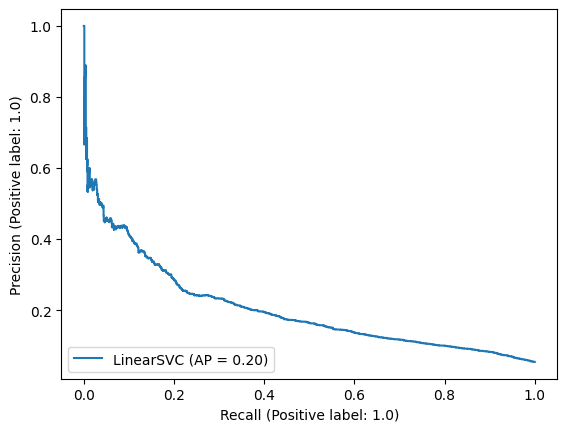

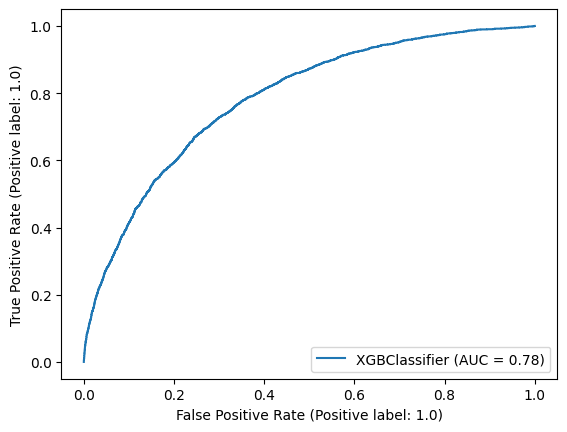

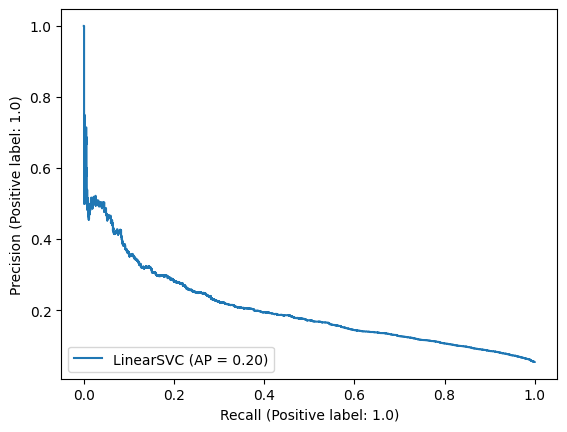

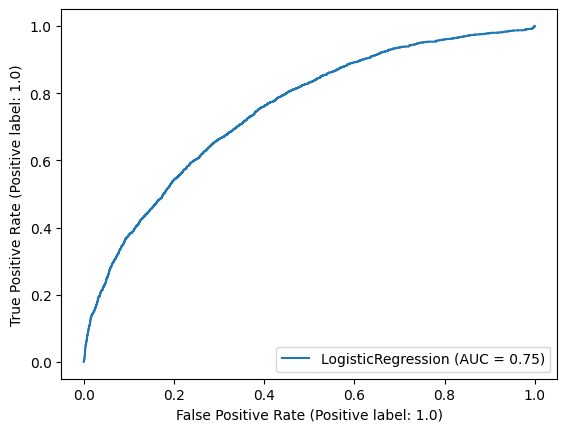

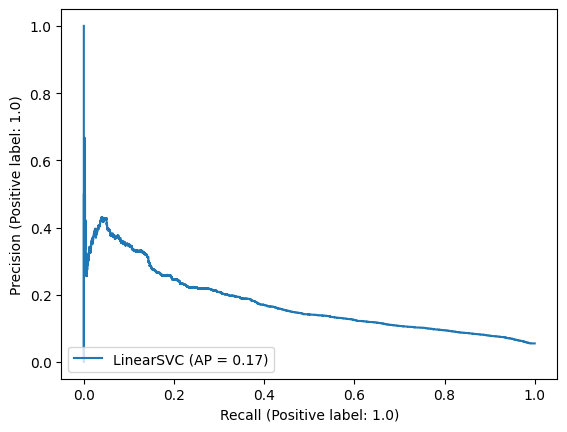

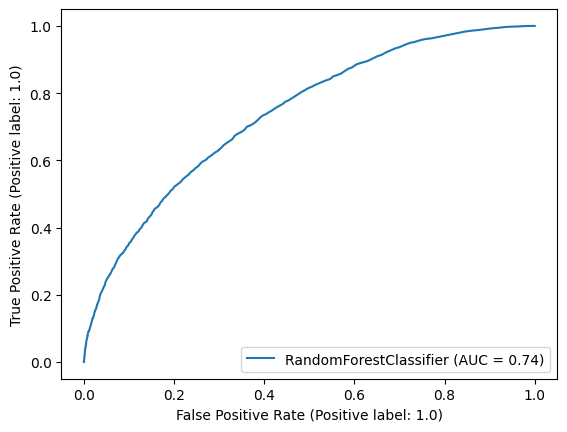

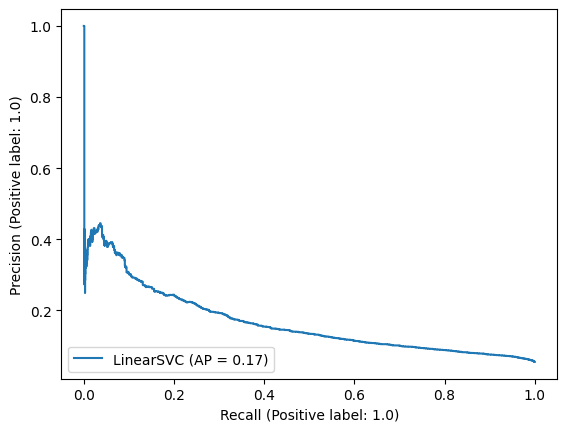

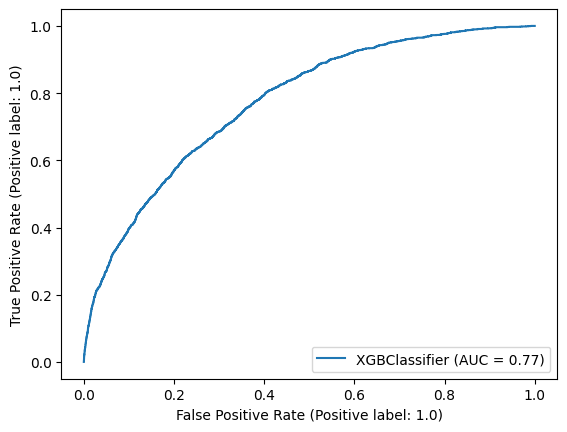

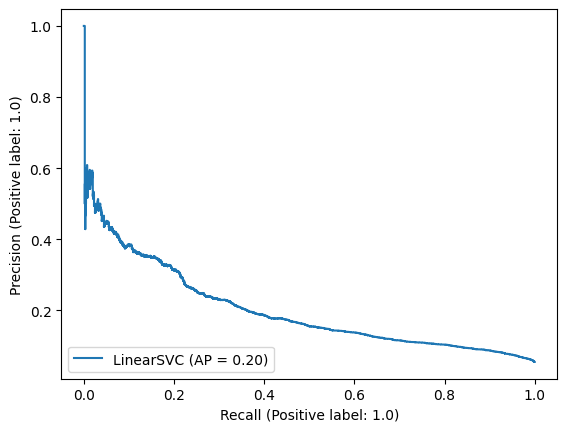

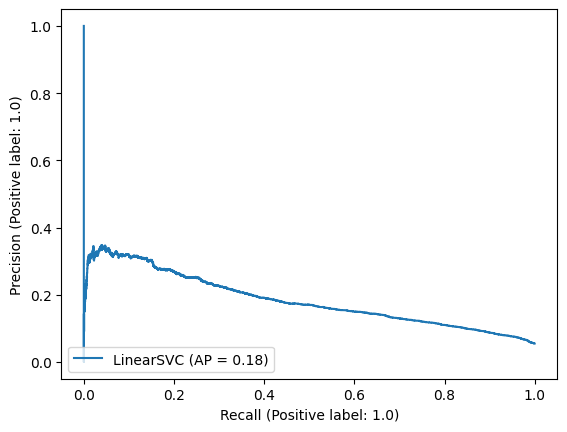

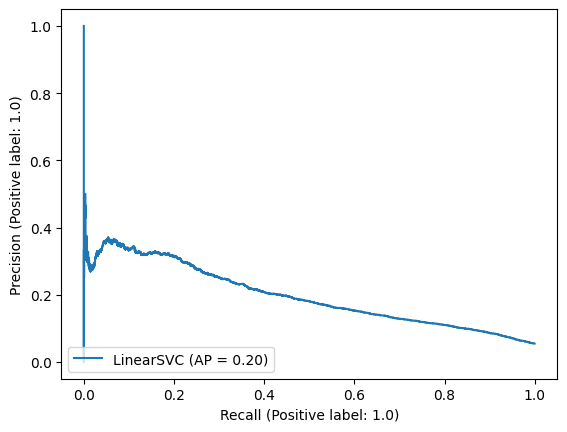

In [14]:
holdoutCTAGBAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Real_Datasets/testCTABGAN1.csv")
synthCTABGAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Fake_Datasets/150epoch_AUCPRC/150epoch_AUCPRC_fake_1.csv")
print('Logistic: ')
TRTRtesting(synthCTABGAN, holdoutCTAGBAN, 'Logistic')
print('Random Forest: ')
TRTRtesting(synthCTABGAN, holdoutCTAGBAN, 'rf')
print('XGBoost: ')
TRTRtesting(synthCTABGAN, holdoutCTAGBAN, 'XGBoost')

holdoutCTAGBAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Real_Datasets/testCTABGAN2.csv")
synthCTABGAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Fake_Datasets/150epoch_AUCPRC/150epoch_AUCPRC_fake_2.csv")
print('Logistic: ')
TRTRtesting(synthCTABGAN, holdoutCTAGBAN, 'Logistic')
print('Random Forest: ')
TRTRtesting(synthCTABGAN, holdoutCTAGBAN, 'rf')
print('XGBoost: ')
TRTRtesting(synthCTABGAN, holdoutCTAGBAN, 'XGBoost')

holdoutCTAGBAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Real_Datasets/testCTABGAN3.csv")
synthCTABGAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Fake_Datasets/150epoch_AUCPRC/150epoch_AUCPRC_fake_3.csv")
print('Logistic: ')
TRTRtesting(synthCTABGAN, holdoutCTAGBAN, 'Logistic')
print('Random Forest: ')
TRTRtesting(synthCTABGAN, holdoutCTAGBAN, 'rf')
print('XGBoost: ')
TRTRtesting(synthCTABGAN, holdoutCTAGBAN, 'XGBoost')

holdoutCTAGBAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Real_Datasets/testCTABGAN4.csv")
synthCTABGAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Fake_Datasets/150epoch_AUCPRC/150epoch_AUCPRC_fake_4.csv")
print('Logistic: ')
TRTRtesting(synthCTABGAN, holdoutCTAGBAN, 'Logistic')
print('Random Forest: ')
TRTRtesting(synthCTABGAN, holdoutCTAGBAN, 'rf')
print('XGBoost: ')
TRTRtesting(synthCTABGAN, holdoutCTAGBAN, 'XGBoost')

holdoutCTAGBAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Real_Datasets/testCTABGAN5.csv")
synthCTABGAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Fake_Datasets/150epoch_AUCPRC/150epoch_AUCPRC_fake_5.csv")
print('Logistic: ')
TRTRtesting(synthCTABGAN, holdoutCTAGBAN, 'Logistic')
print('Random Forest: ')
TRTRtesting(synthCTABGAN, holdoutCTAGBAN, 'rf')
print('XGBoost: ')
TRTRtesting(synthCTABGAN, holdoutCTAGBAN, 'XGBoost')

In [17]:
LogisticAUC=[0.78,0.79,0.77,0.75,0.78]
RandomForestAUC=[0.78,0.78,0.77,0.74,0.76]
XGBoostAUC=[0.8,0.79,0.78,0.77,0.78]



LogisticAUC=np.array(LogisticAUC)
RandomForestAUC=np.array(RandomForestAUC)
XGBoostAUC=np.array(XGBoostAUC)

print("Logistic AUC")
print('mean: ',LogisticAUC.mean())
print('std: ',LogisticAUC.std())
print("Random Forest AUC")
print('mean: ',RandomForestAUC.mean())
print('std: ',RandomForestAUC.std())
print("XGBoost AUC")
print('mean: ',XGBoostAUC.mean())
print('std: ',XGBoostAUC.std())


Logistic AUC
mean:  0.774
std:  0.013564659966250548
Random Forest AUC
mean:  0.766
std:  0.014966629547095779
XGBoost AUC
mean:  0.784
std:  0.01019803902718558


In [ ]:
#it took 57:03, 57:56, 56:55, 53:47, 55:54 time 

#### CTABGAN+ AUC PRC 50 epoch

In [ ]:
holdoutCTAGBAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Real_Datasets/testCTABGAN1.csv")
synthCTABGAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Fake_Datasets/50epoch_AUCPRC/50epoch_AUCPRC_fake_1.csv")
print('Logistic: ')
TRTRtesting(synthCTABGAN, holdoutCTAGBAN, 'Logistic')
print('Random Forest: ')
TRTRtesting(synthCTABGAN, holdoutCTAGBAN, 'rf')
print('XGBoost: ')
TRTRtesting(synthCTABGAN, holdoutCTAGBAN, 'XGBoost')

holdoutCTAGBAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Real_Datasets/testCTABGAN2.csv")
synthCTABGAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Fake_Datasets/50epoch_AUCPRC/50epoch_AUCPRC_fake_2.csv")
print('Logistic: ')
TRTRtesting(synthCTABGAN, holdoutCTAGBAN, 'Logistic')
print('Random Forest: ')
TRTRtesting(synthCTABGAN, holdoutCTAGBAN, 'rf')
print('XGBoost: ')
TRTRtesting(synthCTABGAN, holdoutCTAGBAN, 'XGBoost')

holdoutCTAGBAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Real_Datasets/testCTABGAN3.csv")
synthCTABGAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Fake_Datasets/50epoch_AUCPRC/50epoch_AUCPRC_fake_3.csv")
print('Logistic: ')
TRTRtesting(synthCTABGAN, holdoutCTAGBAN, 'Logistic')
print('Random Forest: ')
TRTRtesting(synthCTABGAN, holdoutCTAGBAN, 'rf')
print('XGBoost: ')
TRTRtesting(synthCTABGAN, holdoutCTAGBAN, 'XGBoost')

holdoutCTAGBAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Real_Datasets/testCTABGAN4.csv")
synthCTABGAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Fake_Datasets/50epoch_AUCPRC/50epoch_AUCPRC_fake_4.csv")
print('Logistic: ')
TRTRtesting(synthCTABGAN, holdoutCTAGBAN, 'Logistic')
print('Random Forest: ')
TRTRtesting(synthCTABGAN, holdoutCTAGBAN, 'rf')
print('XGBoost: ')
TRTRtesting(synthCTABGAN, holdoutCTAGBAN, 'XGBoost')

holdoutCTAGBAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Real_Datasets/testCTABGAN5.csv")
synthCTABGAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Fake_Datasets/50epoch_AUCPRC/50epoch_AUCPRC_fake_5.csv")
print('Logistic: ')
TRTRtesting(synthCTABGAN, holdoutCTAGBAN, 'Logistic')
print('Random Forest: ')
TRTRtesting(synthCTABGAN, holdoutCTAGBAN, 'rf')
print('XGBoost: ')
TRTRtesting(synthCTABGAN, holdoutCTAGBAN, 'XGBoost')

#### CTGAN KS

In [7]:
trainCTGAN = pd.read_csv("Results/CTGAN_100_epoch_for_KS_100%_1ndRun/CTGAN_100_epoch_for_KS_100%_1ndRun_originalData.csv", sep=",", encoding='cp1252')
synthCTGAN = pd.read_csv("Results/CTGAN_100_epoch_for_KS_100%_1ndRun/CTGAN_100_epoch_for_KS_100%_1ndRun_synthData.csv", sep=",", encoding='cp1252')
trainCTGAN = trainCTGAN.drop(trainCTGAN.columns[0],axis = 1)
synthCTGAN = synthCTGAN.drop(synthCTGAN.columns[0],axis = 1)

In [8]:
df=getKomolgorovSmirnovOfDf(trainCTGAN, synthCTGAN)
df

Variable Name  KS Value
0             AGE  0.234700
1          GENDER  0.260779
2              HR  0.125347
3             DBP  0.119464
4              RR  0.274067
5             SBP  0.120790
6            SPO2  0.234727
7        count_ER  0.294565
8       count_ICU  0.098200
9   count_Surgery  0.096812
10             MI  0.019305
11            CHF  0.059331
12            PVD  0.049763
13            str  0.003382
14            dem  0.028874
15            cpd  0.002092
16             rd  0.041236
17            pud  0.044761
18         dm_woc  0.022367
19           dm_c  0.027245
20           hemi  0.028615
21          renal  0.174256
22          tu_le  0.060666
23            mst  0.022341
24            mld  0.132530
25            sld  0.038023
26         dth_In  0.055914

In [9]:
print('KS std: '+str(np.std(np.array(df['KS Value'])))+'KS mean: '+str(np.mean(np.array(df['KS Value']))))
print('KS median: '+str(np.quantile(np.array(df['KS Value']),0.5)))
print('KS upper quantile: '+str(np.quantile(np.array(df['KS Value']),0.025))+'KS Lower quantile: '+str(np.quantile(np.array(df['KS Value']),0.975)))

KS std: 0.08803593040669486KS mean: 0.09889454571347196
KS median: 0.05933138706921104
KS upper quantile: 0.0029305219310737764KS Lower quantile: 0.2812415444317858


#### TABDDPM 25000 KS

In [43]:
trainTabDDPM = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/b_SytheticData_Project/Results/TDDPM_25000_final_test_KS_kyuHwan_stability_1/RealTDDPM_1.csv", sep=",", encoding='cp1252')
synthTabDDPM = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/b_SytheticData_Project/Results/TDDPM_25000_final_test_KS_kyuHwan_stability_1/SyntheticTDDPM_1.csv", sep=",", encoding='cp1252')
trainTabDDPM = trainTabDDPM.drop(trainTabDDPM.columns[0],axis = 1)
synthTabDDPM = synthTabDDPM.drop(synthTabDDPM.columns[0],axis = 1)
df=getKomolgorovSmirnovOfDf(trainTabDDPM, synthTabDDPM)
df

Variable Name  KS Value
0             AGE  0.087931
1          GENDER  0.014112
2              HR  0.066286
3             DBP  0.109437
4              RR  0.049294
5             SBP  0.067379
6            SPO2  0.042201
7        count_ER  0.078979
8       count_ICU  0.090000
9   count_Surgery  0.021949
10             MI  0.015577
11            CHF  0.028669
12            PVD  0.046662
13            str  0.079324
14            dem  0.027825
15            cpd  0.024819
16             rd  0.006868
17            pud  0.020625
18         dm_woc  0.093251
19           dm_c  0.031177
20           hemi  0.030194
21          renal  0.015130
22          tu_le  0.019710
23            mst  0.000591
24            mld  0.057406
25            sld  0.023660
26         dth_In  0.000078

In [44]:
print('KS std: '+str(np.std(np.array(df['KS Value'])))+'KS mean: '+str(np.mean(np.array(df['KS Value']))))
print('KS median: '+str(np.quantile(np.array(df['KS Value']),0.5)))
print('KS upper quantile: '+str(np.quantile(np.array(df['KS Value']),0.025))+'KS Lower quantile: '+str(np.quantile(np.array(df['KS Value']),0.975)))

KS std: 0.03067946646409534KS mean: 0.04256054571246835
KS median: 0.030194263244922914
KS upper quantile: 0.0004113846395862264KS Lower quantile: 0.09891619519578533


#### TABDDPM 50000 KS

In [44]:
trainTabDDPM = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/b_SytheticData_Project/Results/0_Final_results/TabDDPM/TDDPM_50000_steps_for_KScomparison_0.99_0.002_1ndRun/RealTDDPM_1.csv", sep=",", encoding='cp1252')
synthTabDDPM = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/b_SytheticData_Project/Results/0_Final_results/TabDDPM/TDDPM_50000_steps_for_KScomparison_0.99_0.002_1ndRun/SyntheticTDDPM_1.csv", sep=",", encoding='cp1252')
trainTabDDPM = trainTabDDPM.drop(trainTabDDPM.columns[0],axis = 1)
synthTabDDPM = synthTabDDPM.drop(synthTabDDPM.columns[0],axis = 1)

In [45]:
df=getKomolgorovSmirnovOfDf(trainTabDDPM, synthTabDDPM)
df

Variable Name  KS Value
0             AGE  0.010177
1          GENDER  0.000342
2              HR  0.006320
3             DBP  0.006401
4              RR  0.011787
5             SBP  0.006446
6            SPO2  0.013117
7        count_ER  0.018574
8       count_ICU  0.015527
9   count_Surgery  0.010636
10             MI  0.003488
11            CHF  0.006302
12            PVD  0.005044
13            str  0.008712
14            dem  0.003947
15            cpd  0.005790
16             rd  0.002679
17            pud  0.006977
18         dm_woc  0.010645
19           dm_c  0.007210
20           hemi  0.001277
21          renal  0.008011
22          tu_le  0.004648
23            mst  0.004540
24            mld  0.007912
25            sld  0.001906
26         dth_In  0.000881

In [46]:
print('KS std: '+str(np.std(np.array(df['KS Value'])))+'KS mean: '+str(np.mean(np.array(df['KS Value']))))
print('KS median: '+str(np.quantile(np.array(df['KS Value']),0.5)))
print('KS upper quantile: '+str(np.quantile(np.array(df['KS Value']),0.025))+'KS Lower quantile: '+str(np.quantile(np.array(df['KS Value']),0.975)))

KS std: 0.004336399777642748KS mean: 0.007010957805721708
KS median: 0.006401265868306583
KS upper quantile: 0.0006922717301398706KS Lower quantile: 0.0165933937497752


#### TABDDPM 75000 KS

In [45]:
trainTabDDPM = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/b_SytheticData_Project/Results/TDDPM_75000_final_test_KS_kyuHwan_stability_1/RealTDDPM_1.csv", sep=",", encoding='cp1252')
synthTabDDPM = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/b_SytheticData_Project/Results/TDDPM_75000_final_test_KS_kyuHwan_stability_1/SyntheticTDDPM_1.csv", sep=",", encoding='cp1252')
trainTabDDPM = trainTabDDPM.drop(trainTabDDPM.columns[0],axis = 1)
synthTabDDPM = synthTabDDPM.drop(synthTabDDPM.columns[0],axis = 1)
df=getKomolgorovSmirnovOfDf(trainTabDDPM, synthTabDDPM)
df

Variable Name  KS Value
0             AGE  0.016922
1          GENDER  0.017673
2              HR  0.021052
3             DBP  0.026018
4              RR  0.057970
5             SBP  0.026028
6            SPO2  0.025018
7        count_ER  0.010905
8       count_ICU  0.013829
9   count_Surgery  0.008785
10             MI  0.005537
11            CHF  0.017196
12            PVD  0.010045
13            str  0.012765
14            dem  0.016574
15            cpd  0.005496
16             rd  0.008354
17            pud  0.008387
18         dm_woc  0.026381
19           dm_c  0.021200
20           hemi  0.011548
21          renal  0.013457
22          tu_le  0.015900
23            mst  0.010506
24            mld  0.001172
25            sld  0.014955
26         dth_In  0.000078

In [46]:
print('KS std: '+str(np.std(np.array(df['KS Value'])))+'KS mean: '+str(np.mean(np.array(df['KS Value']))))
print('KS median: '+str(np.quantile(np.array(df['KS Value']),0.5)))
print('KS upper quantile: '+str(np.quantile(np.array(df['KS Value']),0.025))+'KS Lower quantile: '+str(np.quantile(np.array(df['KS Value']),0.975)))

KS std: 0.010891270752629885KS mean: 0.01569448378261438
KS median: 0.013829314142675964
KS upper quantile: 0.0007893472909683897KS Lower quantile: 0.03743708683759596


#### CTABGAN+ KS 450 epoch

In [14]:
trainCTGAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Real_Datasets/cleanedDataWithoutOutliers_SPO2Corrected_clean.csv", sep=",", encoding='cp1252')
synthCTGAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Fake_Datasets/450epoch_KS/450epoch_KS_fake_1.csv", sep=",", encoding='cp1252')
trainCTGAN = trainCTGAN.drop(trainCTGAN.columns[0],axis = 1)
synthCTGAN = synthCTGAN.drop(synthCTGAN.columns[0],axis = 1)
df=getKomolgorovSmirnovOfDf(trainCTGAN, synthCTGAN)
df


Variable Name  KS Value
0          GENDER  0.096367
1              HR  0.159178
2             DBP  0.026657
3              RR  0.045313
4             SBP  0.070181
5            SPO2  0.103051
6        count_ER  0.644154
7       count_ICU  0.797173
8   count_Surgery  0.486667
9              MI  0.014188
10            CHF  0.039358
11            PVD  0.022616
12            str  0.044672
13            dem  0.001673
14            cpd  0.034445
15             rd  0.001326
16            pud  0.044806
17         dm_woc  0.105232
18           dm_c  0.034428
19           hemi  0.007601
20          renal  0.086683
21          tu_le  0.262167
22            mst  0.093002
23            mld  0.084369
24            sld  0.000267
25         dth_In  0.022118

In [15]:
print('KS std: '+str(np.std(np.array(df['KS Value'])))+'KS mean: '+str(np.mean(np.array(df['KS Value']))))
print('KS median: '+str(np.quantile(np.array(df['KS Value']),0.5)))
print('KS upper quantile: '+str(np.quantile(np.array(df['KS Value']),0.025))+'KS Lower quantile: '+str(np.quantile(np.array(df['KS Value']),0.975)))

KS std: 0.19870416458150142KS mean: 0.12798820465350655
KS median: 0.04505927798348053
KS upper quantile: 0.0009289999287951795KS Lower quantile: 0.7015362432355454


In [ ]:
trainCTGAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Real_Datasets/cleanedDataWithoutOutliers_SPO2Corrected_clean.csv", sep=",", encoding='cp1252')
synthCTGAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Fake_Datasets/450epoch_KS/450epoch_KS_fake_2.csv", sep=",", encoding='cp1252')
trainCTGAN = trainCTGAN.drop(trainCTGAN.columns[0],axis = 1)
synthCTGAN = synthCTGAN.drop(synthCTGAN.columns[0],axis = 1)
df=getKomolgorovSmirnovOfDf(trainCTGAN, synthCTGAN)
df
print('KS std: '+str(np.std(np.array(df['KS Value'])))+'KS mean: '+str(np.mean(np.array(df['KS Value']))))
print('KS median: '+str(np.quantile(np.array(df['KS Value']),0.5)))
print('KS upper quantile: '+str(np.quantile(np.array(df['KS Value']),0.025))+'KS Lower quantile: '+str(np.quantile(np.array(df['KS Value']),0.975)))

In [ ]:
trainCTGAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Real_Datasets/cleanedDataWithoutOutliers_SPO2Corrected_clean.csv", sep=",", encoding='cp1252')
synthCTGAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Fake_Datasets/450epoch_KS/450epoch_KS_fake_3.csv", sep=",", encoding='cp1252')
trainCTGAN = trainCTGAN.drop(trainCTGAN.columns[0],axis = 1)
synthCTGAN = synthCTGAN.drop(synthCTGAN.columns[0],axis = 1)
df=getKomolgorovSmirnovOfDf(trainCTGAN, synthCTGAN)
df
print('KS std: '+str(np.std(np.array(df['KS Value'])))+'KS mean: '+str(np.mean(np.array(df['KS Value']))))
print('KS median: '+str(np.quantile(np.array(df['KS Value']),0.5)))
print('KS upper quantile: '+str(np.quantile(np.array(df['KS Value']),0.025))+'KS Lower quantile: '+str(np.quantile(np.array(df['KS Value']),0.975)))

In [ ]:
trainCTGAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Real_Datasets/cleanedDataWithoutOutliers_SPO2Corrected_clean.csv", sep=",", encoding='cp1252')
synthCTGAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Fake_Datasets/450epoch_KS/450epoch_KS_fake_4.csv", sep=",", encoding='cp1252')
trainCTGAN = trainCTGAN.drop(trainCTGAN.columns[0],axis = 1)
synthCTGAN = synthCTGAN.drop(synthCTGAN.columns[0],axis = 1)
df=getKomolgorovSmirnovOfDf(trainCTGAN, synthCTGAN)
df
print('KS std: '+str(np.std(np.array(df['KS Value'])))+'KS mean: '+str(np.mean(np.array(df['KS Value']))))
print('KS median: '+str(np.quantile(np.array(df['KS Value']),0.5)))
print('KS upper quantile: '+str(np.quantile(np.array(df['KS Value']),0.025))+'KS Lower quantile: '+str(np.quantile(np.array(df['KS Value']),0.975)))

In [ ]:
trainCTGAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Real_Datasets/cleanedDataWithoutOutliers_SPO2Corrected_clean.csv", sep=",", encoding='cp1252')
synthCTGAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Fake_Datasets/450epoch_KS/450epoch_KS_fake_5.csv", sep=",", encoding='cp1252')
trainCTGAN = trainCTGAN.drop(trainCTGAN.columns[0],axis = 1)
synthCTGAN = synthCTGAN.drop(synthCTGAN.columns[0],axis = 1)
df=getKomolgorovSmirnovOfDf(trainCTGAN, synthCTGAN)
df
print('KS std: '+str(np.std(np.array(df['KS Value'])))+'KS mean: '+str(np.mean(np.array(df['KS Value']))))
print('KS median: '+str(np.quantile(np.array(df['KS Value']),0.5)))
print('KS upper quantile: '+str(np.quantile(np.array(df['KS Value']),0.025))+'KS Lower quantile: '+str(np.quantile(np.array(df['KS Value']),0.975)))

#### CTABGAN+ KS 300 epoch

In [37]:
cd 

C:\Users\user


In [52]:
trainCTGAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Real_Datasets/cleanedDataWithoutOutliers_SPO2Corrected_clean.csv", sep=",", encoding='cp1252')
synthCTGAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Fake_Datasets/300epoch_KS/300epoch_KS_fake_1.csv", sep=",", encoding='cp1252')
trainCTGAN = trainCTGAN.drop(trainCTGAN.columns[0],axis = 1)
synthCTGAN = synthCTGAN.drop(synthCTGAN.columns[0],axis = 1)
df=getKomolgorovSmirnovOfDf(trainCTGAN, synthCTGAN)
df


Variable Name  KS Value
0          GENDER  0.009889
1              HR  0.019225
2             DBP  0.019537
3              RR  0.023960
4             SBP  0.012461
5            SPO2  0.048090
6        count_ER  0.014223
7       count_ICU  0.012657
8   count_Surgery  0.014900
9              MI  0.000819
10            CHF  0.006400
11            PVD  0.000534
12            str  0.003774
13            dem  0.002492
14            cpd  0.013155
15             rd  0.001780
16            pud  0.010859
17         dm_woc  0.023898
18           dm_c  0.001851
19           hemi  0.000935
20          renal  0.026097
21          tu_le  0.003391
22            mst  0.008803
23            mld  0.025215
24            sld  0.007824
25         dth_In  0.000792

In [53]:
print('KS std: '+str(np.std(np.array(df['KS Value'])))+'KS mean: '+str(np.mean(np.array(df['KS Value']))))
print('KS median: '+str(np.quantile(np.array(df['KS Value']),0.5)))
print('KS upper quantile: '+str(np.quantile(np.array(df['KS Value']),0.025))+'KS Lower quantile: '+str(np.quantile(np.array(df['KS Value']),0.975)))

KS std: 0.010908114911252223KS mean: 0.012059968122165489
KS median: 0.01037364710908567
KS upper quantile: 0.0006953592281400967KS Lower quantile: 0.0343440704215323


#### CTABGAN+ KS 150 epoch

In [50]:
trainCTGAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Real_Datasets/cleanedDataWithoutOutliers_SPO2Corrected_clean.csv", sep=",", encoding='cp1252')
synthCTGAN = pd.read_csv("C:/Users/user/Documents/SMC_WORK_DIRECTORY/CTAB-GAN-Plus-main/Fake_Datasets/150epoch_KS/150epoch_KS_fake_1.csv", sep=",", encoding='cp1252')
trainCTGAN = trainCTGAN.drop(trainCTGAN.columns[0],axis = 1)
synthCTGAN = synthCTGAN.drop(synthCTGAN.columns[0],axis = 1)
df=getKomolgorovSmirnovOfDf(trainCTGAN, synthCTGAN)
df

Variable Name  KS Value
0          GENDER  0.087991
1              HR  0.158876
2             DBP  0.077141
3              RR  0.079393
4             SBP  0.041779
5            SPO2  0.040079
6        count_ER  0.456147
7       count_ICU  0.797752
8   count_Surgery  0.807142
9              MI  0.024539
10            CHF  0.049923
11            PVD  0.040391
12            str  0.089878
13            dem  0.013093
14            cpd  0.030244
15             rd  0.008838
16            pud  0.041797
17         dm_woc  0.060693
18           dm_c  0.022643
19           hemi  0.009363
20          renal  0.089558
21          tu_le  0.202141
22            mst  0.079224
23            mld  0.033982
24            sld  0.003916
25         dth_In  0.023729

In [51]:
print('KS std: '+str(np.std(np.array(df['KS Value'])))+'KS mean: '+str(np.mean(np.array(df['KS Value']))))
print('KS median: '+str(np.quantile(np.array(df['KS Value']),0.5)))
print('KS upper quantile: '+str(np.quantile(np.array(df['KS Value']),0.025))+'KS Lower quantile: '+str(np.quantile(np.array(df['KS Value']),0.975)))

KS std: 0.21344843918643494KS mean: 0.12962523004622833
KS median: 0.04586033181429794
KS upper quantile: 0.006992532398177154KS Lower quantile: 0.8012730080461407


#### CTABGAN+ KS 50 epoch

#### RESULTS TABDDPM

TABDDPM50000 MIA

In [45]:
import numpy as np
TabDDPMIA=[0.47753420259351087, 0.45136721188662754, 0.4305513440236876, 0.5512905124591977, 0.42596721545404276]
CTGANMIA=[0.4783003417829678, 0.4551587866704643, 0.47048561663343774, 0.4671923953289661, 0.5278410709199658]


print("mean: "+str(np.mean(TabDDPMIA)))
print("standard deviation: "+str(np.std(TabDDPMIA)))
print("max result: "+str(np.max(TabDDPMIA)))
print("min result: "+str(np.min(TabDDPMIA)))
#print("upper bound std: "+str(np.mean(result)+np.std(result)))
#print("lower bound std: "+str(np.mean(result)-np.std(result)))

mean: 0.46734209728341325
standard deviation: 0.0457642934096678
max result: 0.5512905124591977
min result: 0.42596721545404276


TABDDPM TSTR RESULTS 5 FOLD (The procedure has basically been training same number of steps every time and do TSTR with it)

TIME DIFFERENCE TESTS

In [2]:
def avgTime(times):
    # Convert times to seconds
    seconds = []
    for t in times:
        h, m, s = map(int, t.split(':'))
        seconds.append(h * 3600 + m * 60 + s)

    # Calculate average seconds
    avg_seconds = sum(seconds) // len(seconds)

    # Convert average seconds to HH:MM:SS format
    avg_h = avg_seconds // 3600
    avg_m = (avg_seconds % 3600) // 60
    avg_s = avg_seconds % 60
    average_time = f"{avg_h:02d}:{avg_m:02d}:{avg_s:02d}"

    print("Average time:", average_time)
    
def maxMinTime(times):
    # Convert times to seconds
    seconds = []
    for t in times:
        h, m, s = map(int, t.split(':'))
        seconds.append(h * 3600 + m * 60 + s)

    # Find minimum and maximum times
    min_time = times[seconds.index(min(seconds))]
    max_time = times[seconds.index(max(seconds))]

    print("Minimum time:", min_time)
    print("Maximum time:", max_time)

In [3]:
times = ['2:43:21', '2:41:45', '2:41:22', '2:41:17', '2:41:07']
avgTime(times)
maxMinTime(times)

Average time: 02:41:46
Minimum time: 2:41:07
Maximum time: 2:43:21


In [ ]:
ctabgan+ 450 epoch: avg 4:03:21 max 4:03:29 min 4:03:18

ctabgan+ 300 epoch: avg 2:41:46 min 2:41:07 max 2:43:21
            
ctabgan+ 225 epoch: avg 2:01:28 min 2:01:23 max 2:01:31           

ctabgan+ 150 epoch: avg 1:21:37 fake run 4 times

tabDDPM 75000 steps: avg 00:07:03 min 0:07:00 max 0:07:09
            
tabDDPM 50000 steps: avg 0:04:36 min 0:04:29, max 0:04:49
                            
tabDDPM 25000 steps: avg 00:02:28 min 0:02:21 max 0:02:32

In [ ]:
Model	Epoch/Steps	Average Time	Minimum Time	Maximum Time
ctabgan+	450	4:03:21	4:03:18	4:03:29
ctabgan+	300	2:43:21	Fake run x4	Fake run x4
ctabgan+	225	2:01:28	2:01:23	2:01:31
ctabgan+	150	1:21:37	Fake run x4	Fake run x4
tabDDPM	75000	0:07:03	0:07:00	0:07:09
tabDDPM	50000	0:04:36	0:04:29	0:04:49
tabDDPM	25000	0:02:28	0:02:21	0:02:32

In [ ]:
Results

CTGAN           0.4986115066932498

TABDDPM50000    0.5622781513654281

TABDDPM20000    0.45580864384710057

TABDDPM10000    0.44527797576621525

TABDDPM6000     0.4918032786885246

TABDDPM3000     0.5226798423202469

In [39]:
synthTVAE['dth_In'].value_counts()

0.0    78646
Name: dth_In, dtype: int64

In [36]:
trainTVAE = pd.read_csv("Results/TVAE_150_Fine_Tuning/TVAE_150_Fine_Tuning_originalData.csv", sep=",", encoding='cp1252')
holdoutTVAE = pd.read_csv("Results/TVAE_150_Fine_Tuning/TVAE_150_Fine_Tuning_testData.csv", sep=",", encoding='cp1252')
synthTVAE = pd.read_csv("Results/TVAE_150_Fine_Tuning/TVAE_150_Fine_Tuning_synthData.csv", sep=",", encoding='cp1252')
#trainCTGAN = trainCTGAN.drop(trainCTGAN.columns[0],axis = 1)
holdoutTVAE = holdoutTVAE.drop(holdoutTVAE.columns[0],axis = 1)
synthTVAE = synthTVAE.drop(synthTVAE.columns[0],axis = 1)
print('Logistic: ')
TRTRtesting(synthTVAE, holdoutTVAE, 'Logistic')
print('Random Forest: ')
TRTRtesting(synthTVAE, holdoutTVAE, 'rf')
print('XGBoost: ')
TRTRtesting(synthTVAE, holdoutTVAE, 'XGBoost')

Logistic: 


ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0.0

In [ ]:
# libraries & dataset
import seaborn as sns
import matplotlib.pyplot as plt
# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
sns.set(style="whitegrid")
f = plt.figure()
f.set_figwidth(7)
f.set_figheight(5)

sns.histplot(data=trainCTGAN, x="AGE", color="darkblue", alpha=0.5, label="Original Data")
sns.histplot(data=synthCTGAN, x="AGE", color="red",alpha=0.5, label="New Data")

plt.legend()

plt.show()